In [2]:
library('sva')
library('gPCA')
library('Biobase')
library("ggfortify")
library('DESeq2')
library(VennDiagram)
library(EnhancedVolcano)
library("ggpubr")
library(pheatmap)
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BiocParallel)
set.seed(2017)
library(gtools)
library(BSgenome.Hsapiens.UCSC.hg19)
library('qvalue')
library(gplots)
library('TFBSTools')

# Download data

In [3]:
########### download raw data
### Download 10x snATAC-seq raw data from NCBI Gene Expression Omnibus (GSE169453)
### Download 10x multiome raw data from NCBI Gene Expression Omnibus (GSE200044)

########### Download processed snATAC-seq and multiome data to reproduce figures
### There several ways to download processed data.
###1, download files less than 25M from github data folder: https://github.com/gaoweiwang/Islet_snATACseq
### or, from figshare:
### multiome: https://figshare.com/articles/dataset/processed_multiome_zip/19497665
### snATACseq: https://figshare.com/articles/dataset/processed_snATACseq_zip/19497656

###2, download large processed or intermeidate files:
#snATAC-seq data (http://169.228.232.194/~mmallick/o/processed_snATACseq.tar.gz)
#multiome data (http://169.228.232.194/~mmallick/o/processed_multiome.tar.gz)

########### change working directory
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

# snATAC-seq data cell composition analysis in Figure 1

In [29]:
# cell annotation from Figure 1b
M=read.csv(paste0(wd_snATAC,'barcode_snATAC_UMAP.csv'))
leiden_ID=sort(unique(M$leiden))
donor_ID=sort(unique(M$donor))
leiden_all=M$leiden
donor_all=M$donor

S_ID=matrix(0,length(leiden_ID),length(donor_ID))
rownames(S_ID)=leiden_ID
colnames(S_ID)=donor_ID
for (i in 1:length(leiden_ID)){
    for (j in 1:length(donor_ID)){
       keep=(leiden_all==leiden_ID[i] & donor_all==donor_ID[j])
       if (dim(M[keep,])[1]>0){
           S_ID[i,j]=dim(M[keep,])[1]
       }
    }
}

### total cell number normalization
sample_totnum=colSums(S_ID)  
S_ID_norm=(S_ID - S_ID)
for (i in 1:dim(S_ID)[2]){
  S_ID_norm[,i]=S_ID[,i]*(10000/sample_totnum[i])
}

## normalized cell number for each cell type
alpha_ID=c(0,4,8)+1
beta_ID=c(1,2,3,5)+1
delta_ID=c(6)+1
gamma_ID=c(10)+1
acinar_ID=c(7)+1
ductal_ID=c(9)+1
stellate_ID=c(11)+1
endothelial_ID=c(13)+1
immune_ID=c(12)+1

CS=matrix(0,9,dim(S_ID_norm)[2])
rownames(CS)=c('alpha','beta','delta','gamma','acinar','ductal','stellate','endothelial','immune')
colnames(CS)=colnames(S_ID_norm)

CS[1,]=colSums(S_ID_norm[alpha_ID,])
CS[2,]=colSums(S_ID_norm[beta_ID,])
CS[3,]=S_ID_norm[delta_ID,]
CS[4,]=S_ID_norm[gamma_ID,]
CS[5,]=S_ID_norm[acinar_ID,]
CS[6,]=S_ID_norm[ductal_ID,]
CS[7,]=S_ID_norm[stellate_ID,]
CS[8,]=S_ID_norm[endothelial_ID,]
CS[9,]=S_ID_norm[immune_ID,]
A2=t(CS)
A2_rowsum=rowSums(A2)
A_row=(A2-A2)
for (i in 1:dim(A2)[1]){
    A_row[i,]=100*(A2[i,]/A2_rowsum[i])
}
A=as.data.frame(A_row)

###clinical information of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
keep=(C$donor %in% rownames(A))
C=C[keep,]
C=C[order(C$donor),]

C1=C[order(C$Sample.Description.Name),]
A1=A[order(C$Sample.Description.Name),]
A2=t(as.matrix(A1))

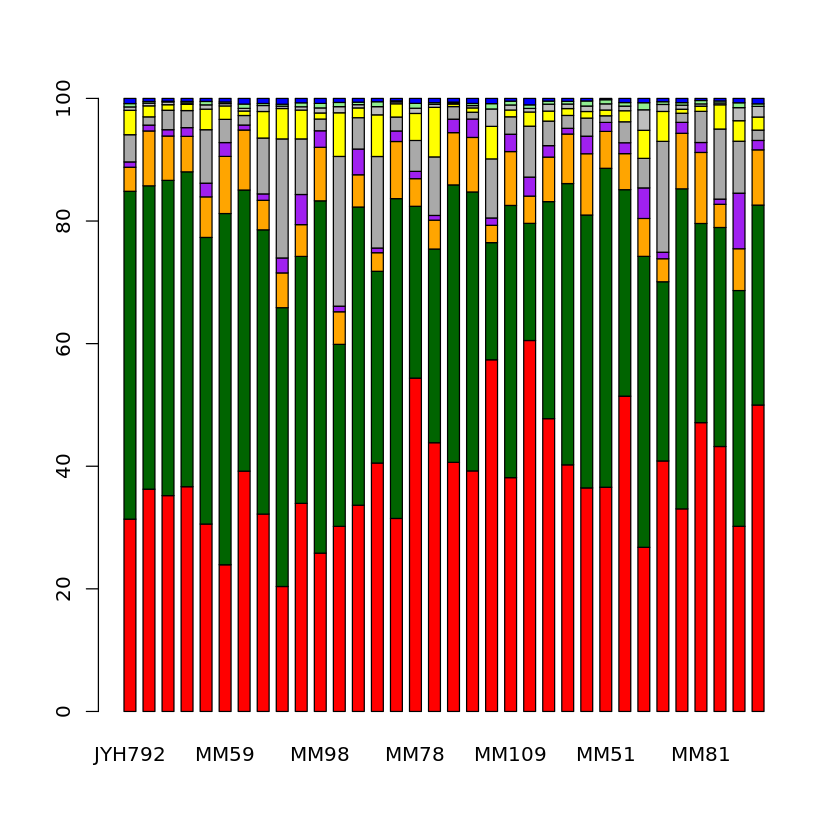

In [30]:
barplot(A2, space=0.6,col=c("red","darkgreen","orange","purple","darkgrey","yellow","grey","lightgreen","blue"),legend.text=FALSE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))

In [31]:
#### disease (all cells)
######## add clinical infromation to each donor
A$Disease=C$Sample.Description.Name
A$method=C$Freezing.storage.method
A$center=C$Center
A$islet.index=C$islet.index
A$age=C$Age
A$gender=C$Gender
A$BMI=C$BMI
A$HbA1c=C$HbA1c
A$Purity=C$Purity

A_mean=aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~Disease , data=A , mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 70

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}
stdev <- aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~Disease, data=A , sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(A$Disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}


[1] 60.5099

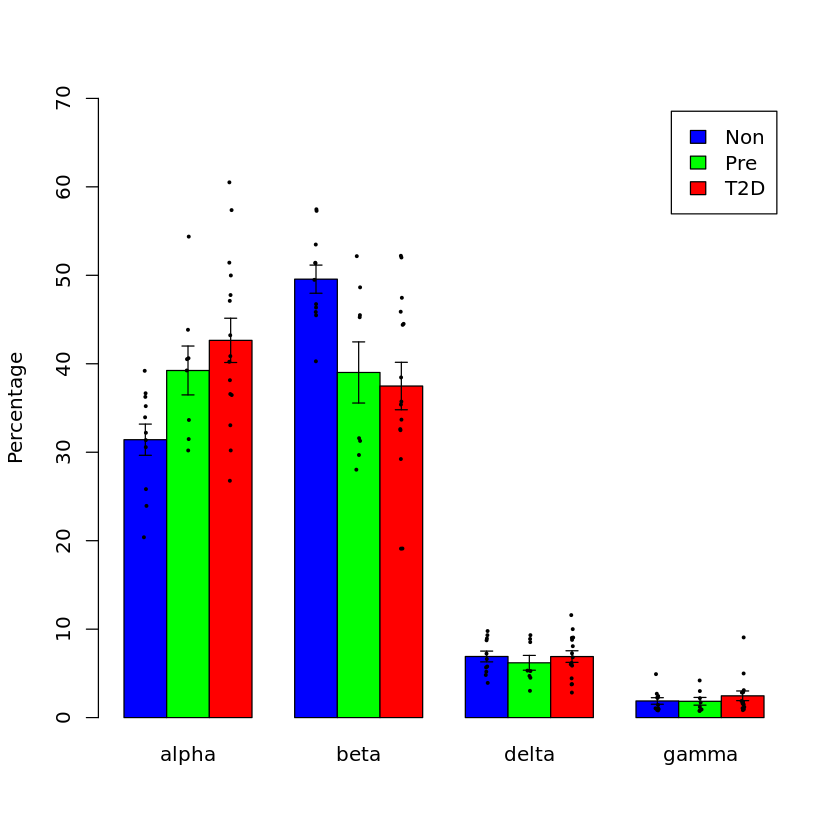

In [32]:
A_ND = A[A$Disease == 'Non',]
A_PD = A[A$Disease == 'Pre',]
A_T2D = A[A$Disease == 'T2D',]

n1 = as.numeric(A_ND$alpha)
n2 = as.numeric(A_PD$alpha)
n3 = as.numeric(A_T2D$alpha)
n4 = as.numeric(A_ND$beta)
n5 = as.numeric(A_PD$beta)
n6 = as.numeric(A_T2D$beta)
n7 = as.numeric(A_ND$delta)
n8 = as.numeric(A_PD$delta)
n9 = as.numeric(A_T2D$delta)
n10 = as.numeric(A_ND$gamma)
n11 = as.numeric(A_PD$gamma)
n12 = as.numeric(A_T2D$gamma)

y = c(n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12)
max(y)

x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3)), 
      rep(5.5,length(n4)),rep(6.5,length(n5)),rep(7.5,length(n6)),
      rep(9.5,length(n7)),rep(10.5,length(n8)),rep(11.5,length(n9)),
      rep(13.5,length(n10)),rep(14.5,length(n11)),rep(15.5,length(n12))) 
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean[,c(1:4)], beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","green",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:4)], stdev[,c(1:4)])
points(x,y,bg = 'grey',pch=19,cex=0.3)

In [33]:
alpha_cell <- aov(alpha ~ Disease + age + islet.index + gender + BMI, data = A)
summary(alpha_cell)

            Df Sum Sq Mean Sq F value Pr(>F)   
Disease      2  811.6   405.8   5.860 0.0077 **
age          1    2.7     2.7   0.039 0.8445   
islet.index  1  117.6   117.6   1.698 0.2035   
gender       1   68.9    68.9   0.995 0.3273   
BMI          1   27.5    27.5   0.398 0.5336   
Residuals   27 1869.6    69.2                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [34]:
beta_cell <- aov(beta ~ Disease + age + islet.index + gender + BMI, data = A)
summary(beta_cell)

            Df Sum Sq Mean Sq F value  Pr(>F)   
Disease      2 1004.4   502.2   6.169 0.00622 **
age          1   11.4    11.4   0.140 0.71130   
islet.index  1  212.2   212.2   2.606 0.11807   
gender       1   12.0    12.0   0.147 0.70434   
BMI          1   25.1    25.1   0.308 0.58362   
Residuals   27 2198.1    81.4                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [35]:
delta_cell <- aov(delta ~ Disease + age + islet.index + gender + BMI, data = A)
summary(delta_cell)

            Df Sum Sq Mean Sq F value Pr(>F)  
Disease      2   3.08   1.538   0.281 0.7575  
age          1   0.06   0.055   0.010 0.9209  
islet.index  1  21.60  21.603   3.943 0.0573 .
gender       1   0.01   0.013   0.002 0.9622  
BMI          1   0.78   0.781   0.142 0.7088  
Residuals   27 147.94   5.479                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [36]:
gamma_cell <- aov(gamma ~ Disease + age + islet.index + gender + BMI, data = A)
summary(gamma_cell)

            Df Sum Sq Mean Sq F value Pr(>F)
Disease      2   3.02   1.510   0.516  0.603
age          1   0.12   0.118   0.040  0.843
islet.index  1   6.53   6.533   2.230  0.147
gender       1   2.86   2.864   0.978  0.332
BMI          1   0.08   0.077   0.026  0.872
Residuals   27  79.09   2.929               

# Principal component analysis of cell type-specific pseudo-bulk ATAC profile (S Figure 2)

## Beta cell

In [37]:
## PCA plots for beta cell
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

# beta cell open cCREs
name_1=paste0(wd_snATAC,'beta_peak_macs2_q0.05.bed')
C1=read.table(name_1,sep='\t')
peak_c1=unique(as.character(C1$V4))

## beta cell bulk count matrix
name_c3=paste0(wd_snATAC,'beta_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3
keep=(peak_all_c3 %in% peak_c1)
C3_final=C3_matrix[keep,]

## count normalization (CPM)
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)
for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}
A_raw=C3_final

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[order(C$donor),]
all(C$donor==colnames(A_norm))

pca <- prcomp(t(A_norm), scale. = TRUE)
pc_pos=pca$x


[1] TRUE

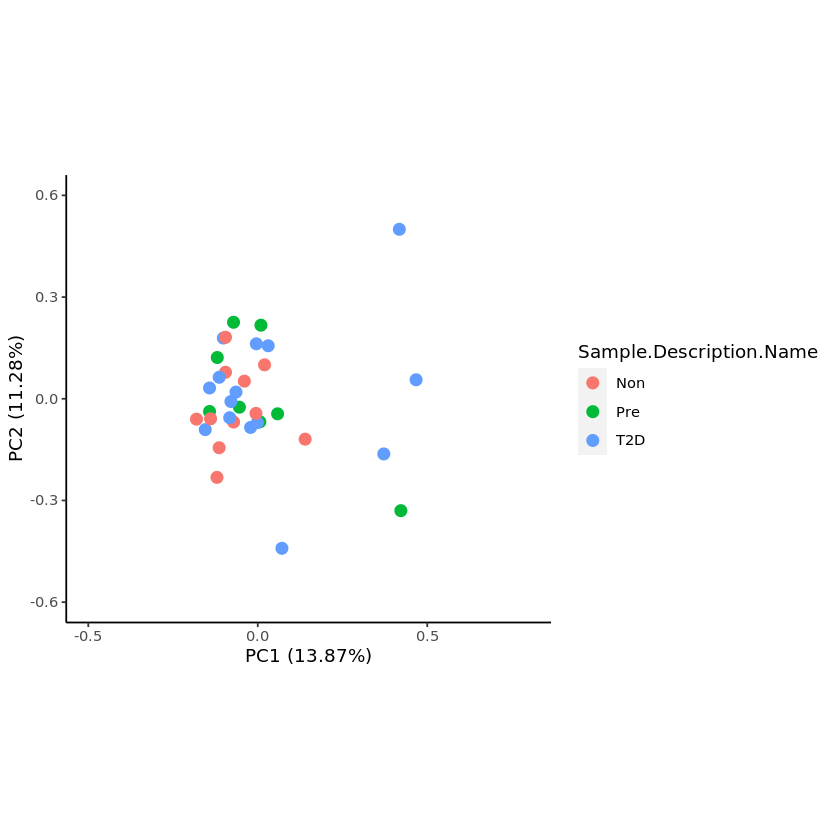

In [38]:
donor_race=as.character(C$Race)
donor_race[donor_race=='Caucasian']='Caucasian_White'
donor_race[donor_race=='White']='Caucasian_White'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Hispanic Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic/Latino']='Hispanic_Latino'
C$Race=donor_race

p1 <- autoplot(pca,    
         data=C,
         colour = 'Sample.Description.Name',size=3,
         x = 1,    # PC2
         y = 2) + scale_size_continuous(range = c(1,3))+ xlim(c(-0.5,0.8)) + ylim(-0.6, 0.6) + coord_fixed()

p1 + ggplot2::theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))

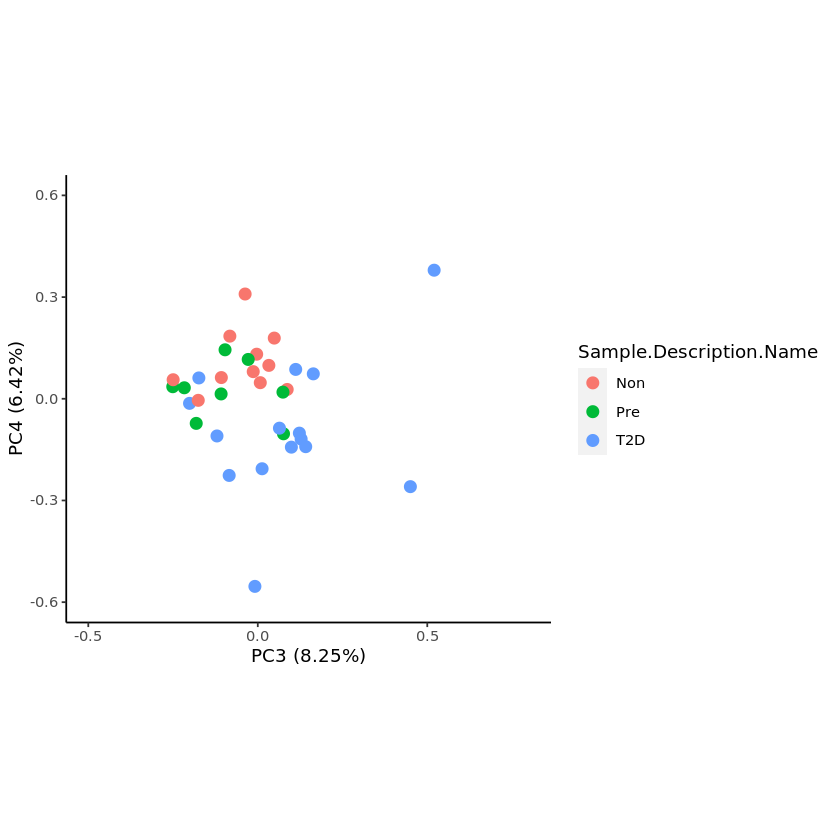

In [39]:
pca <- prcomp(t(A_norm), scale. = TRUE)
pc_pos=pca$x

p1 <- autoplot(pca, 
         data=C,
         colour = 'Sample.Description.Name',size=3,
         x = 3,
         y = 4) + scale_size_continuous(range = c(1,3))+ xlim(c(-0.5,0.8)) + ylim(-0.6, 0.6) + coord_fixed()

p1 + ggplot2::theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))

[1] "Caucasian_White"           "Hispanic_Latino"          
[3] "Black or African American"

[1] TRUE

[1] TRUE

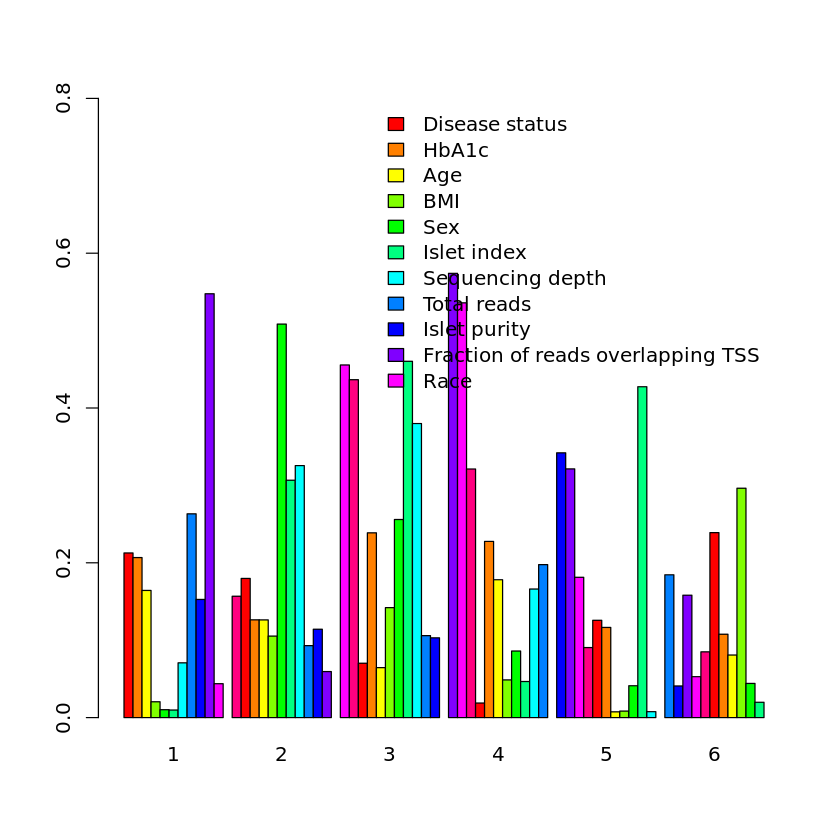

In [40]:
pos=pca$x
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
donor_race=as.character(C$Race)
donor_race[donor_race=='Caucasian']='Caucasian_White'
donor_race[donor_race=='White']='Caucasian_White'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Hispanic Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic/Latino']='Hispanic_Latino'
unique(donor_race)
C$Race=donor_race

C=C[order(C$donor),]
all(rownames(pos)==as.character(C$donor))

C1=C[,c(1,3,5,7:13,15,17:20,23:29)]
temp=C1$Sample.Description.Name
temp1=rep(0,length(temp))
temp1[temp=='Non']=0
temp1[temp=='Pre']=1
temp1[temp=='T2D']=2
C1$disease1=temp1

temp1=rep(0,length(temp))
temp1[temp=='Non']=0
temp1[temp=='Pre']=2
temp1[temp=='T2D']=1
C1$disease2=temp1

temp1=rep(0,length(temp))
temp1[temp=='Non']=1
temp1[temp=='Pre']=0
temp1[temp=='T2D']=2
C1$disease3=temp1

temp=C1$Freezing.storage.method
temp1=rep(0,length(temp))
temp1[temp=='snap frozen']=1
temp1[temp=='Dry ice frozen']=0
C1$method1=temp1

temp=C1$Gender
temp1=rep(0,length(temp))
temp1[temp=='M']=1
temp1[temp=='F']=0
C1$Gender1=temp1

temp=C1$Center
temp1=rep(0,length(temp))
temp1[temp=='CH']=1
temp1[temp!='CH']=0
C1$Center1=temp1

temp=C1$Race
temp1=rep(0,length(temp))
temp1[temp=='Caucasian_White']=1
temp1[temp=='Hispanic_Latino']=0
temp1[temp=='Black or African American']=2
C1$race=temp1

C2=C1[,c(1,5,6,9,10,12:29)]
C_matrix=as.matrix(C2[,-1])
rownames(C_matrix)=as.character(C2$donor)


all(rownames(C_matrix)==colnames(A_norm))
total_count1=colSums(C3_matrix)
C_matrix=cbind(C_matrix,total_count1)

R=matrix(0,10,dim(C_matrix)[2])
colnames(R)=colnames(C_matrix)
rownames(R)=c(1:10)
for (i in 1:dim(R)[1]){
    for (j in 1:dim(R)[2]){
        temp_i=pos[,i]
        temp_j=C_matrix[,j]
        R[i,j]=cor(temp_i,temp_j,method="spearman")
    }
}

R1=R[1:6,c(1:5,9:10,19:20,22:23)]
R_temp=abs(R[1:6,16:18])
disease=apply(R_temp,1,max)
R2=cbind(R1,disease)

colnames(R2)=c('Islet index','Age', 'BMI','HbA1c','Sequencing depth','Islet purity','Fraction of reads overlapping TSS','Method','Sex','Race','Total reads','Disease status')
R3=R2[,c(12,4,2,3,9,1,5,11,6,7,10)]
#R3=R2

name_var <- colnames(R3)
barplot(abs(t(R3)), beside = T, legend.text=TRUE,col=rainbow(dim(R2)[2]),ylim=c(0,0.8),args.legend = list(x = "topright", bty = "n"))


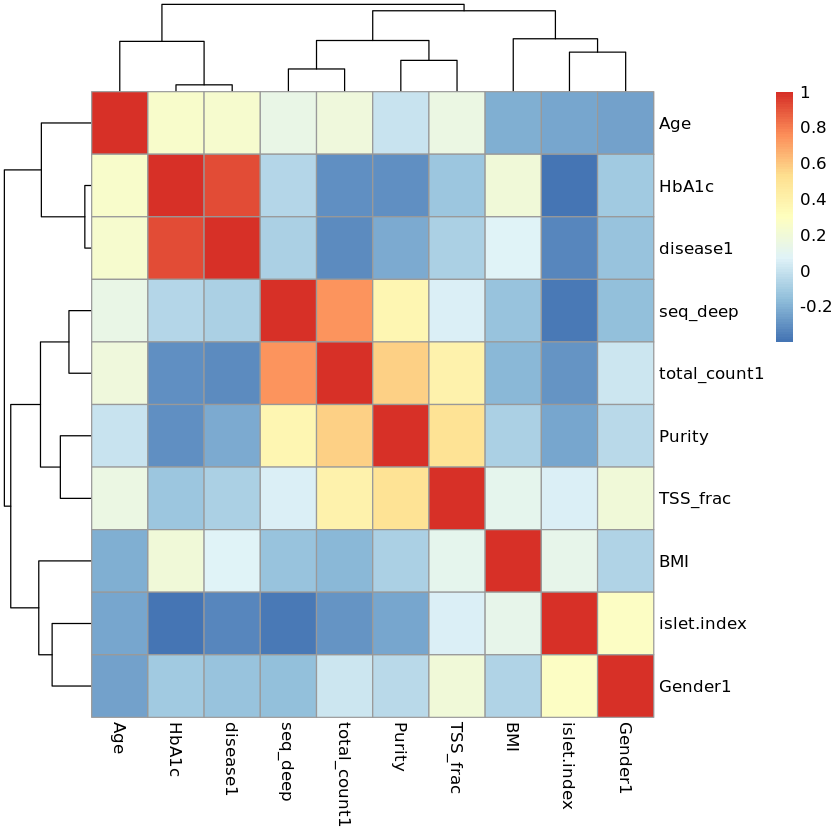

In [41]:
V=matrix(0,dim(C_matrix)[2],dim(C_matrix)[2])
colnames(V)=colnames(C_matrix)
rownames(V)=colnames(C_matrix)
for (i in 1:dim(V)[1]){
    for (j in 1:dim(V)[2]){
        temp_i=C_matrix[,i]
        temp_j=C_matrix[,j]
        V[i,j]=cor(temp_i,temp_j,method="spearman")
    }
}

keep=c(1:5,9,10,20,23,16)
V1=V[keep,keep]
pheatmap(V1)

## Alpha cell

In [42]:
## PCA plots for alpha cell
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

# beta cell open cCREs
name_1=paste0(wd_snATAC,'alpha_peak_macs2_q0.05.bed')
C1=read.table(name_1,sep='\t')
peak_c1=unique(as.character(C1$V4))

name_c3 = paste0(wd_snATAC,'alpha_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3
keep=(peak_all_c3 %in% peak_c1)
C3_final=C3_matrix[keep,]

## count normalization (CPM)
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)
for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}
A_raw=C3_final

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[order(C$donor),]
all(C$donor==colnames(A_norm))

pca <- prcomp(t(A_norm), scale. = TRUE)
pc_pos=pca$x

[1] TRUE

Warning message:
“Removed 1 rows containing missing values (geom_point).”

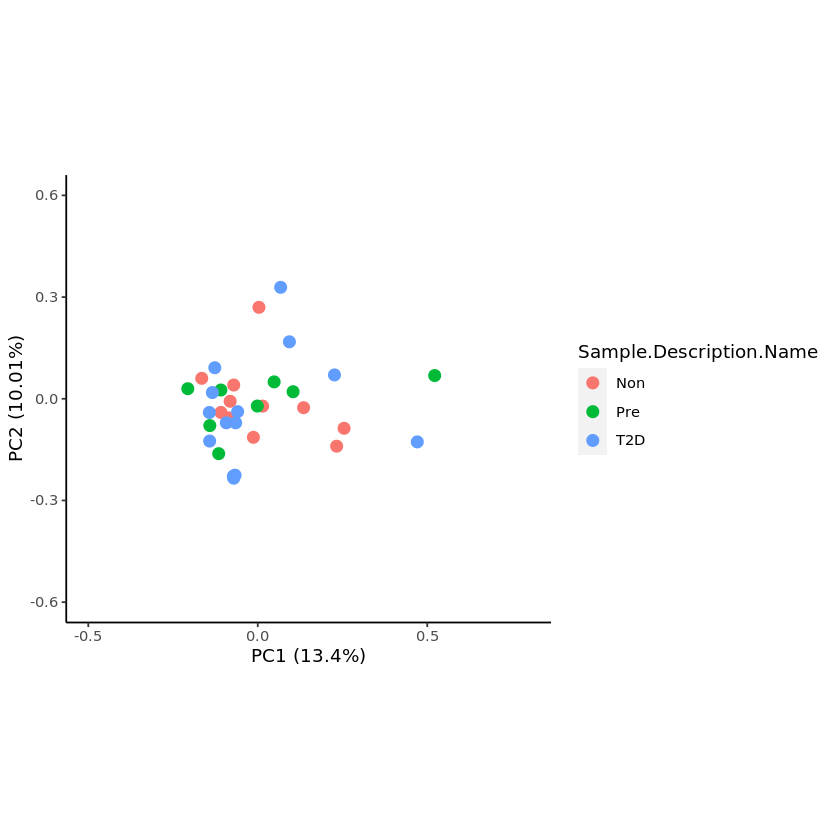

In [43]:
donor_race=as.character(C$Race)
donor_race[donor_race=='Caucasian']='Caucasian_White'
donor_race[donor_race=='White']='Caucasian_White'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Hispanic Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic/Latino']='Hispanic_Latino'
C$Race=donor_race

p1 <- autoplot(pca,    
         data=C,
         colour = 'Sample.Description.Name',size=3,
         x = 1,    # PC2
         y = 2) + scale_size_continuous(range = c(1,3))+ xlim(c(-0.5,0.8)) + ylim(-0.6, 0.6) + coord_fixed()

p1 + ggplot2::theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))

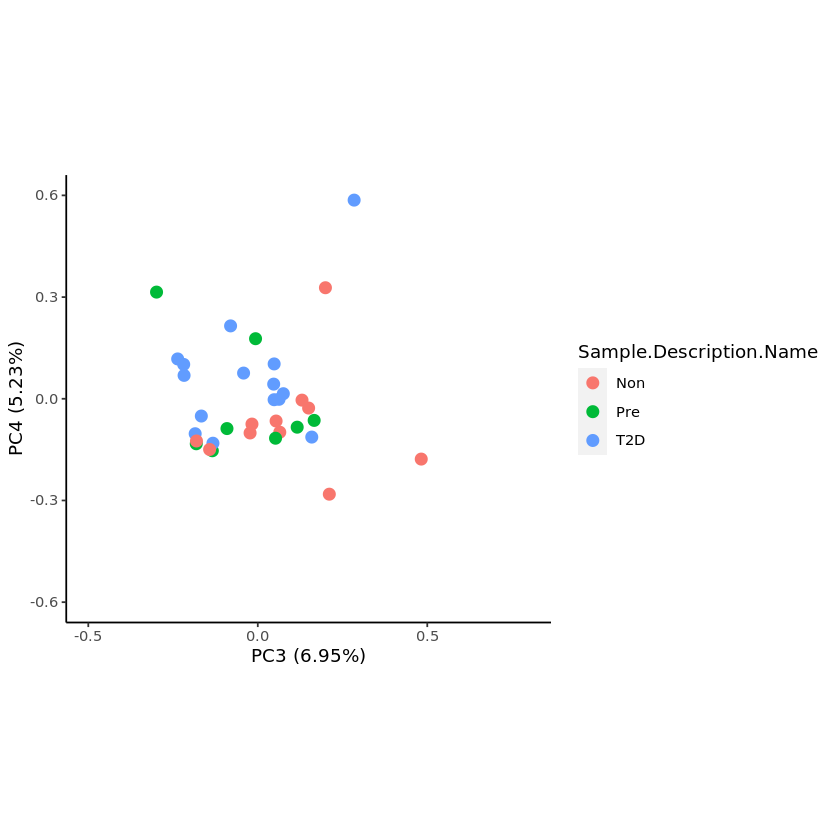

In [44]:
p1 <- autoplot(pca, 
         data=C,
         colour = 'Sample.Description.Name',size=3,
         x = 3,
         y = 4) + scale_size_continuous(range = c(1,3))+ xlim(c(-0.5,0.8)) + ylim(-0.6, 0.6) + coord_fixed()

p1 + ggplot2::theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))

[1] "Caucasian_White"           "Hispanic_Latino"          
[3] "Black or African American"

[1] TRUE

[1] TRUE

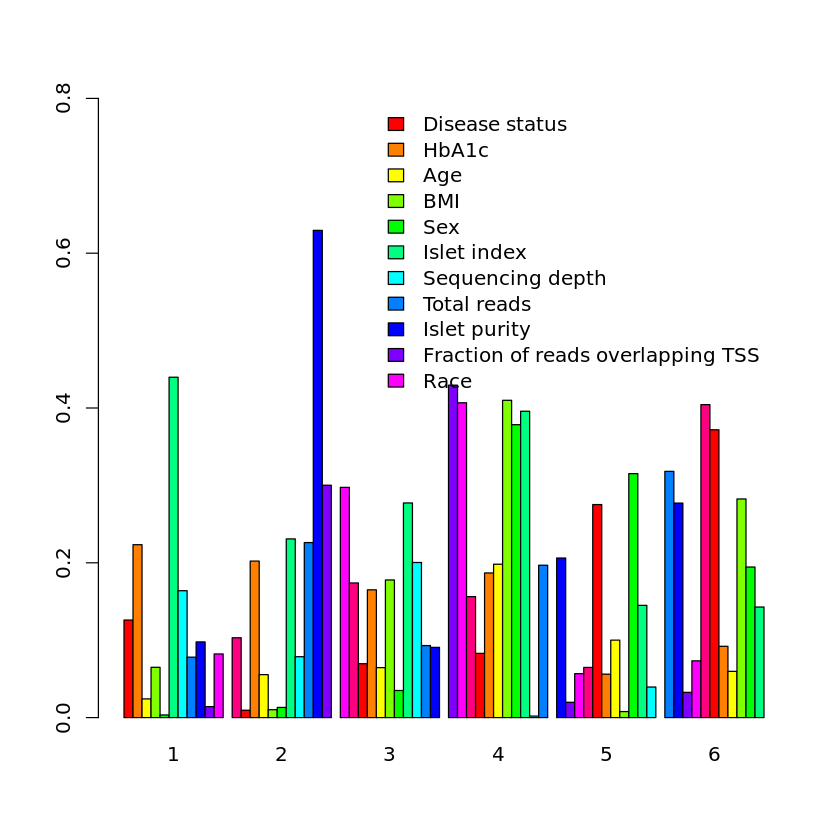

In [45]:
pos=pca$x
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
donor_race=as.character(C$Race)
donor_race[donor_race=='Caucasian']='Caucasian_White'
donor_race[donor_race=='White']='Caucasian_White'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Hispanic Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic/Latino']='Hispanic_Latino'
unique(donor_race)
C$Race=donor_race

C=C[order(C$donor),]
all(rownames(pos)==as.character(C$donor))

C1=C[,c(1,3,5,7:13,15,17:20,23:29)]
temp=C1$Sample.Description.Name
temp1=rep(0,length(temp))
temp1[temp=='Non']=0
temp1[temp=='Pre']=1
temp1[temp=='T2D']=2
C1$disease1=temp1

temp1=rep(0,length(temp))
temp1[temp=='Non']=0
temp1[temp=='Pre']=2
temp1[temp=='T2D']=1
C1$disease2=temp1

temp1=rep(0,length(temp))
temp1[temp=='Non']=1
temp1[temp=='Pre']=0
temp1[temp=='T2D']=2
C1$disease3=temp1

temp=C1$Freezing.storage.method
temp1=rep(0,length(temp))
temp1[temp=='snap frozen']=1
temp1[temp=='Dry ice frozen']=0
C1$method1=temp1

temp=C1$Gender
temp1=rep(0,length(temp))
temp1[temp=='M']=1
temp1[temp=='F']=0
C1$Gender1=temp1

temp=C1$Center
temp1=rep(0,length(temp))
temp1[temp=='CH']=1
temp1[temp!='CH']=0
C1$Center1=temp1

temp=C1$Race
temp1=rep(0,length(temp))
temp1[temp=='Caucasian_White']=1
temp1[temp=='Hispanic_Latino']=0
temp1[temp=='Black or African American']=2
C1$race=temp1

C2=C1[,c(1,5,6,9,10,12:29)]
C_matrix=as.matrix(C2[,-1])
rownames(C_matrix)=as.character(C2$donor)


all(rownames(C_matrix)==colnames(A_norm))
total_count1=colSums(C3_matrix)
C_matrix=cbind(C_matrix,total_count1)

R=matrix(0,10,dim(C_matrix)[2])
colnames(R)=colnames(C_matrix)
rownames(R)=c(1:10)
for (i in 1:dim(R)[1]){
    for (j in 1:dim(R)[2]){
        temp_i=pos[,i]
        temp_j=C_matrix[,j]
        R[i,j]=cor(temp_i,temp_j,method="spearman")
    }
}

R1=R[1:6,c(1:5,9:10,19:20,22:23)]
R_temp=abs(R[1:6,16:18])
disease=apply(R_temp,1,max)
R2=cbind(R1,disease)

colnames(R2)=c('Islet index','Age', 'BMI','HbA1c','Sequencing depth','Islet purity','Fraction of reads overlapping TSS','Method','Sex','Race','Total reads','Disease status')
R3=R2[,c(12,4,2,3,9,1,5,11,6,7,10)]
#R3=R2

name_var <- colnames(R3)
barplot(abs(t(R3)), beside = T, legend.text=TRUE,col=rainbow(dim(R2)[2]),ylim=c(0,0.8),args.legend = list(x = "topright", bty = "n"))

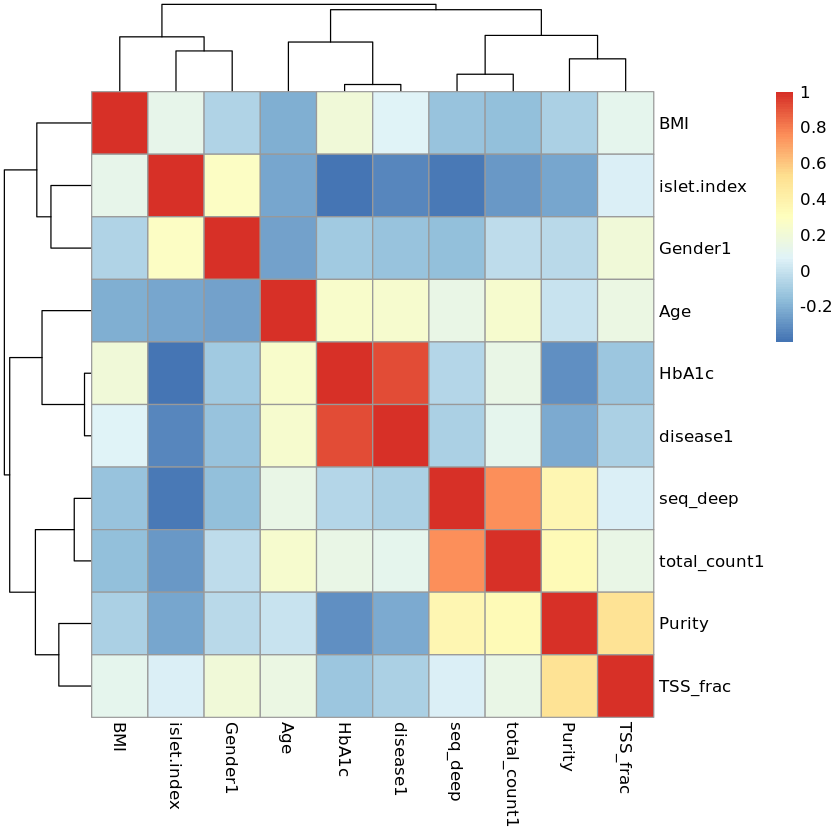

In [46]:
V=matrix(0,dim(C_matrix)[2],dim(C_matrix)[2])
colnames(V)=colnames(C_matrix)
rownames(V)=colnames(C_matrix)
for (i in 1:dim(V)[1]){
    for (j in 1:dim(V)[2]){
        temp_i=C_matrix[,i]
        temp_j=C_matrix[,j]
        V[i,j]=cor(temp_i,temp_j,method="spearman")
    }
}

keep=c(1:5,9,10,20,23,16)
V1=V[keep,keep]
pheatmap(V1)

# Beta cell differential cCREs (pseudo-bulk analysis) in Figure 1

In [47]:
## beta cell as an example
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

# beta cell open cCREs
name_1=paste0(wd_snATAC,'beta_peak_macs2_q0.05.bed')
C1=read.table(name_1,sep='\t')
peak_c1=unique(as.character(C1$V4))

## beta cell bulk count matrix
name_c3=paste0(wd_snATAC,'beta_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3
keep=(rownames(C3_matrix) %in% peak_c1)
A_raw=C3_matrix[keep,]

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
donor_race=as.character(C$Race)
donor_race[donor_race=='Caucasian']='Caucasian_White'
donor_race[donor_race=='White']='Caucasian_White'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic']='Hispanic_Latino'
donor_race[donor_race=='Hispanic Latino']='Hispanic_Latino'
donor_race[donor_race=='Hispanic/Latino']='Hispanic_Latino'
C$Race=donor_race

C=C[order(C$donor),]
C$total_count=(colSums(A_raw)/100000)
all(as.character(C$donor) == colnames(A_raw))

[1] TRUE

In [31]:
### call differential cCRES using age, BMI, gender, TSS_frac, islet index, total count as covariants
dds <- DESeqDataSetFromMatrix(countData = A_raw,
                              colData = C,
                              design= ~ Age + BMI + Gender + TSS_frac + islet.index + total_count + Sample.Description.Name)

dds$Sample.Description.Name <- relevel(dds$Sample.Description.Name, ref = "Non")

library("BiocParallel")
register(MulticoreParam(4))
dds <- DESeq(dds,parallel=TRUE)

resultsNames(dds)

converting counts to integer mode
  the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 4 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 4 workers


[1] "Intercept"                          "Age"                               
[3] "BMI"                                "Gender_M_vs_F"                     
[5] "TSS_frac"                           "islet.index"                       
[7] "total_count"                        "Sample.Description.Name_Pre_vs_Non"
[9] "Sample.Description.Name_T2D_vs_Non"

## Differential cCREs (FDR<0.1) between T2D and Non

In [32]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'/oasis/tscc/scratch/gaw006/snATACseq/processed/beta_T2D_Non_full.csv')


[1] 3097

[1] 3614

## Differential cCREs (FDR<0.1) between pre-T2D and Non

In [33]:
res <- results(dds,contrast=c("Sample.Description.Name", "Pre", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'/oasis/tscc/scratch/gaw006/snATACseq/processed/beta_Pre_Non_full.csv')


[1] 0

[1] 0

## Differential cCREs (FDR<0.1) between T2D and pre-T2D

In [34]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Pre"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'/oasis/tscc/scratch/gaw006/snATACseq/processed/beta_T2D_Pre_full.csv')

[1] 61

[1] 98

## Differential cCREs (FDR<0.1) in terms of age

In [35]:
res <- results(dds,name="Age")
temp=res$padj
stat=res$stat
temp[is.na(temp)]=10
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])

[1] 154

[1] 147

## Differential cCREs (FDR<0.1) in terms of BMI

In [36]:
res <- results(dds,name="BMI")
temp=res$padj
stat=res$stat
temp[is.na(temp)]=10
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])

[1] 0

[1] 0

## Differential cCREs (FDR<0.1) between male and female

In [37]:
res <- results(dds,name="Gender_M_vs_F")
temp=res$padj
stat=res$stat
temp[is.na(temp)]=10
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])

[1] 37

[1] 89

In [48]:
## beta cell differential cCREs
A_TN=read.csv(paste0(wd_snATAC,'beta_T2D_Non_full.csv')) ##
A_TP=read.csv(paste0(wd_snATAC,'beta_T2D_Pre_full.csv')) ##
A_PN=read.csv(paste0(wd_snATAC,'beta_Pre_Non_full.csv')) ##
all(rownames(A_TN)==rownames(A_TP))

A1=A_PN
colnames(A1)=c('X','baseMean','log2FC_PN','lfcSE_PN','stat_PN','pvalue_PN','padj_PN')
A2=A_TP[,c(3:7)]
colnames(A2)=c('log2FC_TP','lfcSE_TP','stat_TP','pvalue_TP','padj_TP')
A3=A_TN[,c(3:7)]
colnames(A3)=c('log2FC_TN','lfcSE_TN','stat_TN','pvalue_TN','padj_TN')
tt=cbind(A1,A2)
A=cbind(tt,A3)


A[is.na(A)]=10
peak_all=as.character(A$X)
peak_TNup_biobank=peak_all[A$stat_TN>0 & A$padj_TN<0.1]
peak_TNdown_biobank=peak_all[A$stat_TN<0 & A$padj_TN<0.1]
peak_PNup_biobank=peak_all[A$stat_PN>0 & A$padj_PN<0.1]
peak_PNdown_biobank=peak_all[A$stat_PN<0 & A$padj_PN<0.1]
peak_TPup_biobank=peak_all[A$stat_TP>0 & A$padj_TP<0.1]
peak_TPdown_biobank=peak_all[A$stat_TP<0 & A$padj_TP<0.1]


length(peak_PNup_biobank)
length(peak_PNdown_biobank)
length(peak_TPup_biobank)
length(peak_TPdown_biobank)
length(peak_TNup_biobank)
length(peak_TNdown_biobank)


[1] TRUE

[1] 0

[1] 0

[1] 61

[1] 98

[1] 3097

[1] 3614

[1] TRUE

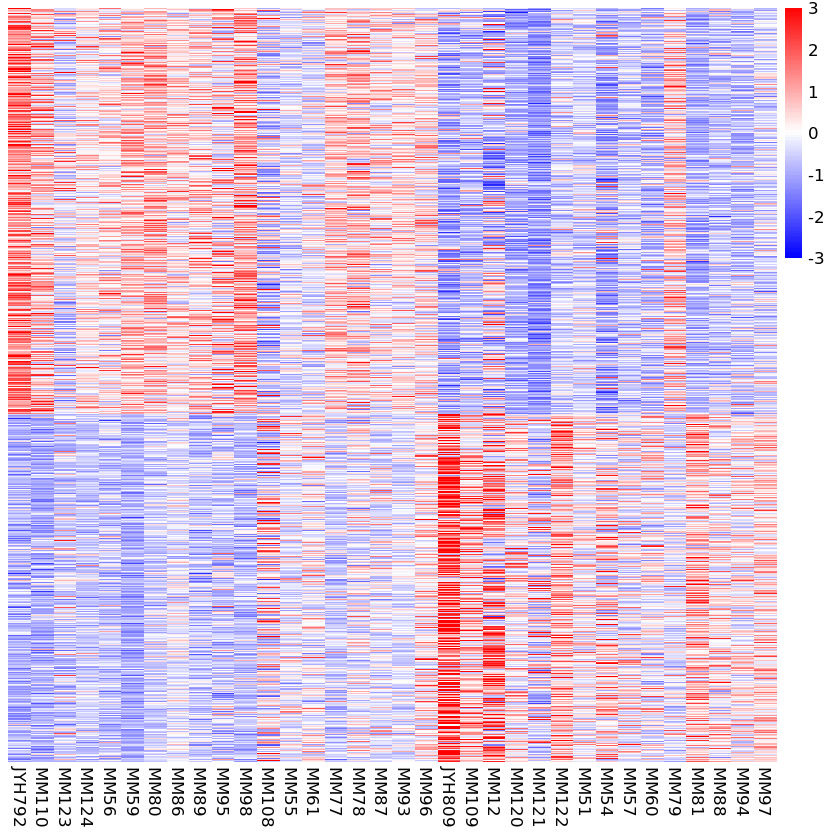

In [49]:
A_biobank=read.csv(paste0(wd_snATAC,'beta_500_all_b.csv'))
A_biobank_peak=as.character(A_biobank$index)
colnames(A_biobank)[1]='X'

#A=merge(A_biobank,A_HPAP,by='X',all=FALSE)
A=A_biobank
A_matrix=as.matrix(A[,-1])
rownames(A_matrix)=as.character(A$X)

# beta cell open cCREs
P=read.table(paste0(wd_snATAC,'beta_peak_macs2_q0.05.bed'),sep='\t')
peak_c1=unique(as.character(P$V4))

keep=(rownames(A_matrix) %in% peak_c1)
C3_final=A_matrix[keep,]

## count normalization (CPM)
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)
for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[C$donor %in% colnames(A_norm),]
C=C[order(C$donor),]
A_norm=A_norm[,order(colnames(A_norm))]
all(as.character(C$donor)==colnames(A_norm))

A_norm1=A_norm[,order(C$Sample.Description.Name)]
A_down=A_norm1[(rownames(A_norm1) %in% peak_TNdown_biobank),]
A_up=A_norm1[(rownames(A_norm1) %in% peak_TNup_biobank),]
A_diff=rbind(A_down,A_up)

bk = unique(c(seq(-3,3, length=100)))
pheatmap(A_diff,scale='row',breaks=bk,color = colorRampPalette(colors = c("blue",'white',"red"))(100),show_rownames = F,cluster_cols=FALSE,cluster_rows=FALSE)


## Validation of beta cell differential cCREs using independent snATAC-seq dataset (S Figure 3)

In [50]:
## beta cell differential cCREs
A_TN=read.csv(paste0(wd_snATAC,'beta_T2D_Non_full.csv')) ##
A_TP=read.csv(paste0(wd_snATAC,'beta_T2D_Pre_full.csv')) ##
A_PN=read.csv(paste0(wd_snATAC,'beta_Pre_Non_full.csv')) ##
all(rownames(A_TN)==rownames(A_TP))

A1=A_PN
colnames(A1)=c('X','baseMean','log2FC_PN','lfcSE_PN','stat_PN','pvalue_PN','padj_PN')
A2=A_TP[,c(3:7)]
colnames(A2)=c('log2FC_TP','lfcSE_TP','stat_TP','pvalue_TP','padj_TP')
A3=A_TN[,c(3:7)]
colnames(A3)=c('log2FC_TN','lfcSE_TN','stat_TN','pvalue_TN','padj_TN')
tt=cbind(A1,A2)
A=cbind(tt,A3)


A[is.na(A)]=10
peak_all=as.character(A$X)
peak_TNup_biobank=peak_all[A$stat_TN>0 & A$padj_TN<0.1]
peak_TNdown_biobank=peak_all[A$stat_TN<0 & A$padj_TN<0.1]
peak_PNup_biobank=peak_all[A$stat_PN>0 & A$padj_PN<0.1]
peak_PNdown_biobank=peak_all[A$stat_PN<0 & A$padj_PN<0.1]
peak_TPup_biobank=peak_all[A$stat_TP>0 & A$padj_TP<0.1]
peak_TPdown_biobank=peak_all[A$stat_TP<0 & A$padj_TP<0.1]


length(peak_PNup_biobank)
length(peak_PNdown_biobank)
length(peak_TPup_biobank)
length(peak_TPdown_biobank)
length(peak_TNup_biobank)
length(peak_TNdown_biobank)

[1] TRUE

[1] 0

[1] 0

[1] 61

[1] 98

[1] 3097

[1] 3614

[1] TRUE

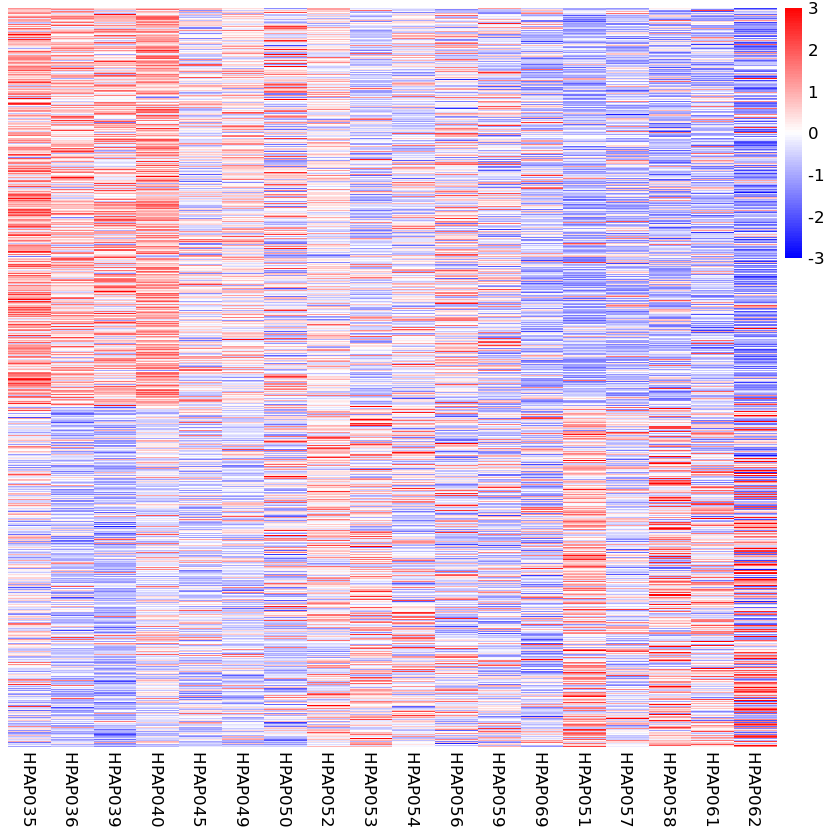

In [51]:
A_HPAP=read.csv(paste0(wd_snATAC,'HPAP_beta_500bp.csv'))
### remove 3 donors with low quality (<100 cells): HPAP042,HPAP044,HPAP047
### remove 2 pre-T2D donors accoding to the classification criterion: HPAP063,HPAP067
A_HPAP=A_HPAP[,!(colnames(A_HPAP) %in% c('HPAP042','HPAP044','HPAP047','HPAP063','HPAP067'))] 
### remove 3 donors with low quality (<100 cells)
A_HPAP_peak=as.character(A_HPAP$X)

A=A_HPAP
A_matrix=as.matrix(A[,-1])
rownames(A_matrix)=as.character(A$X)

# beta cell open cCREs
P=read.table(paste0(wd_snATAC,'beta_peak_macs2_q0.05.bed'),sep='\t')
peak_c1=unique(as.character(P$V4))

keep=(rownames(A_matrix) %in% peak_c1)
C3_final=A_matrix[keep,]

## count normalization (CPM)
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)
for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}

## metadata of donors
C=read.csv(paste0(wd_snATAC,'final_meta_all.csv'))
C=C[C$donor %in% colnames(A_norm),]
C=C[order(C$donor),]
A_norm=A_norm[,order(colnames(A_norm))]
all(as.character(C$donor)==colnames(A_norm))

A_norm1=A_norm[,order(C$Sample.Description.Name)]
A_down=A_norm1[(rownames(A_norm1) %in% peak_TNdown_biobank),]
A_up=A_norm1[(rownames(A_norm1) %in% peak_TNup_biobank),]
A_diff=rbind(A_down,A_up)

bk = unique(c(seq(-3,3, length=100)))
pheatmap(A_diff,scale='row',breaks=bk,color = colorRampPalette(colors = c("blue",'white',"red"))(100),show_rownames = F,cluster_cols=FALSE,cluster_rows=FALSE)


## Differential cCREs from Down-sampling analysis

## Beta cell

Warning message:
“Removed 2 rows containing missing values (geom_vline).”

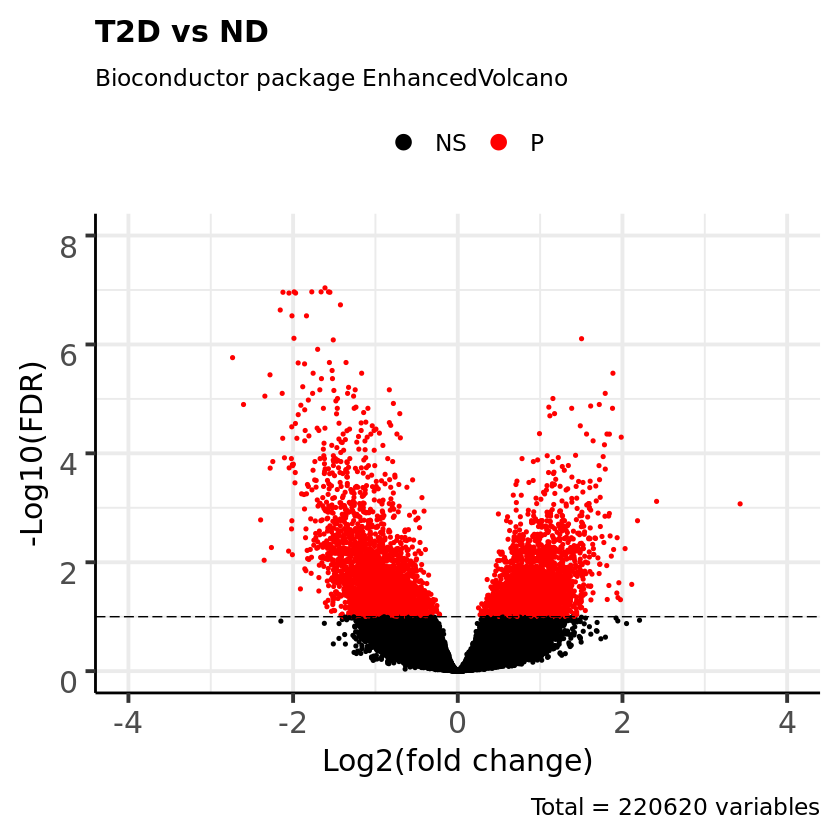

In [52]:
library(EnhancedVolcano)
rm(list = ls()) 

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

res=read.csv(paste0(wd_snATAC,'beta_T2D_Non_full.csv'))
res=res[!is.na(res$padj),]
res$pvalue=res$padj


p1 <- EnhancedVolcano(res,
                      lab = rownames(res),
                      xlab=c('Log2(fold change)'),
                      ylab=c('-Log10(FDR)'),
                      x = 'log2FoldChange',
                      y = 'pvalue',ylim=c(0,8),xlim=c(-4,4),
                      title = 'T2D vs ND',
                      pCutoff = 0.1,
                      FCcutoff = NA,
                      col=c('black', 'red','red','red'),colAlpha = 1)
p1

Warning message:
“Removed 2 rows containing missing values (geom_vline).”

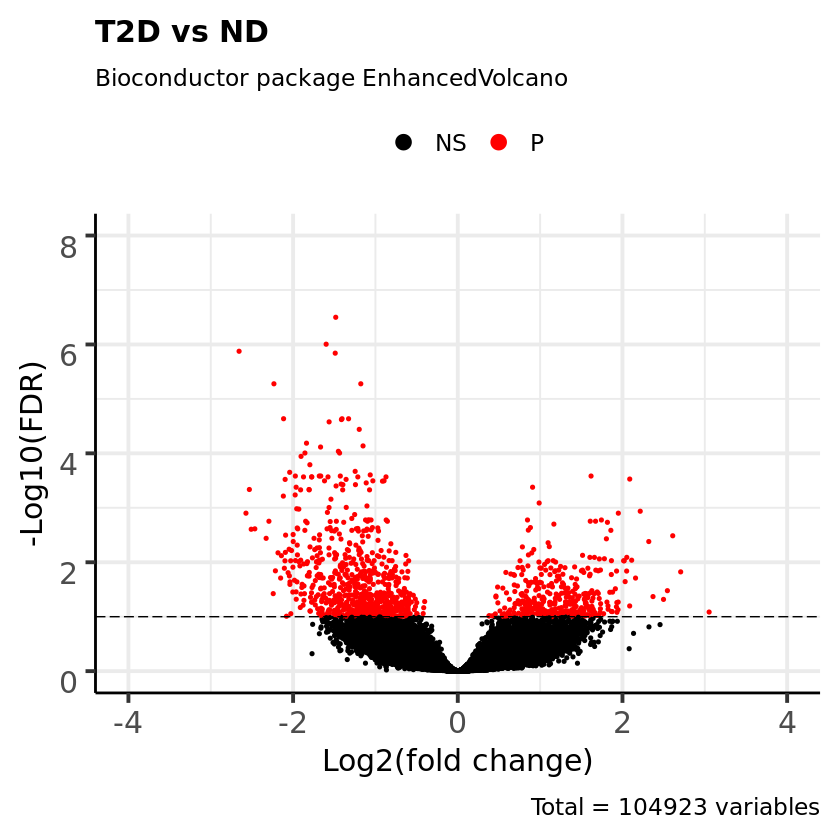

In [53]:
rm(list = ls()) 
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'
res=read.csv(paste0(wd_snATAC,'beta_T2D_Non_15k.csv'))
res=res[!is.na(res$padj),]
res$pvalue=res$padj


p1 <- EnhancedVolcano(res,
                      lab = rownames(res),
                      xlab=c('Log2(fold change)'),
                      ylab=c('-Log10(FDR)'),
                      x = 'log2FoldChange',
                      y = 'pvalue',ylim=c(0,8),xlim=c(-4,4),
                      title = 'T2D vs ND',
                      pCutoff = 0.1,
                      FCcutoff = NA,
                      col=c('black', 'red','red','red'),colAlpha = 1)
p1

Warning message:
“Removed 2 rows containing missing values (geom_vline).”

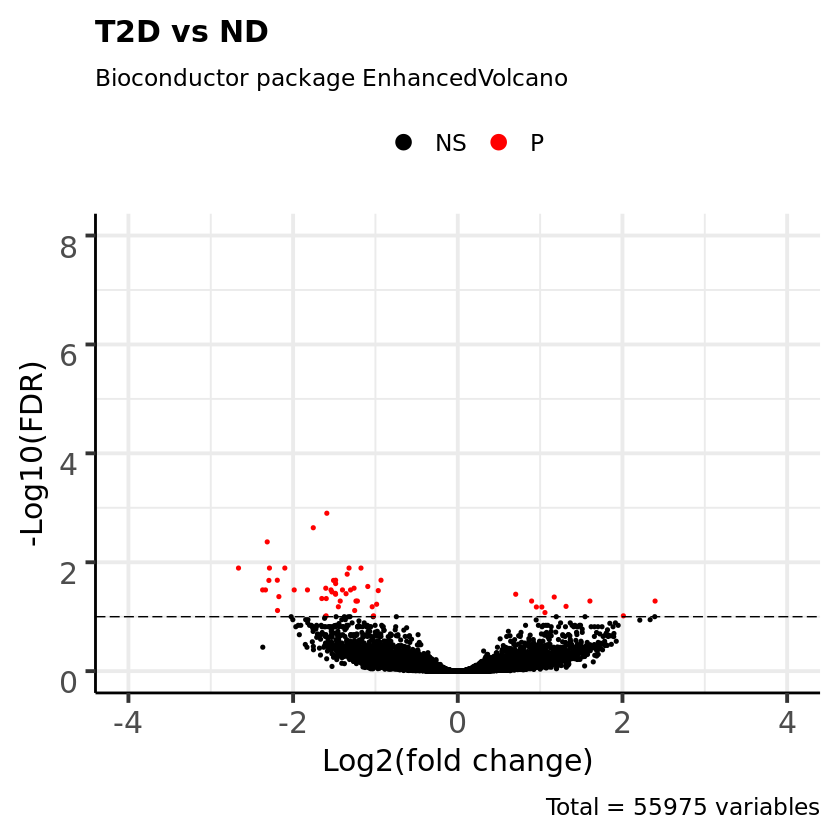

In [54]:
rm(list = ls()) 
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'
res=read.csv(paste0(wd_snATAC,'beta_T2D_Non_5k.csv'))
res=res[!is.na(res$padj),]
res$pvalue=res$padj


p1 <- EnhancedVolcano(res,
                      lab = rownames(res),
                      xlab=c('Log2(fold change)'),
                      ylab=c('-Log10(FDR)'),
                      x = 'log2FoldChange',
                      y = 'pvalue',ylim=c(0,8),xlim=c(-4,4),
                      title = 'T2D vs ND',
                      pCutoff = 0.1,
                      FCcutoff = NA,
                      col=c('black', 'red','red','red'),colAlpha = 1)
p1

## Alpha cell

Warning message:
“Removed 2 rows containing missing values (geom_vline).”

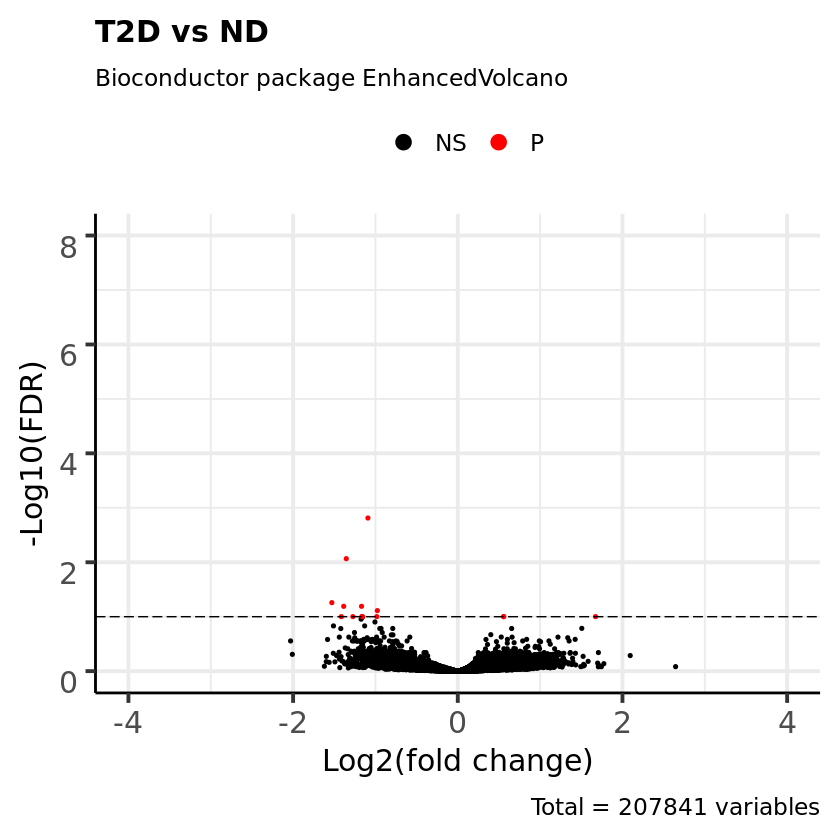

In [55]:
rm(list = ls()) 
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'
res=read.csv(paste0(wd_snATAC,'alpha_T2D_Non_biobank.csv'))
res=res[!is.na(res$padj),]
res$pvalue=res$padj


p1 <- EnhancedVolcano(res,
                      lab = rownames(res),
                      xlab=c('Log2(fold change)'),
                      ylab=c('-Log10(FDR)'),
                      x = 'log2FoldChange',
                      y = 'pvalue',ylim=c(0,8),xlim=c(-4,4),
                      title = 'T2D vs ND',
                      pCutoff = 0.1,
                      FCcutoff = NA,
                      col=c('black', 'red','red','red'),colAlpha = 1)
p1

Warning message:
“Removed 2 rows containing missing values (geom_vline).”

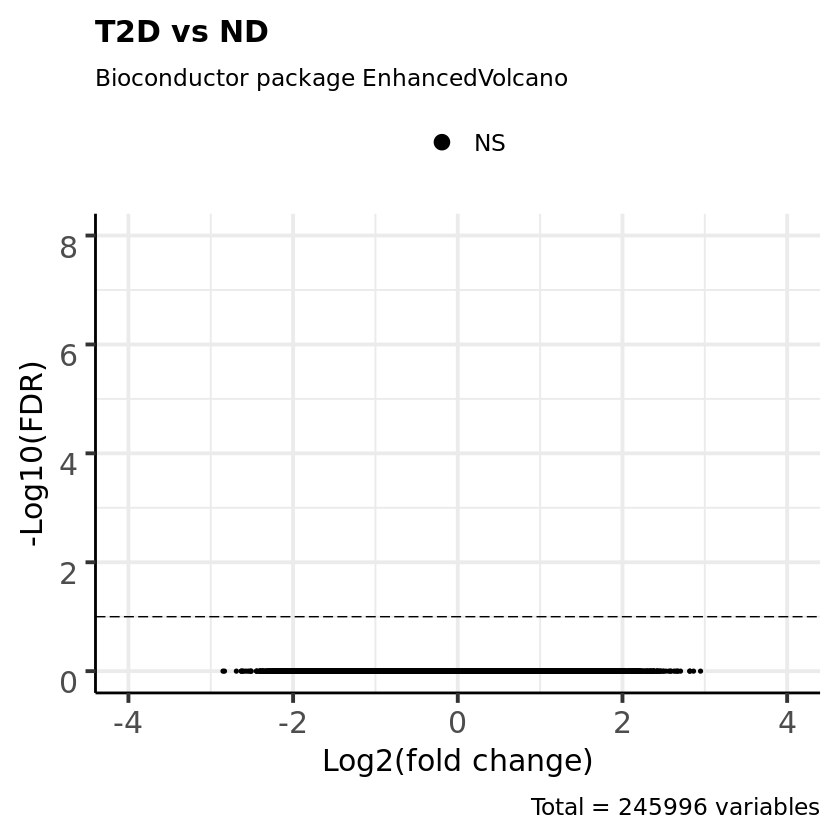

In [56]:
rm(list = ls()) 
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'
res=read.csv(paste0(wd_snATAC,'alpha_T2D_Non_15k.csv'))
res=res[!is.na(res$padj),]
res$pvalue=res$padj

p1 <- EnhancedVolcano(res,
                      lab = rownames(res),
                      xlab=c('Log2(fold change)'),
                      ylab=c('-Log10(FDR)'),
                      x = 'log2FoldChange',
                      y = 'pvalue',ylim=c(0,8),xlim=c(-4,4),
                      title = 'T2D vs ND',
                      pCutoff = 0.1,
                      FCcutoff = NA,
                      col=c('black', 'red','red','red'),colAlpha = 1)
p1

Warning message:
“Removed 2 rows containing missing values (geom_vline).”

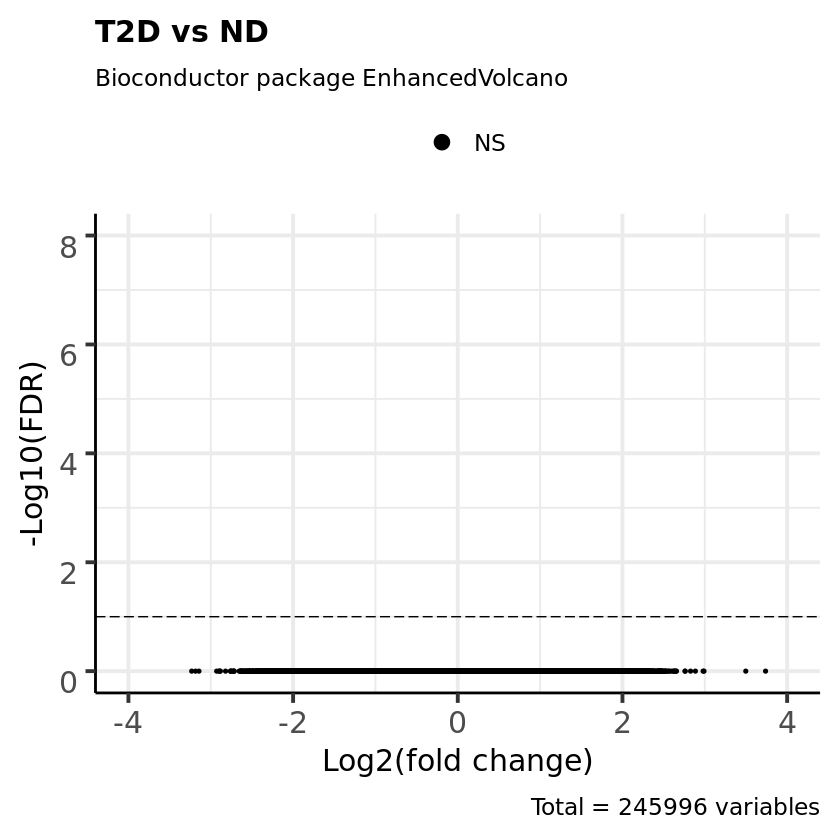

In [57]:
rm(list = ls()) 
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'
res=read.csv(paste0(wd_snATAC,'alpha_T2D_Non_5k.csv'))
res=res[!is.na(res$padj),]
res$pvalue=res$padj


p1 <- EnhancedVolcano(res,
                      lab = rownames(res),
                      xlab=c('Log2(fold change)'),
                      ylab=c('-Log10(FDR)'),
                      x = 'log2FoldChange',
                      y = 'pvalue',ylim=c(0,8),xlim=c(-4,4),
                      title = 'T2D vs ND',
                      pCutoff = 0.1,
                      FCcutoff = NA,
                      col=c('black', 'red','red','red'),colAlpha = 1)
p1

## Delta cell

Warning message:
“Removed 2 rows containing missing values (geom_vline).”

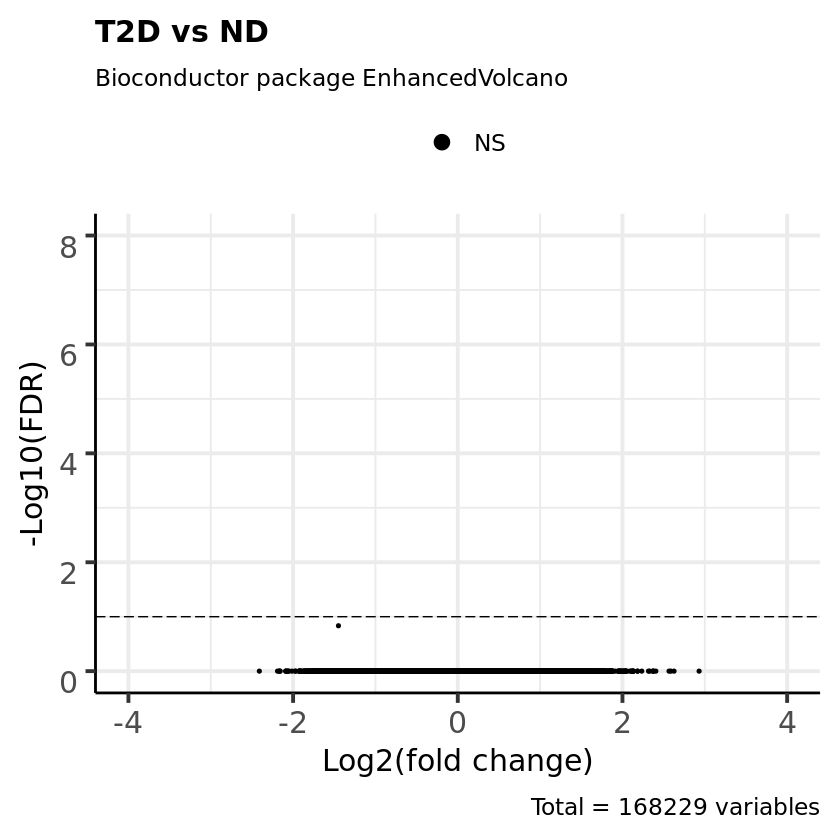

In [58]:
rm(list = ls()) 
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'
res=read.csv(paste0(wd_snATAC,'delta_T2D_Non_biobank.csv'))
res=res[!is.na(res$padj),]
res$pvalue=res$padj


p1 <- EnhancedVolcano(res,
                      lab = rownames(res),
                      xlab=c('Log2(fold change)'),
                      ylab=c('-Log10(FDR)'),
                      x = 'log2FoldChange',
                      y = 'pvalue',ylim=c(0,8),xlim=c(-4,4),
                      title = 'T2D vs ND',
                      pCutoff = 0.1,
                      FCcutoff = NA,
                      col=c('black', 'red','red','red'),colAlpha = 1)
p1

# Beta cell subtype identification (Figure 2 and S Figure5)

## Hypothesis test (S Figure 5d-e)

[1] TRUE

[1] TRUE

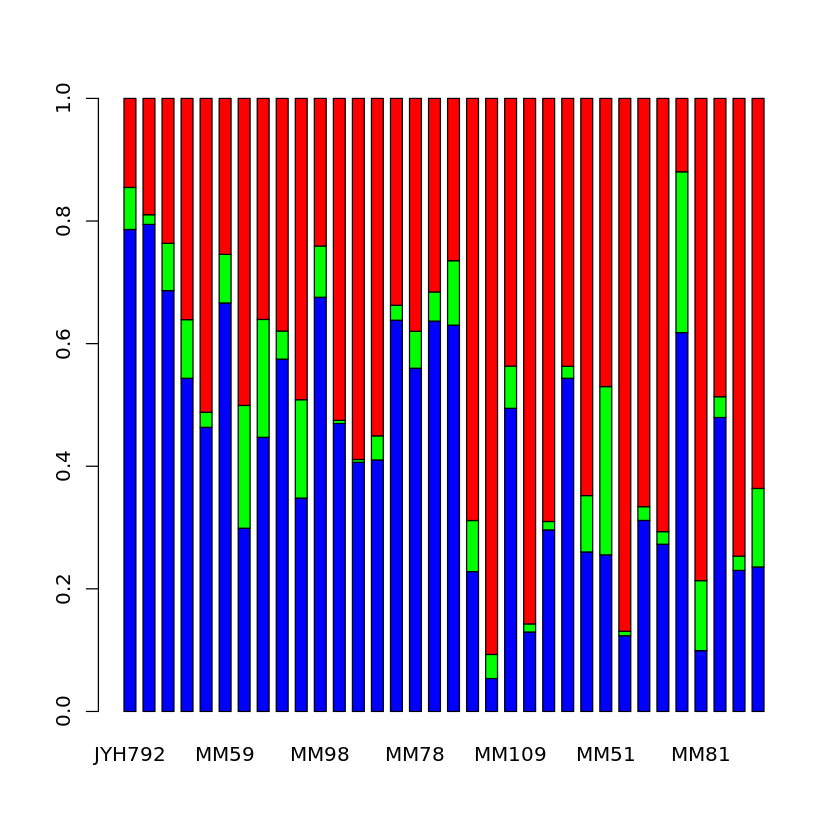

In [72]:
## using AI_Hypothesis_testing.ipynb to generate AI_beta_3group.csv

rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R1=read.csv(paste0(wd_snATAC,'AI_beta_3group.csv'))
pre_label=as.character(R1$pre_disease)
donor=unique(as.character(R1$donor))
C=matrix(0,length(donor),8)
rownames(C)=donor
colnames(C)=c('total_cell','ND_AI','PD_AI','T2D_AI','per_ND','per_PD','per_T2D','accuracy') ######

for (i in 1:length(donor)){
    R_temp=R1[(as.character(R1$donor)==donor[i]),]
    
    label_temp=pre_label[as.character(R1$donor)==donor[i]]
    meta_label=as.character(R_temp$disease)
    
    C[i,1]=dim(R_temp)[1]
    C[i,2]=length(label_temp[label_temp=='ND'])
    C[i,3]=length(label_temp[label_temp=='PD'])
    C[i,4]=length(label_temp[label_temp=='T2D'])
    
    C[i,5]=(C[i,2]/C[i,1])
    C[i,6]=(C[i,3]/C[i,1])
    C[i,7]=(C[i,4]/C[i,1])
}
C=as.data.frame(C)

R_donor=R1[!duplicated(R1$donor),]
all(R_donor$donor==rownames(C))
C$disease=R_donor$disease

temp_acc=rep(1,dim(C)[1])
temp_NDa=as.numeric(C$per_ND)
temp_PDa=as.numeric(C$per_PD)
temp_T2Da=as.numeric(C$per_T2D)

temp_acc[R_donor$disease=='ND']=temp_NDa[R_donor$disease=='ND']
temp_acc[R_donor$disease=='PD']=temp_PDa[R_donor$disease=='PD']
temp_acc[R_donor$disease=='T2D']=temp_T2Da[R_donor$disease=='T2D']
C$accuracy=temp_acc

A=read.csv(paste0(wd_snATAC,'meta_data.csv'))
all(A$donor==rownames(C))
C$HbA1c=A$HbA1c
C$islet_index=A$islet.index
C$age=A$Age
C$BMI=A$BMI
C$Gender=A$Gender
C$Disease=A$Sample.Description.Name

C1=C[order(C$disease),]
C2=C1[,c(5:7)]
S2=t(as.matrix(C2))
barplot(S2, space=0.6,col=c("blue","green","red"),legend.text=FALSE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))


In [73]:
A_mean=aggregate(cbind(accuracy)~disease, data=C, mean)

A_name <- A_mean$disease
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean)=A_name
lim <- 1

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(accuracy)~disease, data=C , sd)

S_name <- stdev$disease
stdev <- as.matrix(stdev[,-1])
rownames(stdev)=S_name

name=as.character(C$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}



[1] 0.9069463

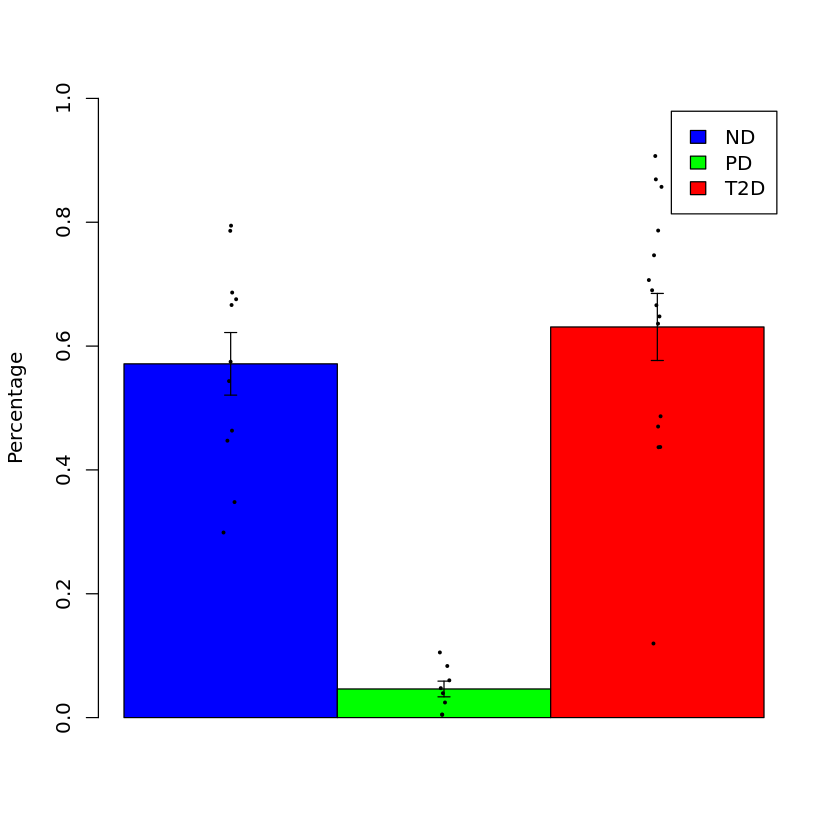

In [74]:
C_ND = C[C$Disease == 'Non',]
C_PD = C[C$Disease == 'Pre',]
C_T2D = C[C$Disease == 'T2D',]

n1 = as.numeric(C_ND$accuracy)
n2 = as.numeric(C_PD$accuracy)
n3 = as.numeric(C_T2D$accuracy)


y = c(n1,n2,n3)
max(y)

x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3))) 
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","green",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

## Identification of beta cell subtypes (Figure 2 b-d)

[1] TRUE

donor  Sample.ID Sample.Description.Name Short.ID Freezing.storage.method
1 JYH792 SAMP-692  Non                     A0018    snap frozen            
2 JYH809 SAMP-689  T2D                     A0016    snap frozen            
3 MM108  SAMP-1613 Pre                     A0011    Dry ice frozen         
  ID    Center islet.index Age Gender ⋯ map_frac_per Purity TSS_frac map_frac
1 A0018 CH     1.3         37  M      ⋯ 73.20%       0.75   30.2     73.2    
2 A0016 CH     1.4         57  M      ⋯ 80.50%       0.73   27.5     80.5    
3 A0011 CH     1.3         34  F      ⋯ 80.10%       0.80   29.7     80.1    
  beta_cell alpha_cell delta_cell gamma_cell Multiome Short.ID.1
1 2782      1632       204        45         No       A0018     
2  763      2292       113        48         No       A0016     
3 1392      1416       249        43         Yes      A0011

[1] TRUE

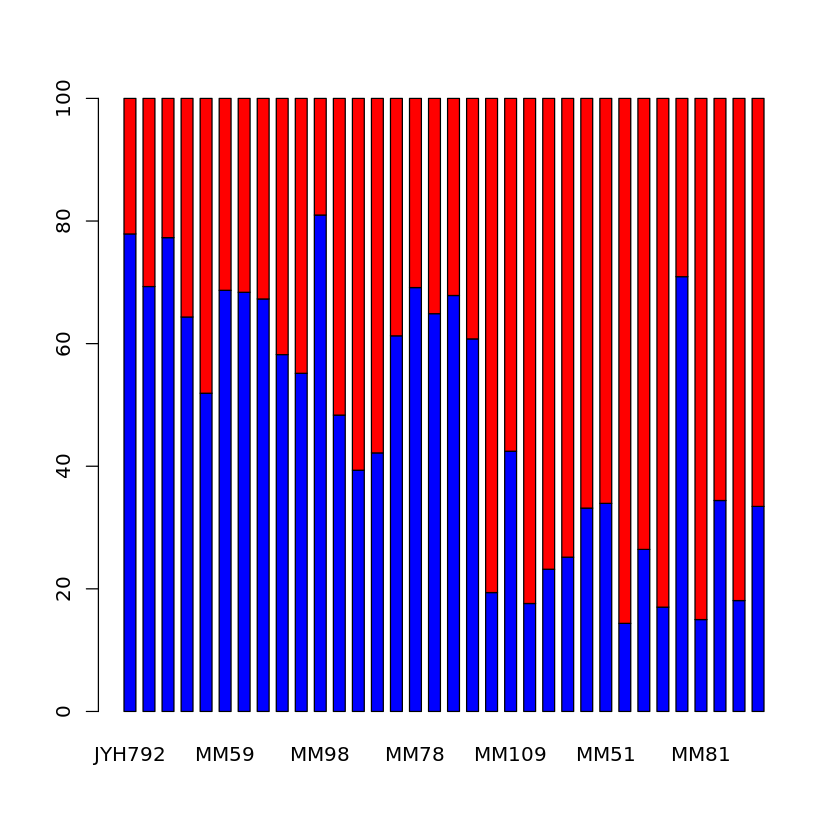

In [126]:
rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

## using AI_subtype.ipynb to classify beta cell subtype: AI_beta_subtype.csv 
M=read.csv(paste0(wd_snATAC,'AI_beta_subtype.csv'))
donor_IDa=as.character(M$donor)
disease_ID=sort(unique(M$subtype))
donor_ID=sort(unique(M$donor))
disease_all=as.character(M$subtype)
donor_all=as.character(M$donor)

S_ID=matrix(0,length(disease_ID),length(donor_ID))
rownames(S_ID)=disease_ID
colnames(S_ID)=donor_ID
for (i in 1:length(disease_ID)){
    for (j in 1:length(donor_ID)){
       keep=(disease_all==disease_ID[i] & donor_all==donor_ID[j])
       if (dim(M[keep,])[1]>0){
           S_ID[i,j]=dim(M[keep,])[1]
       }
    }
}

A2=t(S_ID)
A2_rowsum=rowSums(A2)
A_row=(A2-A2)
for (i in 1:dim(A2)[1]){
    A_row[i,]=100*(A2[i,]/A2_rowsum[i])
}
A=as.data.frame(A_row)
M1=M[!duplicated(M$donor),]
all(as.character(M1$donor)==rownames(A))
A$Disease=as.character(M1$disease)
colnames(A)=c('beta_1','beta_2','Disease')

C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C[1:3,]
all(C$donor==rownames(A))
A$HbA1c=C$HbA1c
A$islet_index=C$islet.index
A$age=C$Age
A$BMI=C$BMI
A$Gender=C$Gender

A1=A[order(A$Disease),]
A2=A1[,c(1:2)]
S2=t(as.matrix(A2))
barplot(S2, space=0.6,col=c("blue","red"),legend.text=FALSE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))


In [127]:
A_mean=aggregate(cbind(beta_1,beta_2)~Disease , data=A , mean)

rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 100

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(beta_1,beta_2)~Disease, data=A , sd)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(A$Disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}


[1] 85.63218

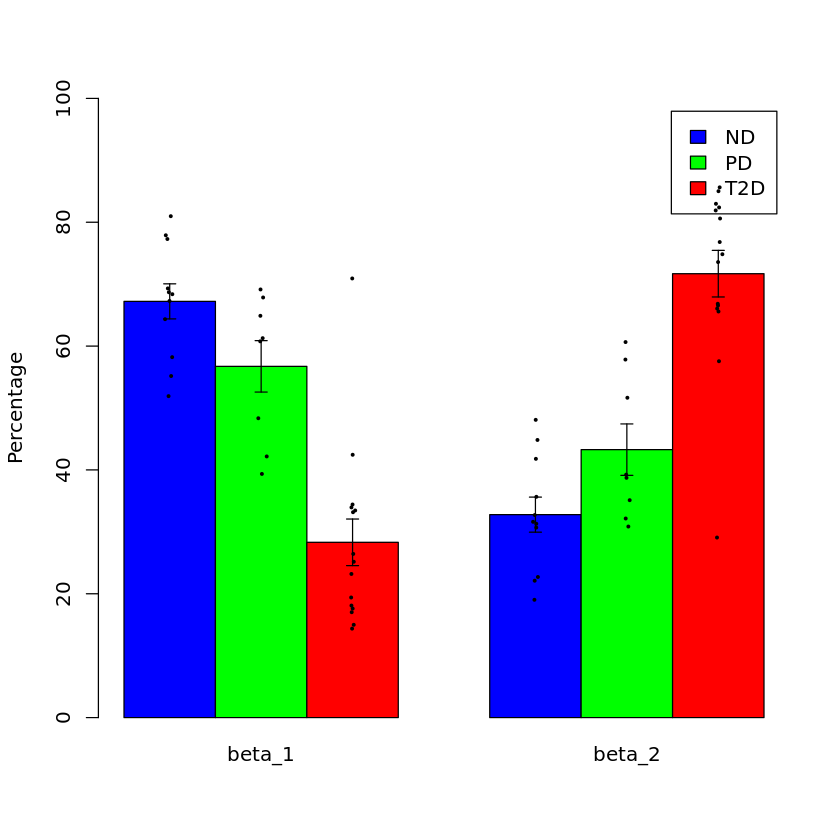

In [128]:
A_ND = A[A$Disease == 'ND',]
A_PD = A[A$Disease == 'PD',]
A_T2D = A[A$Disease == 'T2D',]

n1 = as.numeric(A_ND$beta_1)
n2 = as.numeric(A_PD$beta_1)
n3 = as.numeric(A_T2D$beta_1)

n4 = as.numeric(A_ND$beta_2)
n5 = as.numeric(A_PD$beta_2)
n6 = as.numeric(A_T2D$beta_2)

y = c(n1,n2,n3,n4,n5,n6)
max(y)

x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3)),
      rep(5.5,length(n4)),rep(6.5,length(n5)),rep(7.5,length(n6))) 
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'green','red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

In [101]:
subtype <- lm(beta_1 ~ Disease + age + islet_index + Gender + BMI, data = A)
summary(subtype)


Call:
lm(formula = beta_1 ~ Disease + age + islet_index + Gender + 
    BMI, data = A)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.4079  -7.5990   0.6292   6.2408  23.3660 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 127.8070    20.2684   6.306 9.49e-07 ***
DiseasePD   -11.3797     5.8345  -1.950   0.0616 .  
DiseaseT2D  -38.8921     4.9195  -7.906 1.69e-08 ***
age          -0.4397     0.1717  -2.562   0.0163 *  
islet_index -16.0837     7.7890  -2.065   0.0487 *  
GenderM       1.7241     4.8513   0.355   0.7251    
BMI          -0.6769     0.4196  -1.613   0.1183    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.97 on 27 degrees of freedom
Multiple R-squared:  0.7878,	Adjusted R-squared:  0.7407 
F-statistic: 16.71 on 6 and 27 DF,  p-value: 5.882e-08


In [102]:
A$Disease <- relevel(as.factor(A$Disease), ref = 'PD')
subtype <- lm(beta_1 ~ Disease + age + islet_index + Gender + BMI, data = A) 

summary(subtype)


Call:
lm(formula = beta_1 ~ Disease + age + islet_index + Gender + 
    BMI, data = A)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.4079  -7.5990   0.6292   6.2408  23.3660 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 116.4273    19.5266   5.962 2.34e-06 ***
DiseaseND    11.3797     5.8345   1.950   0.0616 .  
DiseaseT2D  -27.5124     4.9894  -5.514 7.68e-06 ***
age          -0.4397     0.1717  -2.562   0.0163 *  
islet_index -16.0837     7.7890  -2.065   0.0487 *  
GenderM       1.7241     4.8513   0.355   0.7251    
BMI          -0.6769     0.4196  -1.613   0.1183    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.97 on 27 degrees of freedom
Multiple R-squared:  0.7878,	Adjusted R-squared:  0.7407 
F-statistic: 16.71 on 6 and 27 DF,  p-value: 5.882e-08


In [103]:
subtype <- lm(beta_2 ~ Disease + age + islet_index + Gender + BMI, data = A)
summary(subtype)


Call:
lm(formula = beta_2 ~ Disease + age + islet_index + Gender + 
    BMI, data = A)

Residuals:
     Min       1Q   Median       3Q      Max 
-23.3660  -6.2408  -0.6292   7.5990  22.4079 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -16.4273    19.5266  -0.841   0.4076    
DiseaseND   -11.3797     5.8345  -1.950   0.0616 .  
DiseaseT2D   27.5124     4.9894   5.514 7.68e-06 ***
age           0.4397     0.1717   2.562   0.0163 *  
islet_index  16.0837     7.7890   2.065   0.0487 *  
GenderM      -1.7241     4.8513  -0.355   0.7251    
BMI           0.6769     0.4196   1.613   0.1183    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.97 on 27 degrees of freedom
Multiple R-squared:  0.7878,	Adjusted R-squared:  0.7407 
F-statistic: 16.71 on 6 and 27 DF,  p-value: 5.882e-08


In [104]:
A$Disease <- relevel(as.factor(A$Disease), ref = 'PD')
subtype <- lm(beta_2 ~ Disease + age + islet_index + Gender + BMI, data = A) 

summary(subtype)


Call:
lm(formula = beta_2 ~ Disease + age + islet_index + Gender + 
    BMI, data = A)

Residuals:
     Min       1Q   Median       3Q      Max 
-23.3660  -6.2408  -0.6292   7.5990  22.4079 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -16.4273    19.5266  -0.841   0.4076    
DiseaseND   -11.3797     5.8345  -1.950   0.0616 .  
DiseaseT2D   27.5124     4.9894   5.514 7.68e-06 ***
age           0.4397     0.1717   2.562   0.0163 *  
islet_index  16.0837     7.7890   2.065   0.0487 *  
GenderM      -1.7241     4.8513  -0.355   0.7251    
BMI           0.6769     0.4196   1.613   0.1183    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.97 on 27 degrees of freedom
Multiple R-squared:  0.7878,	Adjusted R-squared:  0.7407 
F-statistic: 16.71 on 6 and 27 DF,  p-value: 5.882e-08


`geom_smooth()` using formula 'y ~ x'


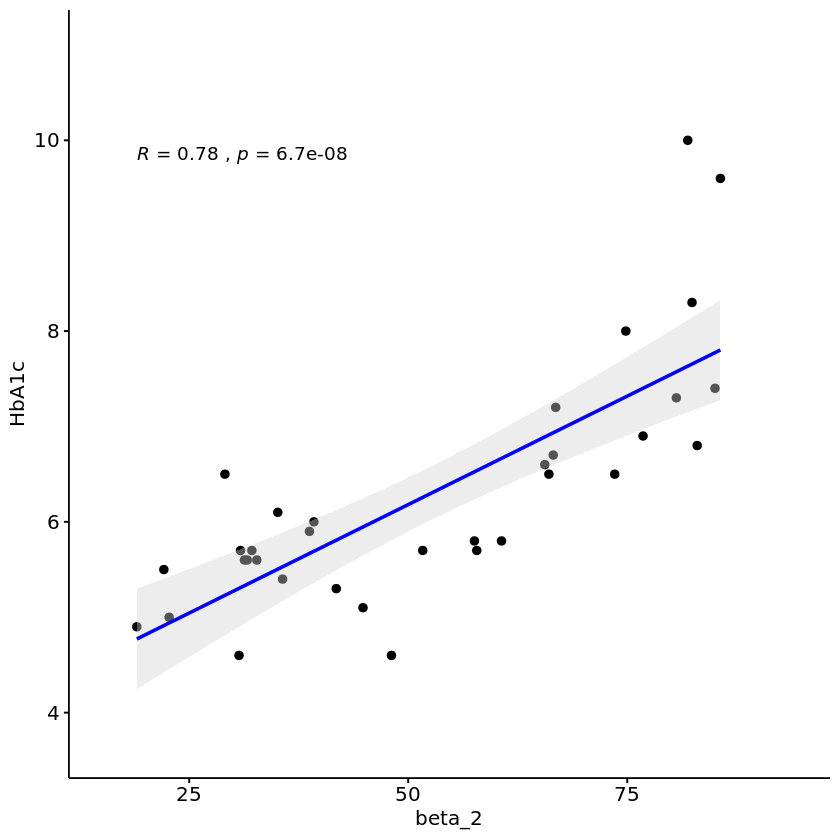

In [105]:
D_min=min(A$beta_2)
D_max=max(A$beta_2)
R_min=min(A$HbA1c)
R_max=max(A$HbA1c)


p2 <- ggscatter(A, x = "beta_2", y = "HbA1c",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(0.8*D_min,1.1*D_max),ylim = c(0.8*R_min,1.1*R_max))

## Beta subtype composition (Sex, BMI, Islet index, Age), S Figure 6a-d

In [106]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

## using AI_subtype.ipynb to classify beta cell subtype: AI_beta_subtype.csv 
M=read.csv(paste0(wd_snATAC,'AI_beta_subtype.csv'))
donor_IDa=as.character(M$donor)
disease_ID=sort(unique(M$subtype))
donor_ID=sort(unique(M$donor))
disease_all=as.character(M$subtype)
donor_all=as.character(M$donor)

S_ID=matrix(0,length(disease_ID),length(donor_ID))
rownames(S_ID)=disease_ID
colnames(S_ID)=donor_ID
for (i in 1:length(disease_ID)){
    for (j in 1:length(donor_ID)){
       keep=(disease_all==disease_ID[i] & donor_all==donor_ID[j])
       if (dim(M[keep,])[1]>0){
           S_ID[i,j]=dim(M[keep,])[1]
       }
    }
}

A2=t(S_ID)
A2_rowsum=rowSums(A2)
A_row=(A2-A2)
for (i in 1:dim(A2)[1]){
    A_row[i,]=100*(A2[i,]/A2_rowsum[i])
}
A=as.data.frame(A_row)
M1=M[!duplicated(M$donor),]
all(as.character(M1$donor)==rownames(A))
A$Disease=as.character(M1$disease)
colnames(A)=c('beta_1','beta_2','Disease')

C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
all(C$donor==rownames(A))
A$HbA1c=C$HbA1c
A$islet_index=C$islet.index
A$age=C$Age
A$BMI=C$BMI
A$Gender=C$Gender


[1] TRUE

[1] TRUE

In [108]:
A_mean=aggregate(cbind(beta_1,beta_2)~Gender, data=A , mean)

rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 100

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(beta_1,beta_2)~Gender, data=A , sd)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(A$Gender)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}



[1] 85.63218

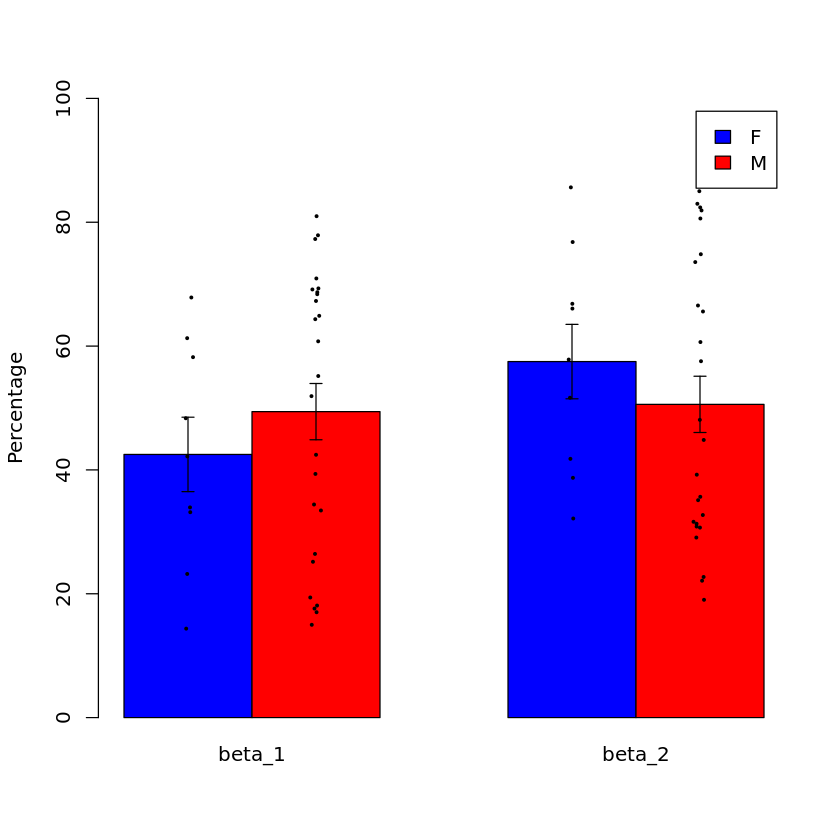

In [109]:
A_F = A[A$Gender == 'F',]
A_M = A[A$Gender == 'M',]

n1 = as.numeric(A_F$beta_1)
n2 = as.numeric(A_M$beta_1)
n3 = as.numeric(A_F$beta_2)
n4 = as.numeric(A_M$beta_2)

y = c(n1,n2,n3,n4)
max(y)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(4.5,length(n3)),rep(5.5,length(n4)))
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

`geom_smooth()` using formula 'y ~ x'


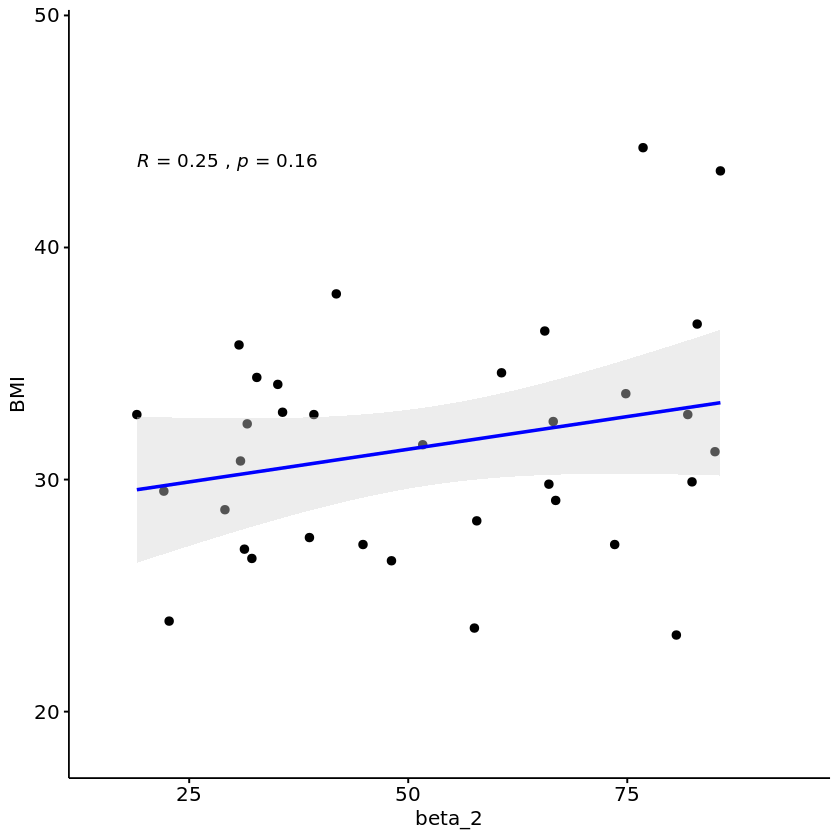

In [110]:
D_min=min(A$beta_2)
D_max=max(A$beta_2)
R_min=min(A$BMI)
R_max=max(A$BMI)


p2 <- ggscatter(A, x = "beta_2", y = "BMI",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.1*D_max),ylim = c(0.8*R_min,1.1*R_max))

`geom_smooth()` using formula 'y ~ x'


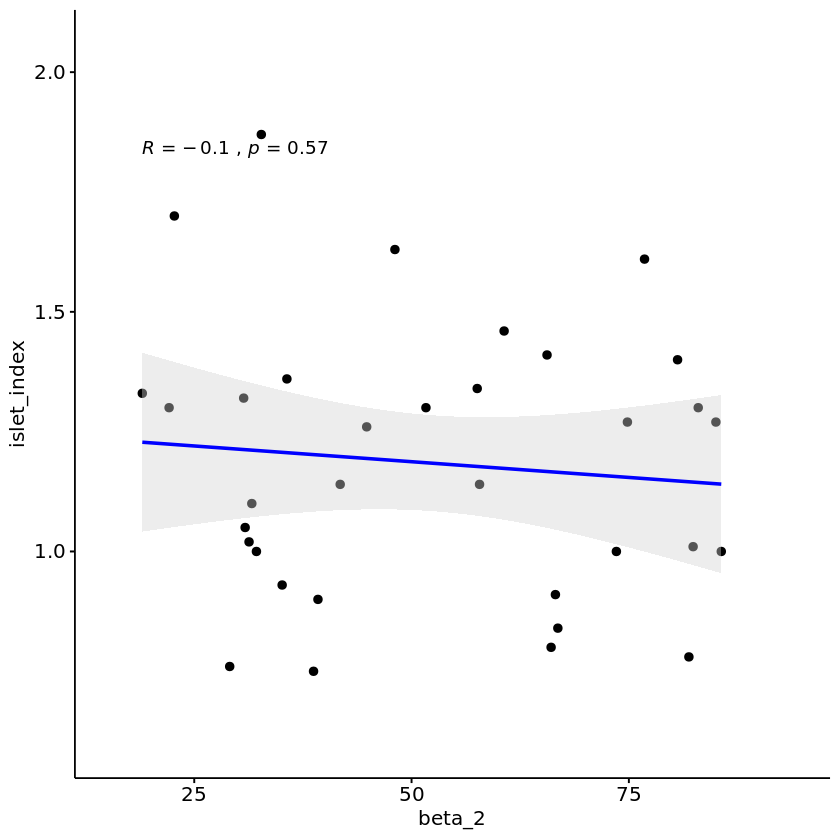

In [111]:
D_min=min(A$beta_2)
D_max=max(A$beta_2)
R_min=min(A$islet_index)
R_max=max(A$islet_index)


p2 <- ggscatter(A, x = "beta_2", y = "islet_index",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.1*D_max),ylim = c(0.8*R_min,1.1*R_max))

`geom_smooth()` using formula 'y ~ x'


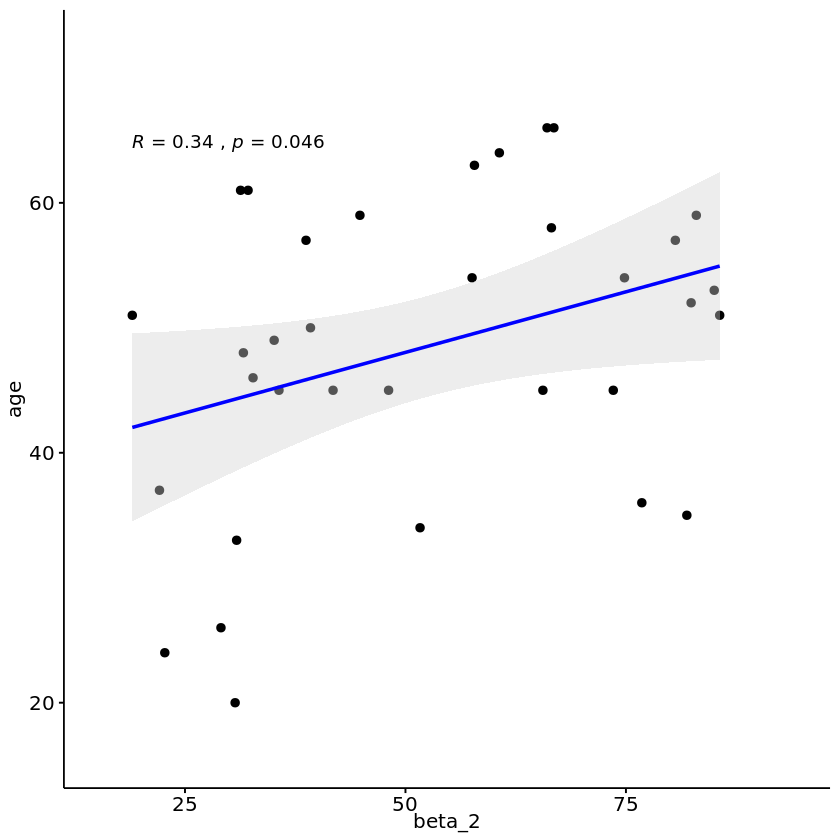

In [112]:
D_min=min(A$beta_2)
D_max=max(A$beta_2)
R_min=min(A$age)
R_max=max(A$age)


p2 <- ggscatter(A, x = "beta_2", y = "age",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.1*D_max),ylim = c(0.8*R_min,1.1*R_max))

## Validation of beta cell subtype using independent snATAC-seq data (S Figure 6e-f)

[1] TRUE

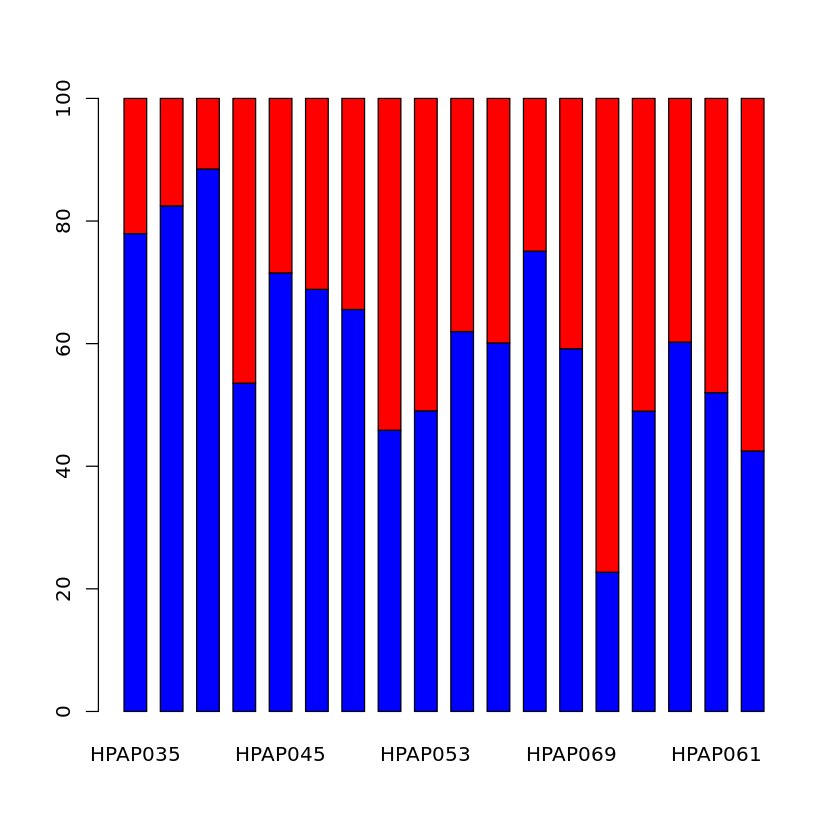

In [113]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

### using AI_HPAP.ipynb to classify beta cells from HPAP snATAC-seq data set
M=read.csv(paste0(wd_snATAC,'AI_HPAP_beta.csv'))
donor_IDa=as.character(M$donor)
subtype_ID=sort(unique(M$subtype))
donor_ID=sort(unique(M$donor))
subtype_all=as.character(M$subtype)
donor_all=as.character(M$donor)

S_ID=matrix(0,length(subtype_ID),length(donor_ID))
rownames(S_ID)=subtype_ID
colnames(S_ID)=donor_ID
for (i in 1:length(subtype_ID)){
    for (j in 1:length(donor_ID)){
       keep=(subtype_all==subtype_ID[i] & donor_all==donor_ID[j])
       if (dim(M[keep,])[1]>0){
           S_ID[i,j]=dim(M[keep,])[1]
       }
    }
}

CS=S_ID
A2=t(CS)
A2_rowsum=rowSums(A2)
A_row=(A2-A2)
for (i in 1:dim(A2)[1]){
    A_row[i,]=100*(A2[i,]/A2_rowsum[i])
}
A=as.data.frame(A_row)

M=read.csv(paste0(wd_snATAC,'HPAP_metadata.csv'))
donor_use=intersect(as.character(M$donor),rownames(A))

A=A[rownames(A) %in% donor_use,]
M=M[as.character(M$donor) %in% donor_use,]
all(rownames(A)==as.character(M$donor))
A$Disease=M$Sample.Description.Name
A$HbA1c=M$HbA1c
A$Gender=M$Gender
A$BMI=M$BMI
A$Age=M$Age

A=A[!(rownames(A) %in% c('HPAP042','HPAP044','HPAP047','HPAP063','HPAP067')),] ### donors with less than 100 cells or pre-T2D donors

A1=A[order(A$Disease),]
A2=A1[,c(1:2)]
S2=t(as.matrix(A2))
barplot(S2, space=0.6,col=c("blue","red"),legend.text=TRUE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))

In [119]:
### disease (all cells)
A_mean=aggregate(cbind(beta_1,beta_2)~Disease , data=A , mean)

rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 100

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(beta_1,beta_2)~Disease, data=A , sd)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(A$Disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}



[1] 88.47682

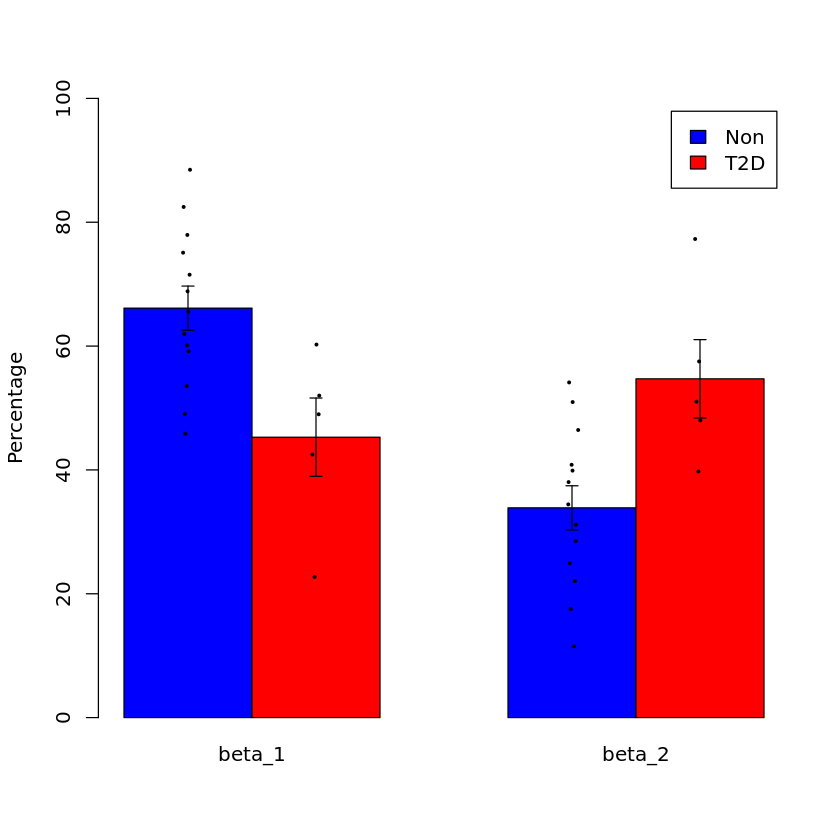

In [120]:
A_ND = A[A$Disease == 'Non',]
A_T2D = A[A$Disease == 'T2D',]

n1 = as.numeric(A_ND$beta_1)
n2 = as.numeric(A_T2D$beta_1)
n3 = as.numeric(A_ND$beta_2)
n4 = as.numeric(A_T2D$beta_2)

y = c(n1,n2,n3,n4)
max(y)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(4.5,length(n3)),rep(5.5,length(n4)))
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

In [121]:
subtype <- aov(beta_1 ~ Disease + Age + Gender + BMI, data = A)
summary(subtype)

            Df Sum Sq Mean Sq F value  Pr(>F)   
Disease      1 1568.5  1568.5  12.717 0.00345 **
Age          1  684.0   684.0   5.546 0.03490 * 
Gender       1   40.8    40.8   0.331 0.57511   
BMI          1  457.4   457.4   3.708 0.07629 . 
Residuals   13 1603.5   123.3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [122]:
subtype <- aov(beta_2 ~ Disease + Age + Gender + BMI, data = A)
summary(subtype)

            Df Sum Sq Mean Sq F value  Pr(>F)   
Disease      1 1568.5  1568.5  12.717 0.00345 **
Age          1  684.0   684.0   5.546 0.03490 * 
Gender       1   40.8    40.8   0.331 0.57511   
BMI          1  457.4   457.4   3.708 0.07629 . 
Residuals   13 1603.5   123.3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Validation of beta cell subtype using independent computational method (S Figure 6h, k, l)

In [144]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

## beta cell annotation based on S Figure 6g
M=read.csv(paste0(wd_snATAC,'UMAP_beta_diff.csv'))
cluster_ID=sort(unique(M$cluster))
donor_ID=sort(unique(M$donor))
cluster_all=M$cluster
donor_all=M$donor

S_ID=matrix(0,length(cluster_ID),length(donor_ID))
rownames(S_ID)=cluster_ID
colnames(S_ID)=donor_ID
for (i in 1:length(cluster_ID)){
    for (j in 1:length(donor_ID)){
       keep=(cluster_all==cluster_ID[i] & donor_all==donor_ID[j])
       if (dim(M[keep,])[1]>0){
           S_ID[i,j]=dim(M[keep,])[1]
       }
    }
}

C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C_donor=as.character(C$donor)
C_disease=as.character(C$Sample.Description.Name)
C_ND=C_donor[C_disease=='Non']
C_PD=C_donor[C_disease=='Pre']
C_T2D=C_donor[C_disease=='T2D']

## cell types
CS=S_ID
totnum=colSums(CS)
S_ID_norm1=(CS - CS)
for (i in 1:dim(CS)[2]){
  S_ID_norm1[,i]=CS[,i]*(100/totnum[i])
}

A2=t(CS)
A2_colsum=colSums(A2)
A2_rowsum=rowSums(A2)
A_row=(A2-A2)
for (i in 1:dim(A2)[1]){
    A_row[i,]=100*(A2[i,]/A2_rowsum[i])
}
A=as.data.frame(A_row)

all(rownames(A)==as.character(C$donor))
### add clinical infromation to each donor
A$Disease=C$Sample.Description.Name
A$method=C$Freezing.storage.method
A$center=C$Center
A$islet.index=C$islet.index
A$age=C$Age
A$gender=C$Gender
A$BMI=C$BMI
A$HbA1c=C$HbA1c
A$Purity=C$Purity


[1] TRUE

[1] TRUE

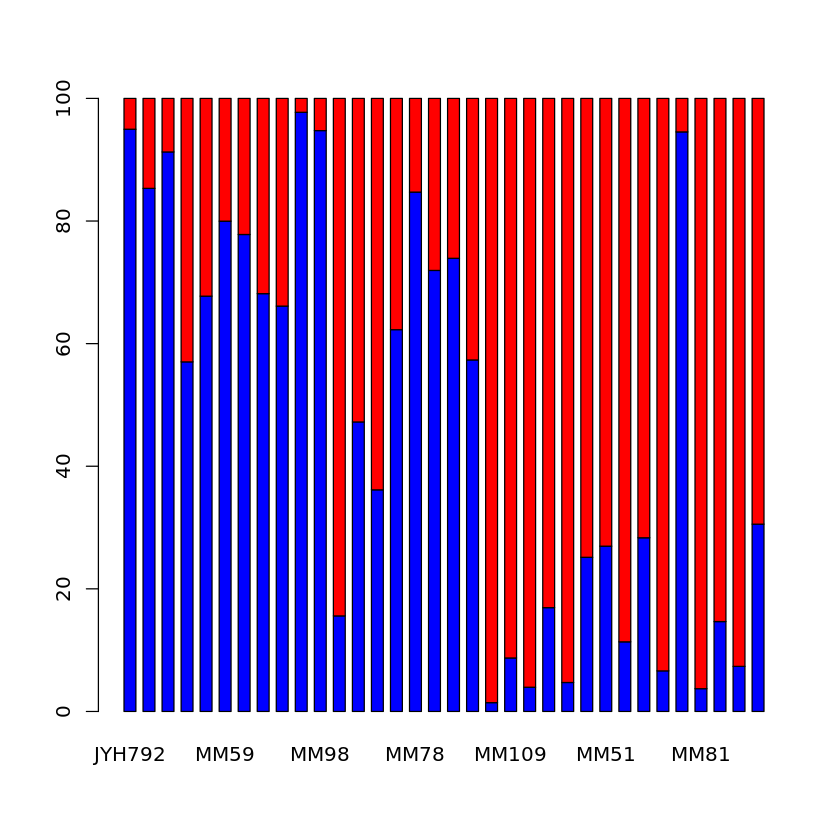

In [145]:
A1=A[,c(1:2)]
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
keep=(C$donor %in% rownames(A))
C=C[keep,]
C=C[order(C$donor),]
A1=A1[order(rownames(A1)),]
all(C$donor==rownames(A1))

C1=C[order(C$Sample.Description.Name),]
A2=A1[order(C$Sample.Description.Name),]
S2=t(as.matrix(A2))
barplot(S2, space=0.6,col=c("blue","red"),legend.text=FALSE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))

In [146]:
A_mean=aggregate(cbind(beta_1,beta_2)~Disease , data=A , mean)

rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 1.35*max(A_mean)

error.bar <- function(x, y, upper, lower=upper, length=0.02,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(beta_1,beta_2)~Disease, data=A , sd)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(A$Disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}


[1] 98.55832

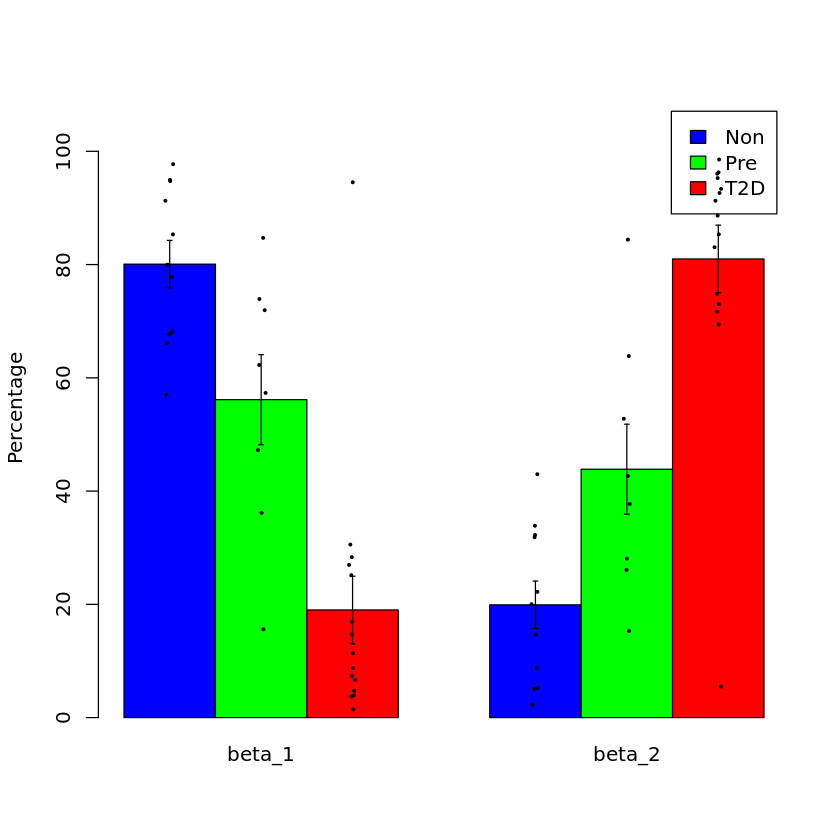

In [147]:
A_ND = A[A$Disease == 'Non',]
A_PD = A[A$Disease == 'Pre',]
A_T2D = A[A$Disease == 'T2D',]

n1 = as.numeric(A_ND$beta_1)
n2 = as.numeric(A_PD$beta_1)
n3 = as.numeric(A_T2D$beta_1)

n4 = as.numeric(A_ND$beta_2)
n5 = as.numeric(A_PD$beta_2)
n6 = as.numeric(A_T2D$beta_2)

y = c(n1,n2,n3,n4,n5,n6)
max(y)

x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3)),
      rep(5.5,length(n4)),rep(6.5,length(n5)),rep(7.5,length(n6))) 
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","green",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

In [148]:
summary <- aov(beta_1 ~ Disease + age + gender + BMI, data = A)

summary(summary)
TukeyHSD(summary,which='Disease')

            Df Sum Sq Mean Sq F value   Pr(>F)    
Disease      2  24454   12227  29.988 1.09e-07 ***
age          1    809     809   1.983    0.170    
gender       1    208     208   0.510    0.481    
BMI          1    514     514   1.259    0.271    
Residuals   28  11417     408                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: age”Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: BMI”

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = beta_1 ~ Disease + age + gender + BMI, data = A)

$Disease
             diff       lwr         upr     p adj
Pre-Non -23.93483 -47.15069  -0.7189656 0.0423001
T2D-Non -61.07584 -80.90910 -41.2425833 0.0000001
T2D-Pre -37.14101 -59.01473 -15.2672909 0.0006945


In [149]:
summary <- aov(beta_2 ~ Disease + age + gender + BMI, data = A)

summary(summary)
TukeyHSD(summary,which='Disease')

            Df Sum Sq Mean Sq F value   Pr(>F)    
Disease      2  24454   12227  29.988 1.09e-07 ***
age          1    809     809   1.983    0.170    
gender       1    208     208   0.510    0.481    
BMI          1    514     514   1.259    0.271    
Residuals   28  11417     408                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: age”Warning message in replications(paste("~", xx), data = mf):
“non-factors ignored: BMI”

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = beta_2 ~ Disease + age + gender + BMI, data = A)

$Disease
            diff        lwr      upr     p adj
Pre-Non 23.93483  0.7189656 47.15069 0.0423001
T2D-Non 61.07584 41.2425833 80.90910 0.0000001
T2D-Pre 37.14101 15.2672909 59.01473 0.0006945


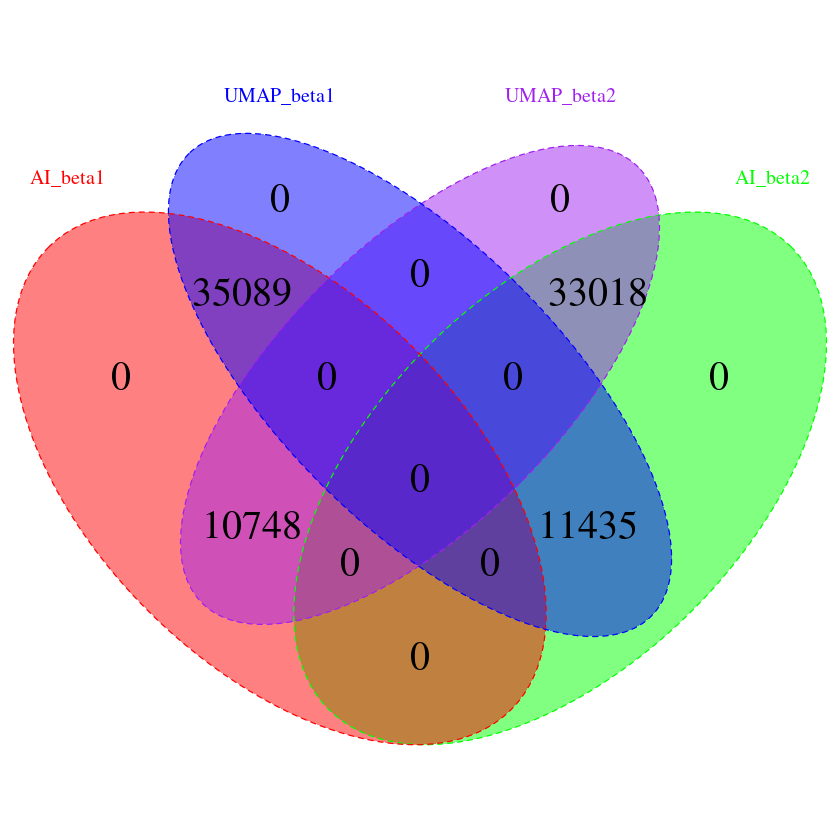

In [150]:
M_AI=read.csv(paste0(wd_snATAC,'AI_beta_subtype.csv'))
AI_barcode=as.character(M_AI$index)

AI_beta1=AI_barcode[M_AI$subtype=='beta_1']
AI_beta2=AI_barcode[M_AI$subtype=='beta_2']


M_UMAP=read.csv(paste0(wd_snATAC,'UMAP_beta_diff.csv'))
M_UMAP=M_UMAP[M_UMAP$index %in% M_AI$index,]
UMAP_barcode=as.character(M_UMAP$index)

UMAP_beta1=UMAP_barcode[M_UMAP$cluster=='beta_1']
UMAP_beta2=UMAP_barcode[M_UMAP$cluster=='beta_2']

## overlap
T<-venn.diagram(x=list(AI_beta1=AI_beta1, AI_beta2=AI_beta2, UMAP_beta1=UMAP_beta1, UMAP_beta2=UMAP_beta2),filename=NULL
,lwd=1,lty=2,col=c('red','green','blue','purple')
,fill=c('red','green','blue','purple')
,cat.col=c('red','green','blue','purple'),cex = 2
,reverse=TRUE)
grid.draw(T)

In [151]:
## beta_1
binom.test(35089, 35089+10748, p = 0.5,alternative = "two.sided")


	Exact binomial test

data:  35089 and 35089 + 10748
number of successes = 35089, number of trials = 45837, p-value <
2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.7616107 0.7693895
sample estimates:
probability of success 
             0.7655169 


In [152]:
## beta_2
binom.test(33018, 33018+11435, p = 0.5,alternative = "two.sided")


	Exact binomial test

data:  33018 and 33018 + 11435
number of successes = 33018, number of trials = 44453, p-value <
2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.7386716 0.7468207
sample estimates:
probability of success 
              0.742762 


# Alpha cell subtype identification (S Figure5 f, g)

[1] TRUE

[1] TRUE

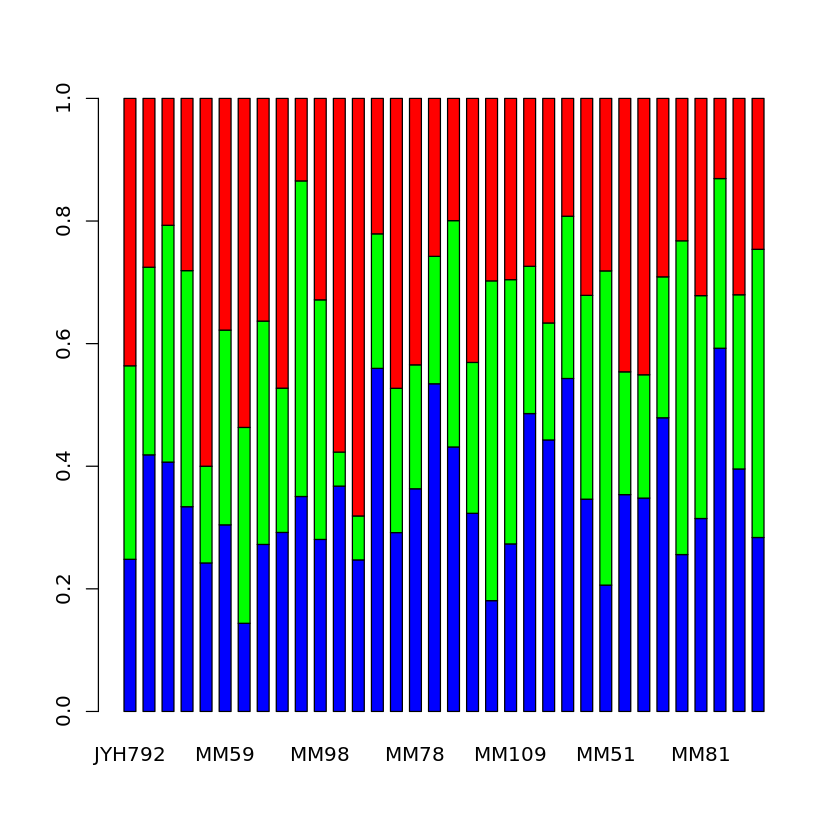

In [155]:
## using AI_Hypothesis_testing.ipynb to generate AI_alpha_3group.csv
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R1=read.csv(paste0(wd_snATAC,'AI_alpha_3group.csv'))
pre_label=as.character(R1$pre_disease)
donor=unique(as.character(R1$donor))
C=matrix(0,length(donor),8)
rownames(C)=donor
colnames(C)=c('total_cell','ND_AI','PD_AI','T2D_AI','per_ND','per_PD','per_T2D','accuracy') ######

for (i in 1:length(donor)){
    R_temp=R1[(as.character(R1$donor)==donor[i]),]
    
    label_temp=pre_label[as.character(R1$donor)==donor[i]]
    meta_label=as.character(R_temp$disease)
    
    C[i,1]=dim(R_temp)[1]
    C[i,2]=length(label_temp[label_temp=='ND'])
    C[i,3]=length(label_temp[label_temp=='PD'])
    C[i,4]=length(label_temp[label_temp=='T2D'])
    
    C[i,5]=(C[i,2]/C[i,1])
    C[i,6]=(C[i,3]/C[i,1])
    C[i,7]=(C[i,4]/C[i,1])
}
C=as.data.frame(C)

R_donor=R1[!duplicated(R1$donor),]
all(R_donor$donor==rownames(C))
C$disease=R_donor$disease

temp_acc=rep(1,dim(C)[1])
temp_NDa=as.numeric(C$per_ND)
temp_PDa=as.numeric(C$per_PD)
temp_T2Da=as.numeric(C$per_T2D)

temp_acc[R_donor$disease=='ND']=temp_NDa[R_donor$disease=='ND']
temp_acc[R_donor$disease=='PD']=temp_PDa[R_donor$disease=='PD']
temp_acc[R_donor$disease=='T2D']=temp_T2Da[R_donor$disease=='T2D']
C$accuracy=temp_acc

A=read.csv(paste0(wd_snATAC,'meta_data.csv'))
all(A$donor==rownames(C))
C$HbA1c=A$HbA1c
C$islet_index=A$islet.index
C$age=A$Age
C$BMI=A$BMI
C$Gender=A$Gender
C$Disease=A$Sample.Description.Name

C1=C[order(C$disease),]
C2=C1[,c(5:7)]
S2=t(as.matrix(C2))
barplot(S2, space=0.6,col=c("blue","green","red"),legend.text=FALSE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))

In [158]:
A_mean=aggregate(cbind(accuracy)~disease , data=C , mean)

A_name <- A_mean$disease
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean)=A_name
lim <- 1

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(accuracy)~disease, data=C , sd)

S_name <- stdev$disease
stdev <- as.matrix(stdev[,-1])
rownames(stdev)=S_name

name=as.character(C$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}


[1] 0.4507846

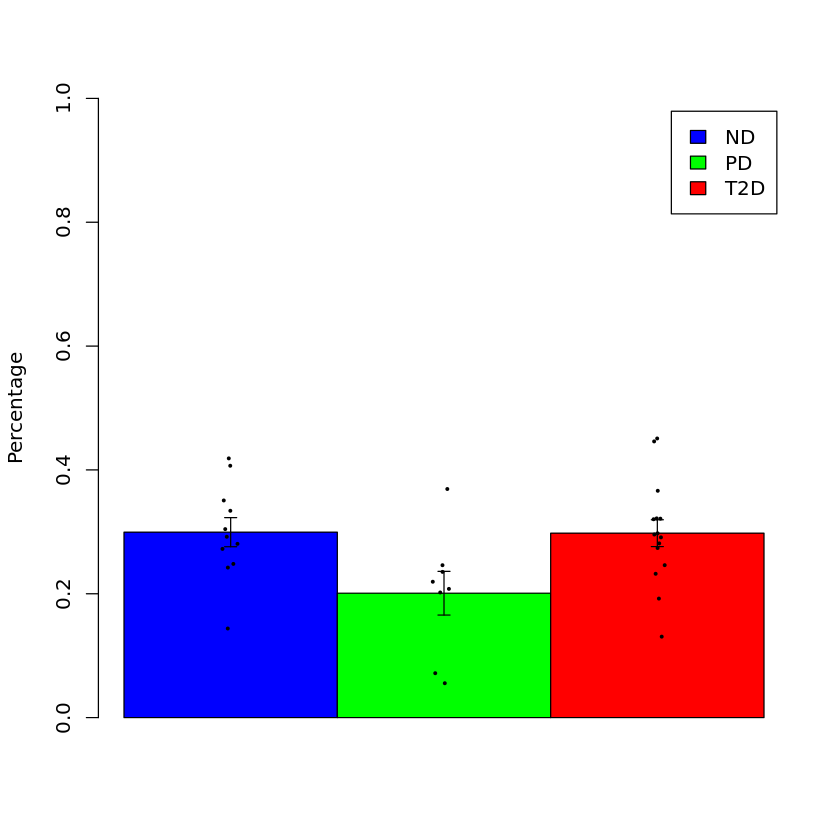

In [159]:
C_ND = C[C$Disease == 'Non',]
C_PD = C[C$Disease == 'Pre',]
C_T2D = C[C$Disease == 'T2D',]

n1 = as.numeric(C_ND$accuracy)
n2 = as.numeric(C_PD$accuracy)
n3 = as.numeric(C_T2D$accuracy)


y = c(n1,n2,n3)
max(y)

x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3))) 
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","green",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

# Delta cell subtype identification (S Figure 5h, i)

[1] TRUE

[1] TRUE

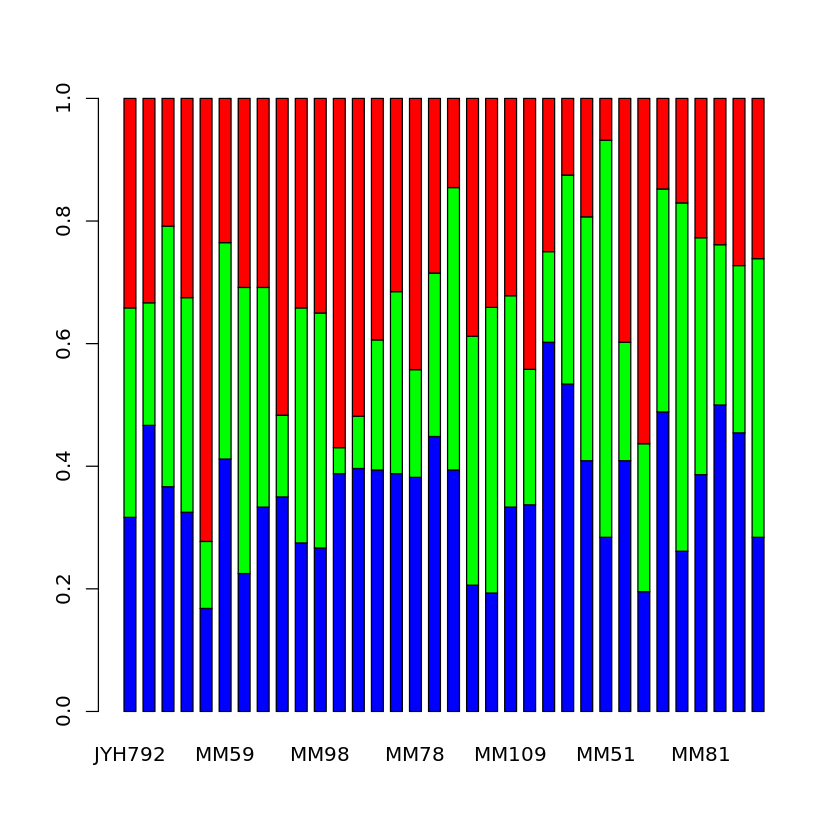

In [160]:
## using AI_Hypothesis_testing.ipynb to generate AI_delta_3group.csv

rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R1=read.csv(paste0(wd_snATAC,'AI_delta_3group.csv'))
pre_label=as.character(R1$pre_disease)
donor=unique(as.character(R1$donor))
C=matrix(0,length(donor),8)
rownames(C)=donor
colnames(C)=c('total_cell','ND_AI','PD_AI','T2D_AI','per_ND','per_PD','per_T2D','accuracy') ######

for (i in 1:length(donor)){
    R_temp=R1[(as.character(R1$donor)==donor[i]),]
    
    label_temp=pre_label[as.character(R1$donor)==donor[i]]
    meta_label=as.character(R_temp$disease)
    
    C[i,1]=dim(R_temp)[1]
    C[i,2]=length(label_temp[label_temp=='ND'])
    C[i,3]=length(label_temp[label_temp=='PD'])
    C[i,4]=length(label_temp[label_temp=='T2D'])
    
    C[i,5]=(C[i,2]/C[i,1])
    C[i,6]=(C[i,3]/C[i,1])
    C[i,7]=(C[i,4]/C[i,1])
}
C=as.data.frame(C)

R_donor=R1[!duplicated(R1$donor),]
all(R_donor$donor==rownames(C))
C$disease=R_donor$disease

temp_acc=rep(1,dim(C)[1])
temp_NDa=as.numeric(C$per_ND)
temp_PDa=as.numeric(C$per_PD)
temp_T2Da=as.numeric(C$per_T2D)

temp_acc[R_donor$disease=='ND']=temp_NDa[R_donor$disease=='ND']
temp_acc[R_donor$disease=='PD']=temp_PDa[R_donor$disease=='PD']
temp_acc[R_donor$disease=='T2D']=temp_T2Da[R_donor$disease=='T2D']
C$accuracy=temp_acc

A=read.csv(paste0(wd_snATAC,'meta_data.csv'))
all(A$donor==rownames(C))
C$HbA1c=A$HbA1c
C$islet_index=A$islet.index
C$age=A$Age
C$BMI=A$BMI
C$Gender=A$Gender
C$Disease=A$Sample.Description.Name

C1=C[order(C$disease),]
C2=C1[,c(5:7)]
S2=t(as.matrix(C2))
barplot(S2, space=0.6,col=c("blue","green","red"),legend.text=FALSE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))

In [165]:
A_mean=aggregate(cbind(accuracy)~disease , data=C , mean)

A_name <- A_mean$disease
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean)=A_name
lim <- 1

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(accuracy)~disease, data=C , sd)

S_name <- stdev$disease
stdev <- as.matrix(stdev[,-1])
rownames(stdev)=S_name

name=as.character(C$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}



[1] 0.5632184

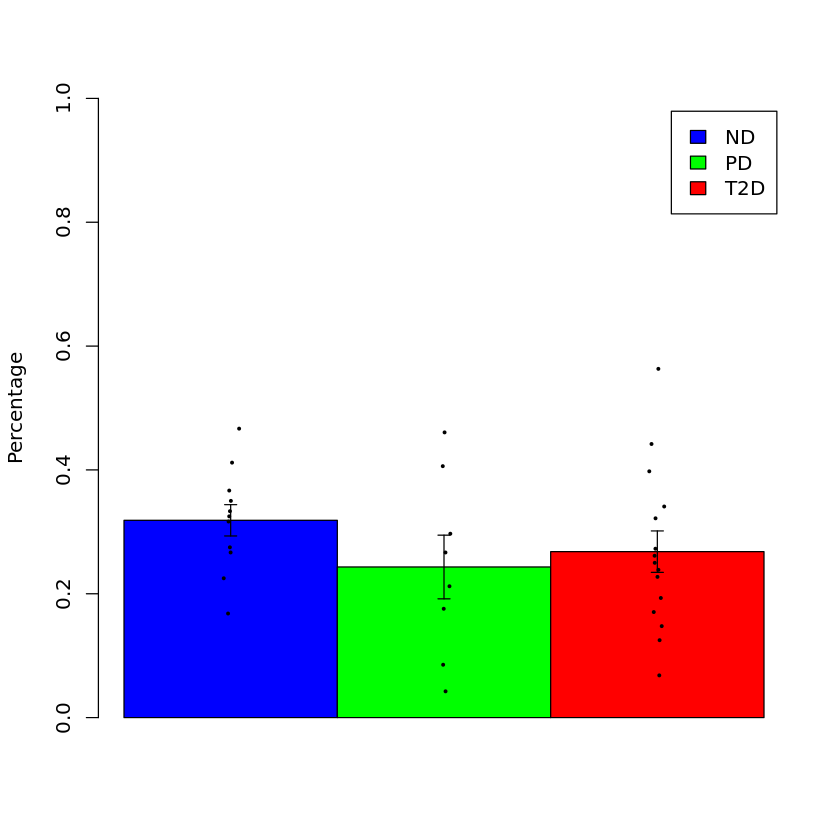

In [166]:
C_ND = C[C$Disease == 'Non',]
C_PD = C[C$Disease == 'Pre',]
C_T2D = C[C$Disease == 'T2D',]

n1 = as.numeric(C_ND$accuracy)
n2 = as.numeric(C_PD$accuracy)
n3 = as.numeric(C_T2D$accuracy)


y = c(n1,n2,n3)
max(y)

x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3))) 
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","green",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

# Differential cCREs and genes between beta cell subtypes

## Differential cCREs between beta cell subtypes (Figure 3b)

[1] 58

[1] 229520     58

JYH792_beta1 MM108_beta1 MM109_beta1
1:100009946-100010446 3.3434128    7.118073    4.6426323  
1:100014513-100015013 3.5739930    1.642632    3.7583214  
1:100017730-100018230 0.4611604    1.642632    0.8843109

[1] TRUE

[1] TRUE

[1] 3029   29

[1] 4653   29

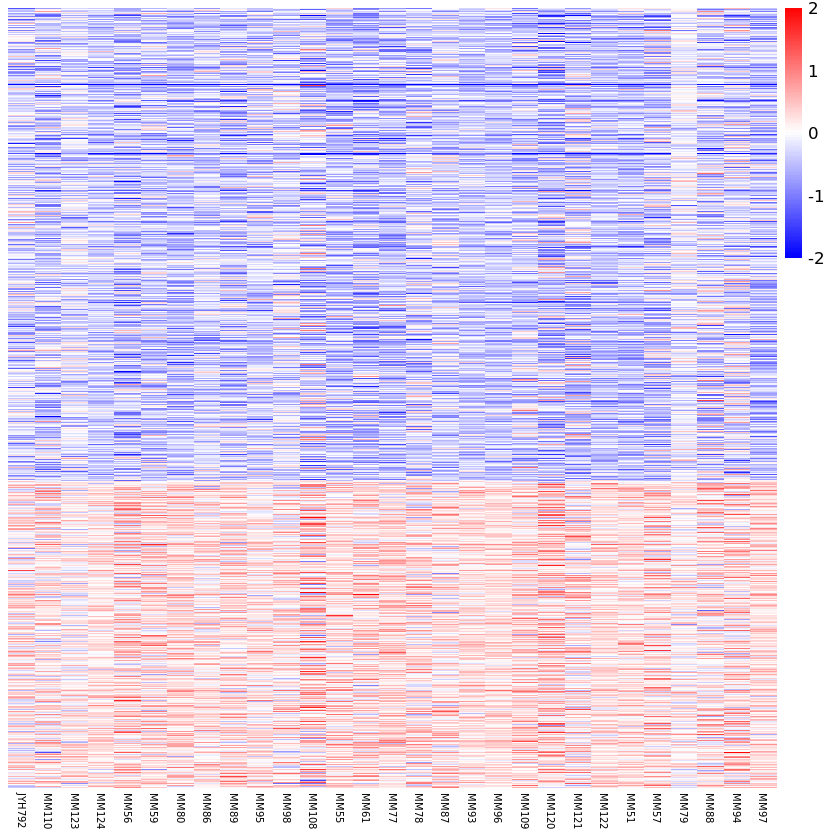

In [167]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R1=read.csv(paste0(wd_snATAC,'AI_beta_subtype.csv'))
R2=table(R1$donor,R1$subtype)

donor_name=rownames(R2)
donor_1=paste0(donor_name[R2[,1]>400 & R2[,2]>400],'_beta1')
donor_2=paste0(donor_name[R2[,1]>400 & R2[,2]>400],'_beta2')
donor_all=c(donor_1,donor_2)
length(donor_all)

C=read.csv(paste0(wd_snATAC,'ATAC_beta_subtype.csv'))
C1=as.matrix(C[,-1])
rownames(C1)=as.character(C$X)
C_all=C1[,(colnames(C1) %in% donor_all)]
dim(C_all)

######CPM normalization
C_norm=C_all
for (i in 1:dim(C_all)[2]){
    C_norm[,i]=(C_all[,i]/sum(C_all[,i]))*1000000
}
C_norm[1:3,1:3]

####### fold change
n_sample=0.5*dim(C_norm)[2]
C_fold=C_norm[,1:n_sample]
temp_name=gsub("_beta1",  '', colnames(C_norm[,1:n_sample]))
colnames(C_fold)=temp_name
for (i in 1:dim(C_fold)[2]){
    C_fold[,i]=log2((C_norm[,(n_sample+i)]+1)/(C_norm[,i]+1))
}

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[C$donor %in% colnames(C_fold),]
all(C$donor==colnames(C_fold))
C_fold1=C_fold[,order(C$Sample.Description.Name)]
C1=C[order(C$Sample.Description.Name),]
all(C1$donor==colnames(C_fold1))

th=0.05
D=read.csv(paste0(wd_snATAC,'Pairwise_biobank_ATAC_ttest.csv'))
temp_peak=as.character(D$X)
D_peak_up=temp_peak[(D$mean_beta1<D$mean_beta2) & (D$FDR<th)]
D_peak_down=temp_peak[(D$mean_beta1>D$mean_beta2) & (D$FDR<th)]

C_diff_up=C_fold1[(rownames(C_fold1) %in% D_peak_up),]
dim(C_diff_up)

C_diff_down=C_fold1[(rownames(C_fold1) %in% D_peak_down),]
dim(C_diff_down)

C_diff=rbind(C_diff_down,C_diff_up)

bk = unique(c(seq(-2,2, length=100)))
pheatmap(C_diff,scale='none',breaks=bk,show_rownames = FALSE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("blue",'white',"red"))(100))



## Correlation between ATAC and RNA (S Figure 7)

X    gene      mean_RNA_beta0 mean_RNA_beta1 pvalue_RNA   FDR_RNA     
12     12 A1CF       41.76454      19.31254       1.368000e-06 0.0008067429
1113 1113 ACTN1      71.02208      52.20655       1.202853e-05 0.0028644860
3891 3891 ARHGEF10L 105.32165      78.30540       1.197885e-05 0.0028644860
     peak                 mean_ATAC_beta0 mean_ATAC_beta1 pvalue_ATAC 
12   10:52643299-52643799 6.035342        2.840074        1.292982e-13
1113 14:69251127-69251627 7.291704        3.905486        2.186814e-08
3891 1:18008842-18009342  5.199078        4.030425        6.716925e-07
     FDR_ATAC     type    
12   1.076909e-09 enhancer
1113 1.421863e-05 enhancer
3891 1.910370e-04 enhancer

`geom_smooth()` using formula 'y ~ x'


[1] 85 14

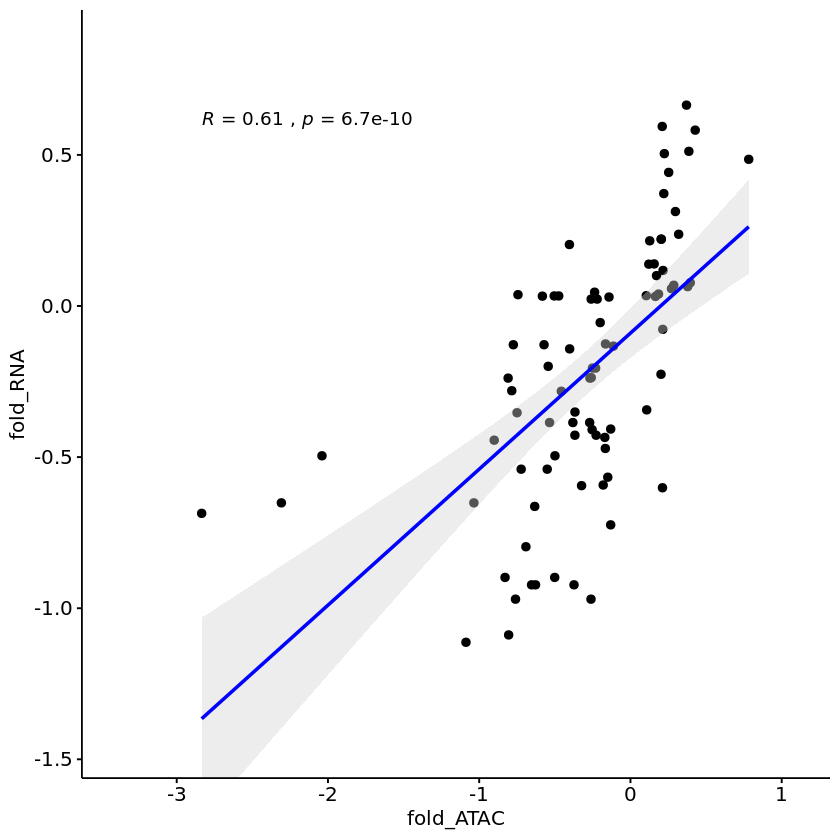

In [168]:
A=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
A1=A[!duplicated(A[,c(2,7)]),]
keep_fdr=(A1$FDR_ATAC<0.05 & (A1$type=='enhancer') & A1$FDR_RNA<0.15)
#keep_fdr=(A1$FDR_ATAC<0.05 & A1$FDR_RNA<0.15)

A2=A1[keep_fdr,]
A2[1:3,]
A2$fold_RNA=log2((A2$mean_RNA_beta1)/(A2$mean_RNA_beta0))
A2$fold_ATAC=log2((A2$mean_ATAC_beta1)/(A2$mean_ATAC_beta0))

D_min=min(A2$fold_ATAC)
D_max=max(A2$fold_ATAC)
R_min=min(A2$fold_RNA)
R_max=max(A2$fold_RNA)


p2 <- ggscatter(A2, x = "fold_ATAC", y = "fold_RNA",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.4*D_max),ylim = c(1.3*R_min,1.3*R_max))
dim(A2)


In [169]:
keep1=(A2$fold_RNA>0 & A2$fold_ATAC<0)
keep2=(A2$fold_RNA<0 & A2$fold_ATAC>0)
dim(A2)
dim(A2[keep1 | keep2,])

[1] 85 14

[1] 13 14

X  gene mean_RNA_beta0 mean_RNA_beta1 pvalue_RNA FDR_RNA     
8   8 A1CF 41.76454       19.31254       1.368e-06  0.0008067429
10 10 A1CF 41.76454       19.31254       1.368e-06  0.0008067429
11 11 A1CF 41.76454       19.31254       1.368e-06  0.0008067429
   peak                 mean_ATAC_beta0 mean_ATAC_beta1 pvalue_ATAC 
8  10:52592776-52593276 1.002009        0.4489659       2.463486e-05
10 10:52643996-52644496 2.468029        1.1434445       1.041509e-08
11 10:52645209-52645709 2.366425        1.2920695       3.102883e-08
   FDR_ATAC     type    
8  2.840504e-03 promoter
10 7.837611e-06 promoter
11 1.816770e-05 promoter

`geom_smooth()` using formula 'y ~ x'


[1] 544  14

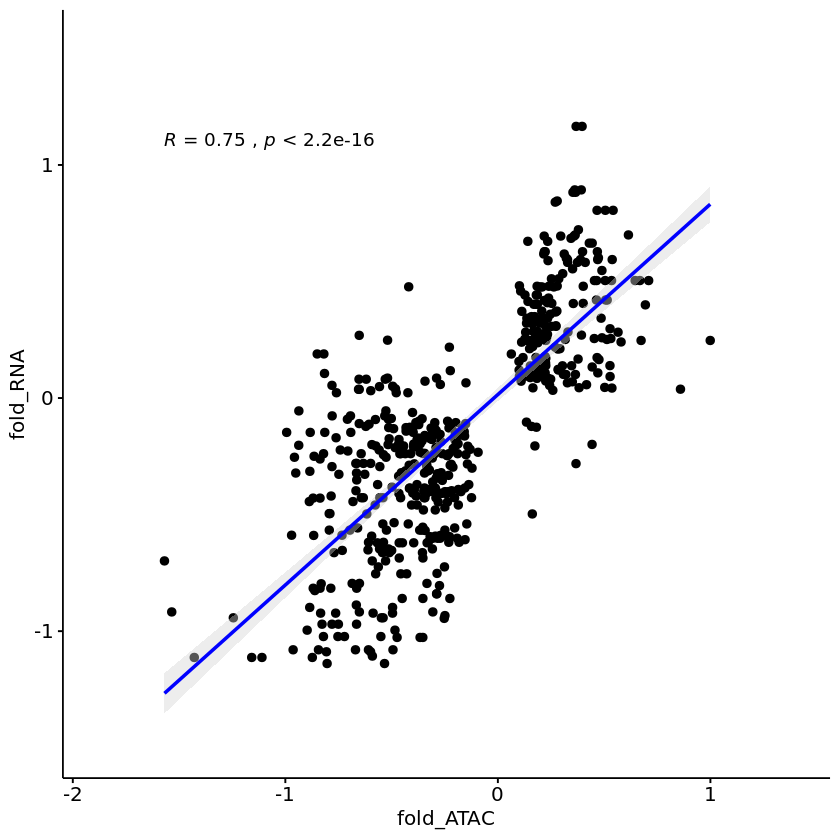

In [170]:
A=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
A1=A[!duplicated(A[,c(2,7)]),]
keep_fdr=(A1$FDR_ATAC<0.05 & (A1$type=='promoter') & A1$FDR_RNA<0.15)
#keep_fdr=(A1$FDR_ATAC<0.05 & A1$FDR_RNA<0.15)

A2=A1[keep_fdr,]
A2[1:3,]
A2$fold_RNA=log2((A2$mean_RNA_beta1)/(A2$mean_RNA_beta0))
A2$fold_ATAC=log2((A2$mean_ATAC_beta1)/(A2$mean_ATAC_beta0))

D_min=min(A2$fold_ATAC)
D_max=max(A2$fold_ATAC)
R_min=min(A2$fold_RNA)
R_max=max(A2$fold_RNA)


p2 <- ggscatter(A2, x = "fold_ATAC", y = "fold_RNA",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.4*D_max),ylim = c(1.3*R_min,1.3*R_max))
dim(A2)

In [171]:
keep1=(A2$fold_RNA>0 & A2$fold_ATAC<0)
keep2=(A2$fold_RNA<0 & A2$fold_ATAC>0)
dim(A2)
dim(A2[keep1 | keep2,])

[1] 544  14

[1] 33 14

## Differential genes between beta cell subtypes (Figure 3b)

[1] 40

[1] 18575    40

[1] TRUE

[1] TRUE

[1] 164

[1] 133

[1] 164  20

[1] 133  20

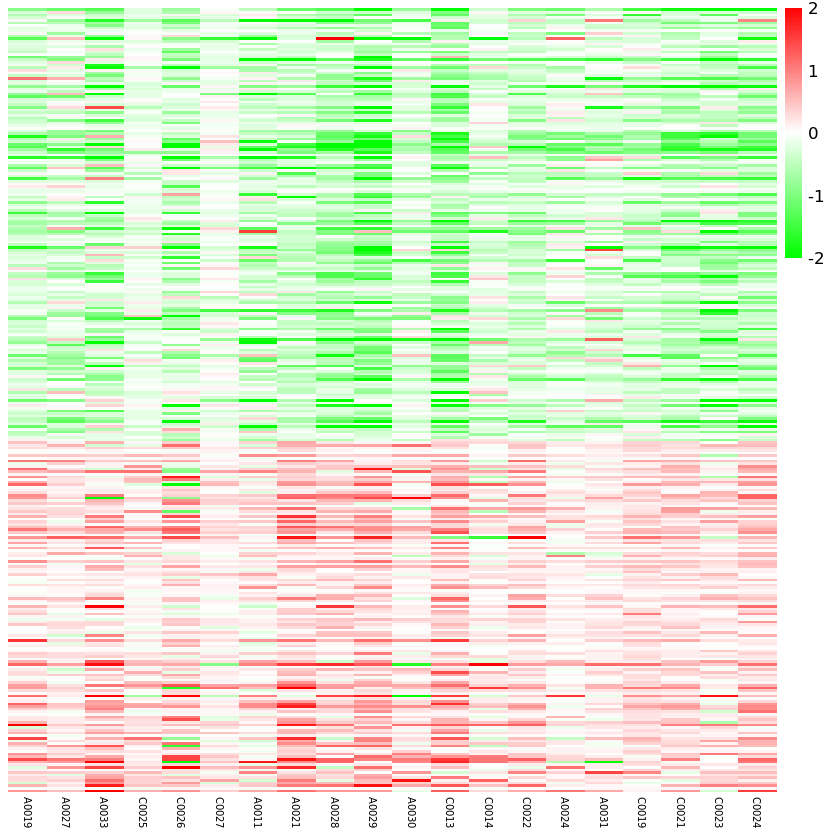

In [172]:
rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R1=read.csv(paste0(wd_multiome,'multiome_RNA_beta_subtype.csv'))
R2=table(R1$donor,R1$subtype)
donor_name=rownames(R2)

donor_1=paste0(donor_name,'_beta1')
donor_2=paste0(donor_name,'_beta2')
donor_all=c(donor_1,donor_2)
length(donor_all)

C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C1=as.matrix(C[,-1])
rownames(C1)=as.character(C$X)
C_norm=C1[,(colnames(C1) %in% donor_all)]
dim(C_norm)

####### fold change
n_sample=0.5*dim(C_norm)[2]
C_fold=C_norm[,1:n_sample]
temp_name=gsub("_beta1",  '', colnames(C_norm[,1:n_sample]))
colnames(C_fold)=temp_name
for (i in 1:dim(C_fold)[2]){
    C_fold[,i]=log2((C_norm[,(n_sample+i)]+1)/(C_norm[,i]+1))
}

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[C$Short.ID %in% colnames(C_fold),]
C=C[order(C$Short.ID),]
all(C$Short.ID==colnames(C_fold))
C_fold1=C_fold[,order(C$Sample.Description.Name)]
C1=C[order(C$Sample.Description.Name),]
all(C1$Short.ID==colnames(C_fold1))

A=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
A1=A[!duplicated(A[,c(2,7)]),]
A1$fold_RNA=log2((A1$mean_RNA_beta1+1)/(A1$mean_RNA_beta0+1))
A1$fold_ATAC=log2((A1$mean_ATAC_beta1+1)/(A1$mean_ATAC_beta0+1))

##################
## condition
keep_fdr=(A1$FDR_ATAC<0.05 & A1$FDR_RNA<0.15)
keep1=(A1$fold_RNA>0 & A1$fold_ATAC>0)
keep2=(A1$fold_RNA<0 & A1$fold_ATAC<0)

A_gene=as.character(A1$gene)
gene_up=unique(A_gene[keep_fdr & keep1])
gene_down=unique(A_gene[keep_fdr & keep2])
length(gene_down)
length(gene_up)

#####
C_diff_down=C_fold1[(rownames(C_fold1) %in% gene_down),]
dim(C_diff_down)

C_diff_up=C_fold1[(rownames(C_fold1) %in% gene_up),]
dim(C_diff_up)

C_diff=rbind(C_diff_down,C_diff_up)

bk = unique(c(seq(-2,2, length=100)))
pheatmap(C_diff,scale='none',breaks=bk,show_rownames = FALSE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("green",'white',"red"))(100))


## Representative differential genes (Figure 3c)

In [173]:
rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R1=read.csv(paste0(wd_snATAC,'AI_beta_subtype.csv'))
R2=table(R1$donor,R1$subtype)

donor_name=rownames(R2)
donor_1=paste0(donor_name[R2[,1]>400 & R2[,2]>400],'_beta1')
donor_2=paste0(donor_name[R2[,1]>400 & R2[,2]>400],'_beta2')
donor_all=c(donor_1,donor_2)
length(donor_all)

C=read.csv(paste0(wd_snATAC,'ATAC_beta_subtype.csv'))
C1=as.matrix(C[,-1])
rownames(C1)=as.character(C$X)
C_all=C1[,(colnames(C1) %in% donor_all)]
dim(C_all)

######CPM normalization
C_norm_ATAC=C_all
for (i in 1:dim(C_all)[2]){
    C_norm_ATAC[,i]=(C_all[,i]/sum(C_all[,i]))*1000000
}

R1=read.csv(paste0(wd_multiome,'multiome_RNA_beta_subtype.csv'))
R2=table(R1$donor,R1$subtype)
donor_name=rownames(R2)

donor_1=paste0(donor_name,'_beta1')
donor_2=paste0(donor_name,'_beta2')
donor_all=c(donor_1,donor_2)
length(donor_all)

C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C1=as.matrix(C[,-1])
rownames(C1)=as.character(C$X)
C_norm_RNA=C1[,(colnames(C1) %in% donor_all)]
dim(C_norm_RNA)


[1] 58

[1] 229520     58

[1] 40

[1] 18575    40

[1] "11:2182331-2182831"


	Paired t-test

data:  beta_1 and beta_2
t = -4.8331, df = 28, p-value = 4.377e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.995615 -1.616891
sample estimates:
mean of the differences 
              -2.806253 


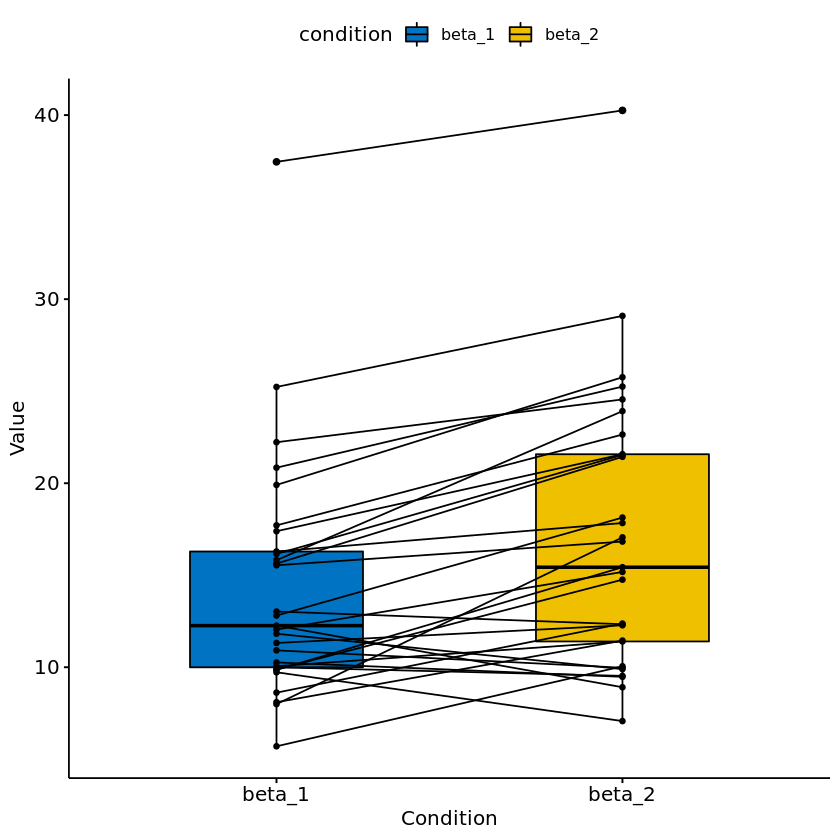

In [174]:
## INS
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.05 & D$FDR_RNA<0.15)
D1=D[keep_fdr,]
gene_test='INS'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[2]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")


	Paired t-test

data:  beta_1 and beta_2
t = -3.317, df = 19, p-value = 0.003624
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -86.12283 -19.48433
sample estimates:
mean of the differences 
              -52.80358 


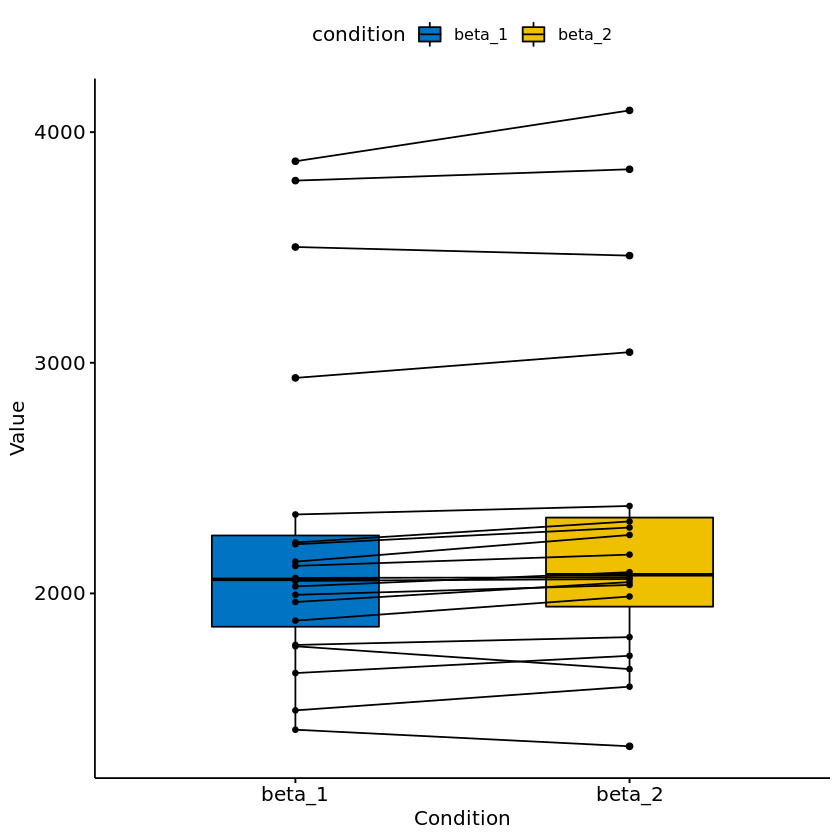

In [175]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "12:79257483-79257983"


	Paired t-test

data:  beta_1 and beta_2
t = -4.2279, df = 28, p-value = 0.0002275
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.007429 -0.697086
sample estimates:
mean of the differences 
              -1.352257 


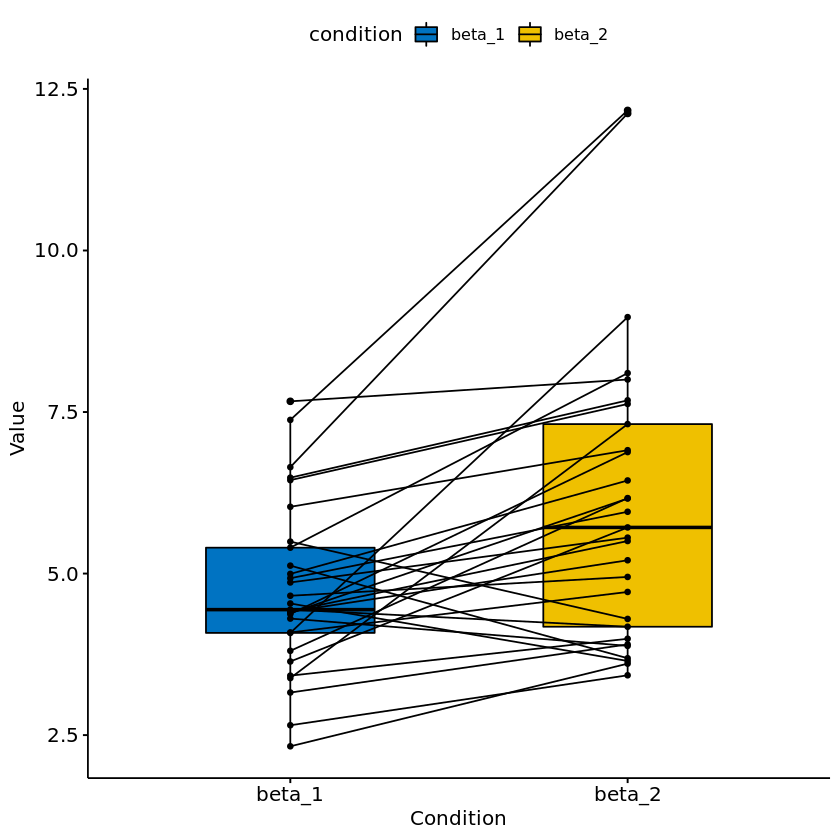

In [176]:
## SYT1
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.05 & D$FDR_RNA<0.15)
D1=D[keep_fdr,]
gene_test='SYT1'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")


	Paired t-test

data:  beta_1 and beta_2
t = -4.2933, df = 19, p-value = 0.0003923
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -16.13464  -5.55881
sample estimates:
mean of the differences 
              -10.84672 


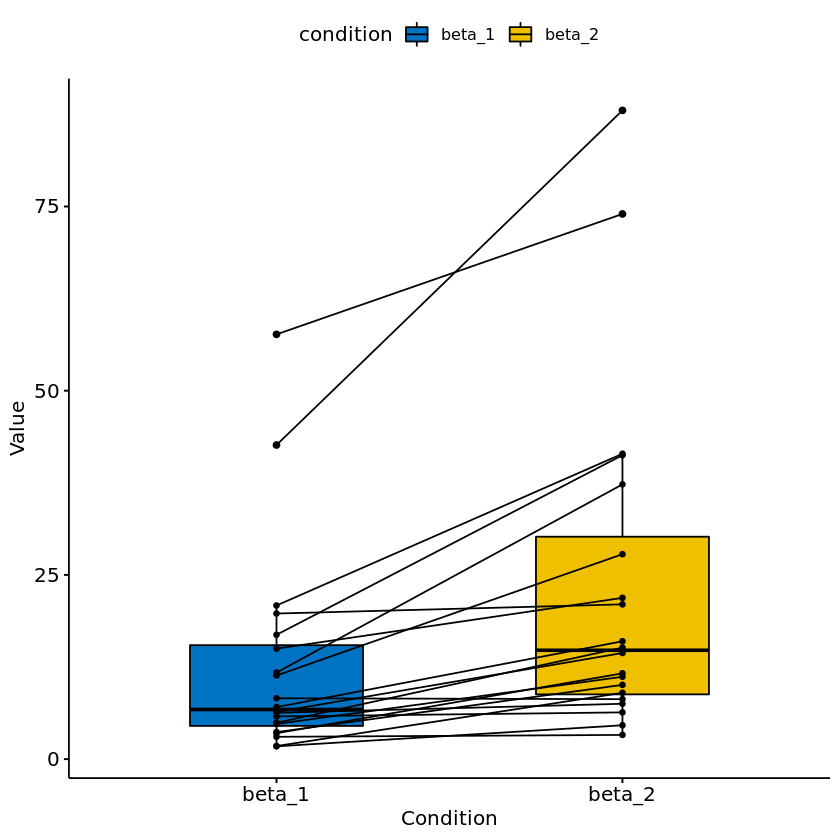

In [177]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "7:44190078-44190578"


	Paired t-test

data:  beta_1 and beta_2
t = -4.2752, df = 28, p-value = 0.0002001
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.535133 -1.244852
sample estimates:
mean of the differences 
              -2.389992 


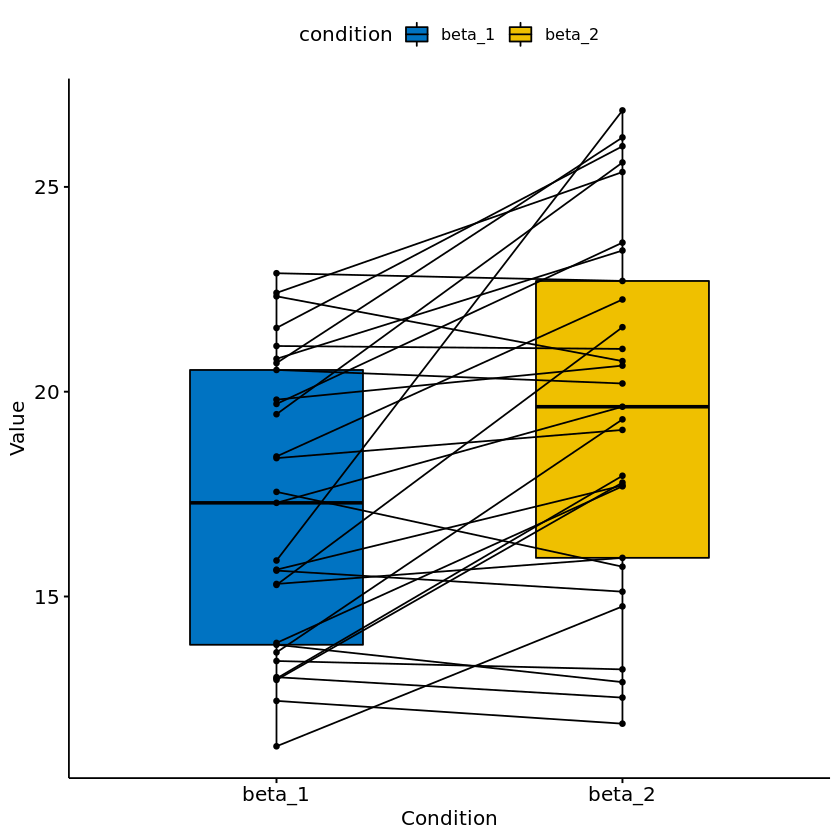

In [178]:
## GCK
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.05 & D$FDR_RNA<0.15)
D1=D[keep_fdr,]
gene_test='GCK'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")


	Paired t-test

data:  beta_1 and beta_2
t = -5.3313, df = 19, p-value = 3.814e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18.497070  -8.067828
sample estimates:
mean of the differences 
              -13.28245 


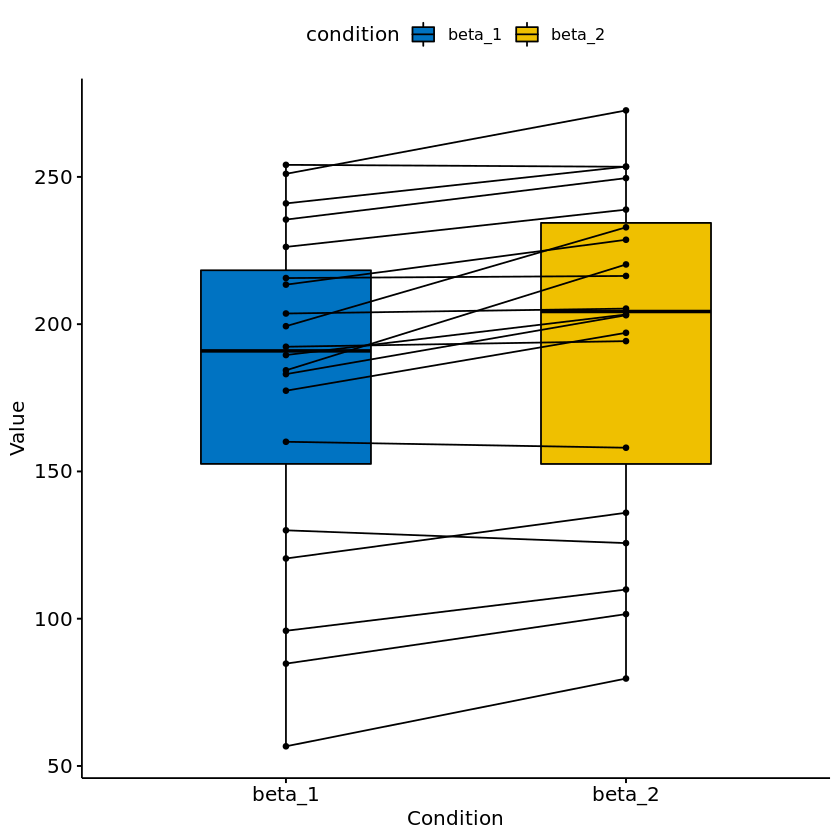

In [179]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "11:31847583-31848083"


	Paired t-test

data:  beta_1 and beta_2
t = -4.2907, df = 28, p-value = 0.0001919
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.870997 -1.015527
sample estimates:
mean of the differences 
              -1.943262 


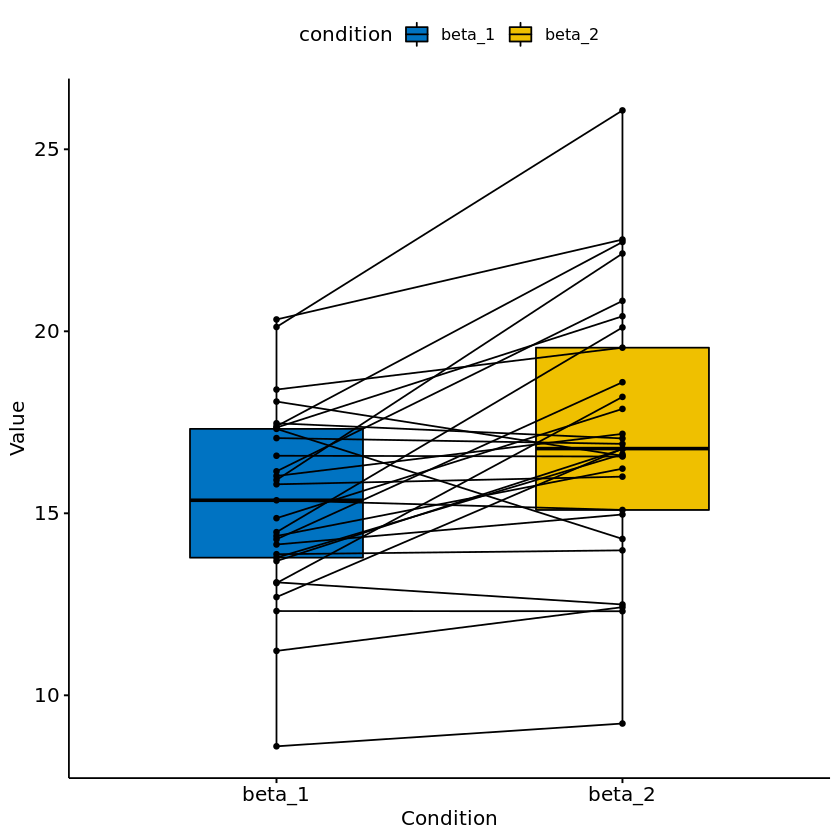

In [180]:
## PAX6
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.05 & D$FDR_RNA<0.15)
D1=D[keep_fdr,]
gene_test='PAX6'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")


	Paired t-test

data:  beta_1 and beta_2
t = -3.8016, df = 19, p-value = 0.001205
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -6.803750 -1.972058
sample estimates:
mean of the differences 
              -4.387904 


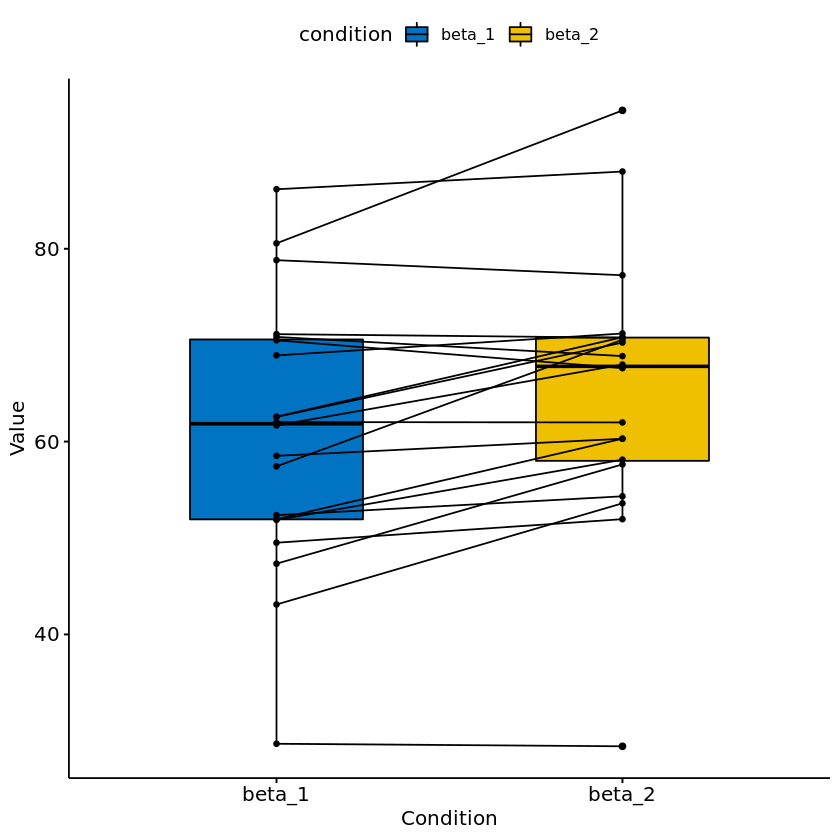

In [181]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

# Validation beta cell subtypes using independent data sets (S Figure 8)

[1] 164

[1] 133

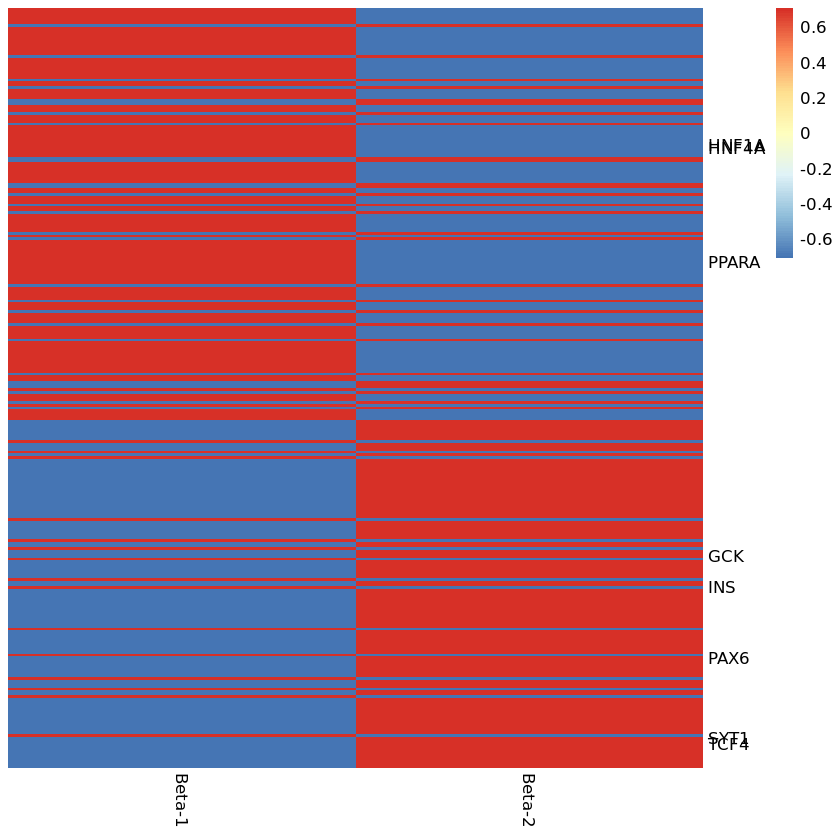

In [3]:
## Cohort 1:
### Segerstolpe, A. et al. Single-Cell Transcriptome Profiling of Human Pancreatic Islets in Health and Type 2 Diabetes. Cell Metab 24, 593-607 (2016).

rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A = read.csv(paste0(wd_multiome,'scRNA_Segbeta_TPM.csv')) 
A1 = as.matrix(A[,-1])
rownames(A1) = as.character(A$X)
A_norm1 = A1[apply(A1,1,mean)>0,]

A=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
A1=A[!duplicated(A[,c(2,7)]),]
A1$fold_RNA=log2((A1$mean_RNA_beta1+1)/(A1$mean_RNA_beta0+1))
A1$fold_ATAC=log2((A1$mean_ATAC_beta1+1)/(A1$mean_ATAC_beta0+1))
##################
## condition
keep_fdr=(A1$FDR_ATAC<0.05 & A1$FDR_RNA<0.15)
keep1=(A1$fold_RNA>0 & A1$fold_ATAC>0)
keep2=(A1$fold_RNA<0 & A1$fold_ATAC<0)

A_gene=as.character(A1$gene)
gene_up=unique(A_gene[keep_fdr & keep1])
gene_down=unique(A_gene[keep_fdr & keep2])
length(gene_down)
length(gene_up)

#####
C_diff_down=A_norm1[(rownames(A_norm1) %in% gene_down),]
C_diff_up=A_norm1[(rownames(A_norm1) %in% gene_up),]
C_diff=rbind(C_diff_down,C_diff_up)

temp = rownames(C_diff)
temp[!(temp %in% c('INS','GCK','HNF1A','TCF4','HNF4A','PAX6','HNF4G','PPARA','SYT1'))]=''
rownames(C_diff)=temp

colnames(C_diff) = c('Beta-1','Beta-2')
pheatmap(C_diff,scale='row',cluster_rows=FALSE,cluster_cols=FALSE,show_rownames = TRUE)


[1] TRUE

[1] 100

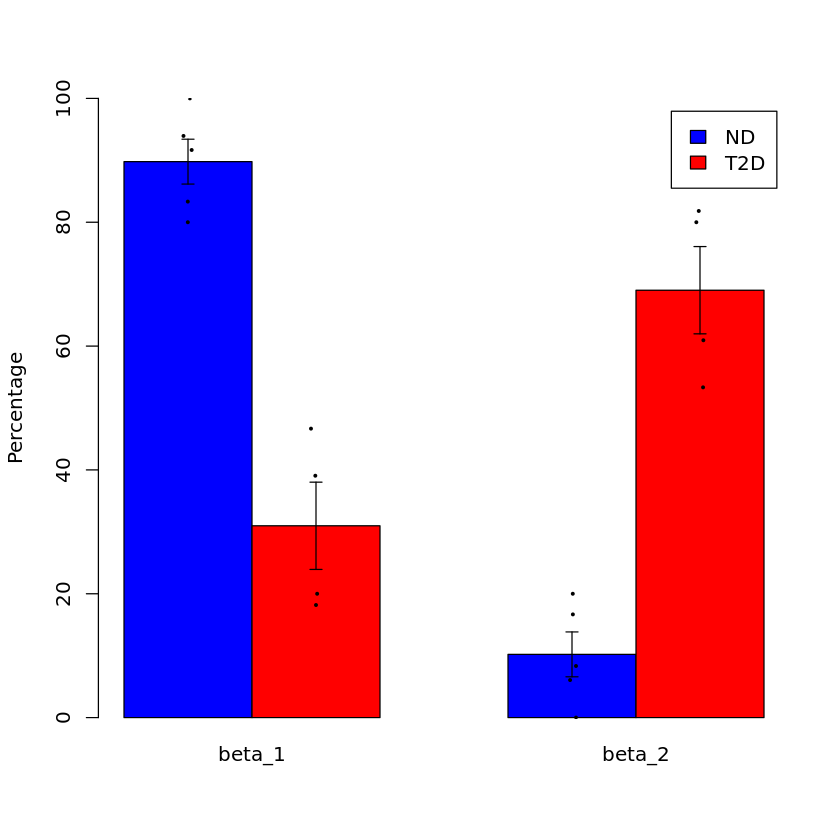

In [4]:
rm(list=ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R = read.csv(paste0(wd_multiome,'scRNA_Segbeta_anno.csv')) 
R = R[R$leiden %in% c(0,1),]

S = table(R$donor,R$leiden)
S1 = t(as.matrix(S))
rownames(S1) = c('beta_1','beta_2')
S2 = S1
for (i in 1:dim(S1)[2]){
    S2[,i] = (S1[,i]/sum(S1[,i]))*100
}

S3 = t(S2)
M = read.csv(paste0(wd_multiome,'Seg_meta_unique.csv')) 
S4=S3[order(M$disease),]
M1=M[order(M$disease),]
all(rownames(S4) == as.character(M1$donor))
M1$beta_1 = S4[,1]
M1$beta_2 = S4[,2]
M1 = M1[!(as.character(M1$donor) %in% c('HP1506401')),] ## exclude 1 pre-T2D donor

A_mean=aggregate(cbind(beta_1,beta_2) ~ disease , data=M1, mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 100

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}
stdev <- aggregate(cbind(beta_1,beta_2) ~ disease, data=M1, sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(M1$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

A_ND = M1[M1$disease == 'ND',]
A_T2D = M1[M1$disease == 'T2D',]

n1 = as.numeric(A_ND$beta_1)
n2 = as.numeric(A_T2D$beta_1)
n3 = as.numeric(A_ND$beta_2)
n4 = as.numeric(A_T2D$beta_2)

y = c(n1,n2,n3,n4)
max(y)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(4.5,length(n3)),rep(5.5,length(n4)))
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean[,c(1:2)], beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:2)], stdev[,c(1:2)])
points(x,y,bg = 'grey',pch=19,cex=0.3)

[1] 164

[1] 133

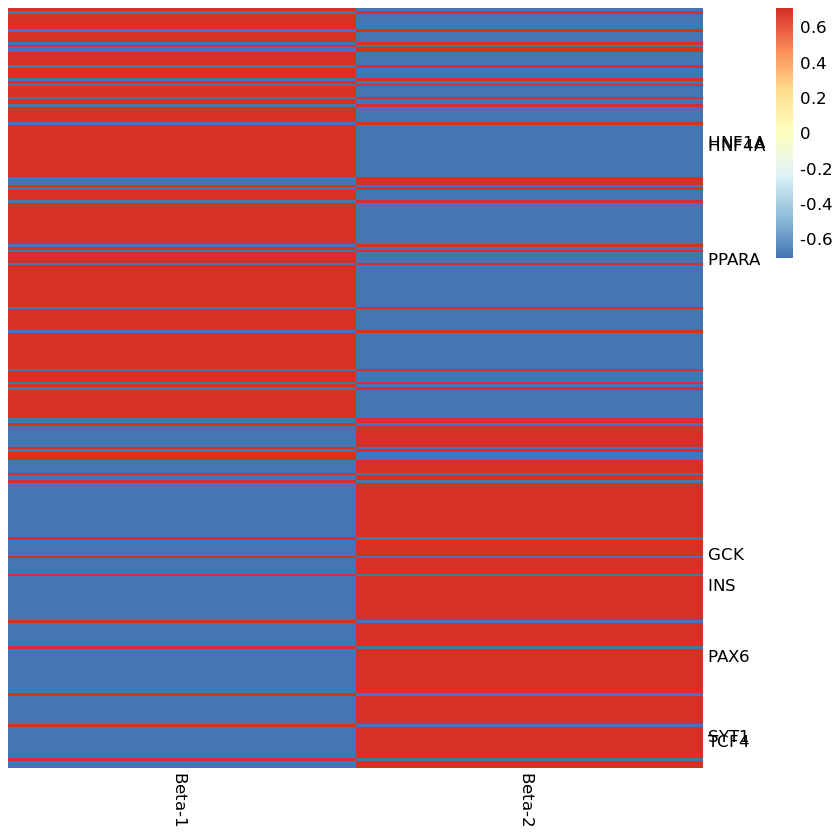

In [5]:
## Cohort 2:
### Xin, Y. et al. RNA Sequencing of Single Human Islet Cells Reveals Type 2 Diabetes Genes. Cell Metab 24, 608-615 (2016)

rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A = read.csv(paste0(wd_multiome,'scRNA_Xin2016beta_TPM.csv')) 
A1 = as.matrix(A[,-1])
rownames(A1) = as.character(A$X)
A_norm1 = A1[apply(A1,1,mean)>0,]

A=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
A1=A[!duplicated(A[,c(2,7)]),]
A1$fold_RNA=log2((A1$mean_RNA_beta1+1)/(A1$mean_RNA_beta0+1))
A1$fold_ATAC=log2((A1$mean_ATAC_beta1+1)/(A1$mean_ATAC_beta0+1))
##################
## condition
keep_fdr=(A1$FDR_ATAC<0.05 & A1$FDR_RNA<0.15)
keep1=(A1$fold_RNA>0 & A1$fold_ATAC>0)
keep2=(A1$fold_RNA<0 & A1$fold_ATAC<0)

A_gene=as.character(A1$gene)
gene_up=unique(A_gene[keep_fdr & keep1])
gene_down=unique(A_gene[keep_fdr & keep2])
length(gene_down)
length(gene_up)

#####
C_diff_down=A_norm1[(rownames(A_norm1) %in% gene_down),]
C_diff_up=A_norm1[(rownames(A_norm1) %in% gene_up),]
C_diff=rbind(C_diff_down,C_diff_up)

temp = rownames(C_diff)
temp[!(temp %in% c('INS','GCK','HNF1A','TCF4','HNF4A','PAX6','HNF4G','PPARA','SYT1'))]=''
rownames(C_diff)=temp

colnames(C_diff) = c('Beta-1','Beta-2')
pheatmap(C_diff,scale='row',cluster_rows=FALSE,cluster_cols=FALSE,show_rownames = TRUE)


[1] TRUE

[1] 100

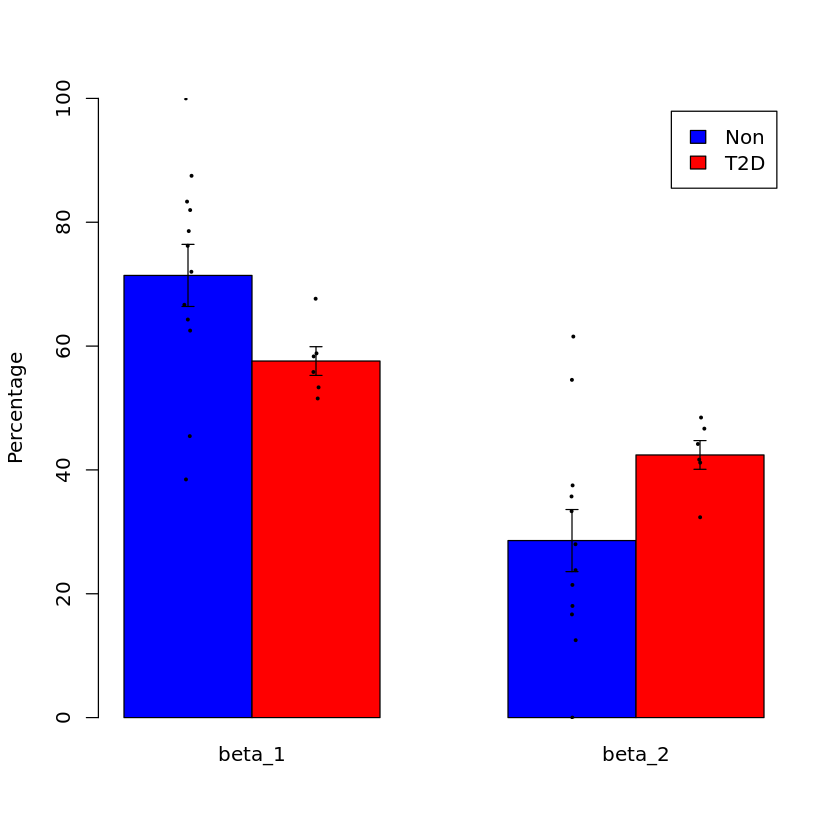

In [11]:
rm(list=ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R = read.csv(paste0(wd_multiome,'scRNA_Xin2016beta_anno.csv')) 
R = R[R$leiden %in% c(0,1),]

S = table(R$donor,R$leiden)
S1 = t(as.matrix(S))
rownames(S1) = c('beta_1','beta_2')
S2 = S1
for (i in 1:dim(S1)[2]){
    S2[,i] = (S1[,i]/sum(S1[,i]))*100
}

S3 = t(S2)
M = read.csv(paste0(wd_multiome,'Xin_meta.csv')) 
S4=S3[order(M$disease),]
M1=M[order(M$disease),]
all(rownames(S4) == as.character(M1$donor))
M1$beta_1 = S4[,1]
M1$beta_2 = S4[,2]


A_mean=aggregate(cbind(beta_1,beta_2) ~ disease , data=M1, mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 100

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}
stdev <- aggregate(cbind(beta_1,beta_2) ~ disease, data=M1, sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(M1$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

A_ND = M1[M1$disease == 'Non',]
A_T2D = M1[M1$disease == 'T2D',]

n1 = as.numeric(A_ND$beta_1)
n2 = as.numeric(A_T2D$beta_1)
n3 = as.numeric(A_ND$beta_2)
n4 = as.numeric(A_T2D$beta_2)

y = c(n1,n2,n3,n4)
max(y)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(4.5,length(n3)),rep(5.5,length(n4)))
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean[,c(1:2)], beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:2)], stdev[,c(1:2)])
points(x,y,bg = 'grey',pch=19,cex=0.3)

[1] 164

[1] 133

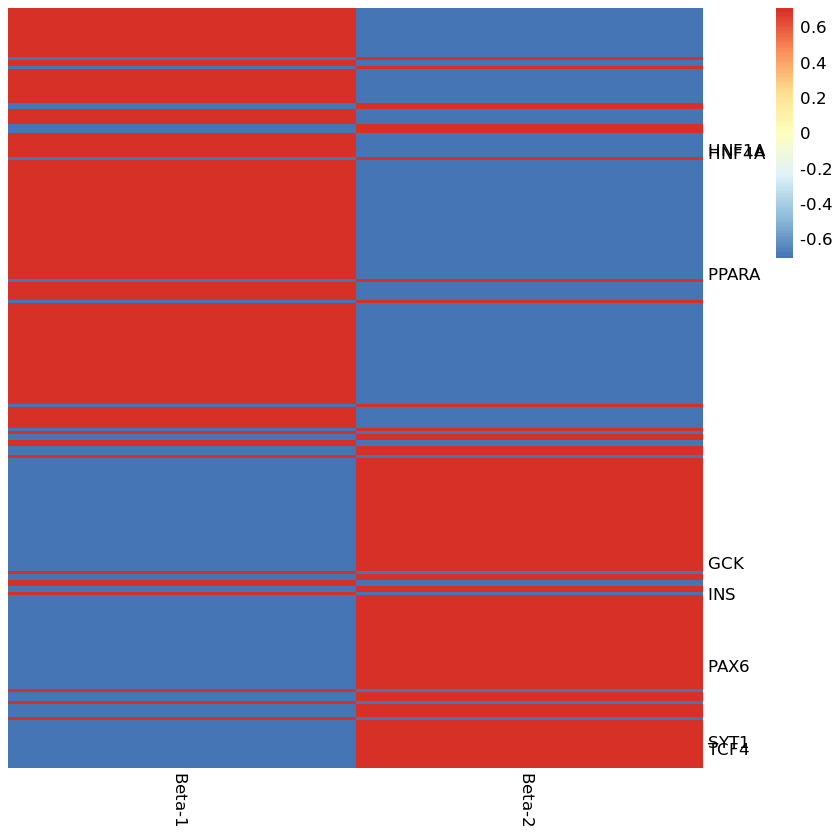

In [7]:
## Cohort 3:
###Xin, Y. et al. Pseudotime Ordering of Single Human beta-Cells Reveals States of Insulin Production and Unfolded Protein Response. Diabetes 67, 1783-1794 (2018).

rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A = read.csv(paste0(wd_multiome,'scRNA_Xin2018beta_TPM.csv')) 
A1 = as.matrix(A[,-1])
rownames(A1) = as.character(A$X)
A_norm1 = A1[apply(A1,1,mean)>0,]

A=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
A1=A[!duplicated(A[,c(2,7)]),]
A1$fold_RNA=log2((A1$mean_RNA_beta1+1)/(A1$mean_RNA_beta0+1))
A1$fold_ATAC=log2((A1$mean_ATAC_beta1+1)/(A1$mean_ATAC_beta0+1))
##################
## condition
keep_fdr=(A1$FDR_ATAC<0.05 & A1$FDR_RNA<0.15)
keep1=(A1$fold_RNA>0 & A1$fold_ATAC>0)
keep2=(A1$fold_RNA<0 & A1$fold_ATAC<0)

A_gene=as.character(A1$gene)
gene_up=unique(A_gene[keep_fdr & keep1])
gene_down=unique(A_gene[keep_fdr & keep2])
length(gene_down)
length(gene_up)

#####
C_diff_down=A_norm1[(rownames(A_norm1) %in% gene_down),]
C_diff_up=A_norm1[(rownames(A_norm1) %in% gene_up),]
C_diff=rbind(C_diff_down,C_diff_up)

temp = rownames(C_diff)
temp[!(temp %in% c('INS','GCK','HNF1A','TCF4','HNF4A','PAX6','HNF4G','PPARA','SYT1'))]=''
rownames(C_diff)=temp

colnames(C_diff) = c('Beta-1','Beta-2')
pheatmap(C_diff,scale='row',cluster_rows=FALSE,cluster_cols=FALSE,show_rownames = TRUE)


[1] 95.83333

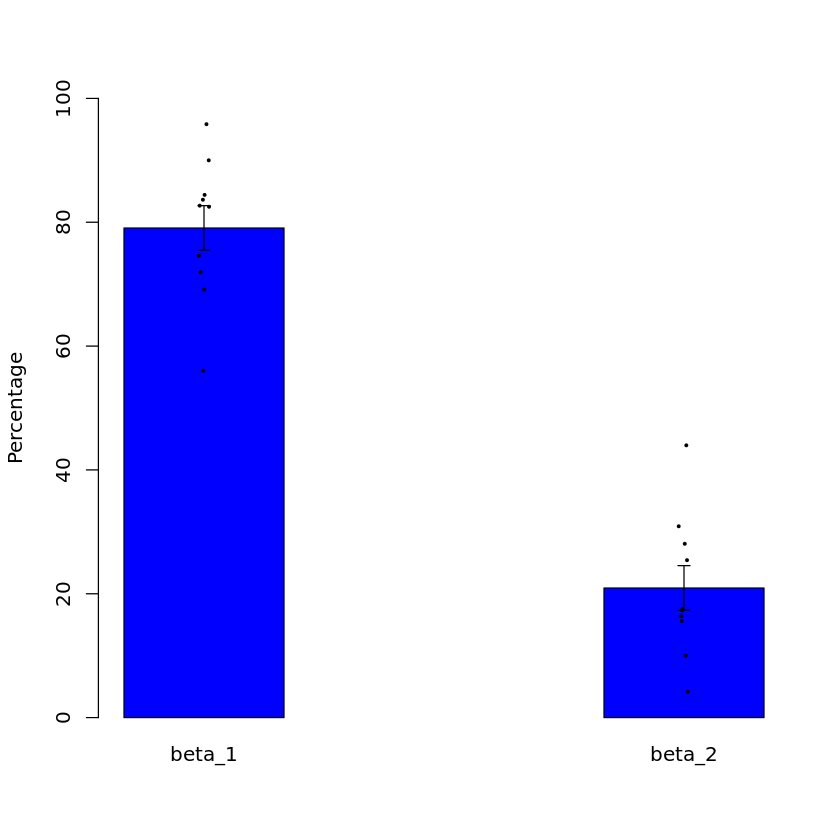

In [8]:
rm(list=ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R = read.csv(paste0(wd_multiome,'scRNA_Xin2018beta_anno.csv')) 
R = R[R$leiden %in% c(0,1),]

S = table(R$donor,R$leiden)
S1 = t(as.matrix(S))
rownames(S1) = c('beta_1','beta_2')
S2 = S1
for (i in 1:dim(S1)[2]){
    S2[,i] = (S1[,i]/sum(S1[,i]))*100
}

M= matrix(0,10,2)
colnames(M) = c('beta_1','beta_2')
M[,1] = S2[1,]
M[,2] = S2[2,]
M1 = as.data.frame(M)
M1$disease = 'ND'

A_mean=aggregate(cbind(beta_1,beta_2) ~ disease , data=M1, mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 100

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}
stdev <- aggregate(cbind(beta_1,beta_2) ~ disease, data=M1, sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(M1$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}


n1 = as.numeric(M1$beta_1)
n2 = as.numeric(M1$beta_2)
y = c(n1,n2)
max(y)

x = c(rep(1.5,length(n1)),rep(4.5,length(n2))) 
x = x + 0.02*rnorm(length(x))

ze_barplot <- barplot(A_mean[,c(1:2)], beside=TRUE ,space=c(2,1),legend.text=FALSE,col=c("blue",'blue'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:2)], stdev[,c(1:2)])
points(x,y,bg = 'grey',pch=19,cex=0.3)

[1] 164

[1] 133

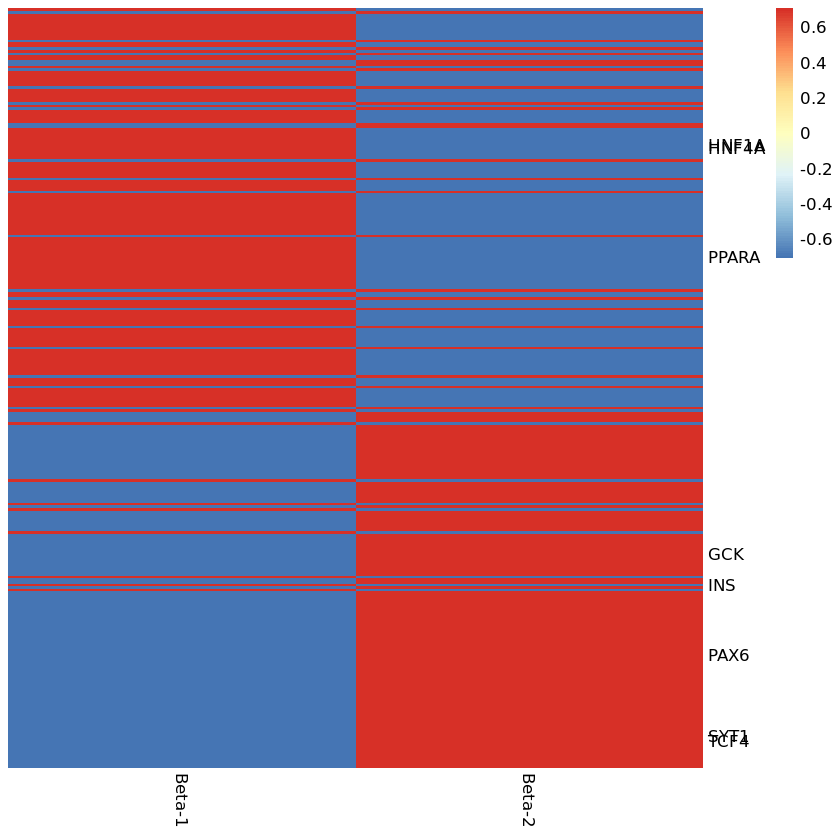

In [9]:
## Patch-seq Cohort
rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A = read.csv(paste0(wd_multiome,'patch_TPM.csv')) 
A1 = as.matrix(A[,-1])
rownames(A1) = as.character(A$X)
A_norm1 = A1[apply(A1,1,mean)>0,]

A=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
A1=A[!duplicated(A[,c(2,7)]),]
A1$fold_RNA=log2((A1$mean_RNA_beta1+1)/(A1$mean_RNA_beta0+1))
A1$fold_ATAC=log2((A1$mean_ATAC_beta1+1)/(A1$mean_ATAC_beta0+1))
##################
## condition
keep_fdr=(A1$FDR_ATAC<0.05 & A1$FDR_RNA<0.15)
keep1=(A1$fold_RNA>0 & A1$fold_ATAC>0)
keep2=(A1$fold_RNA<0 & A1$fold_ATAC<0)

A_gene=as.character(A1$gene)
gene_up=unique(A_gene[keep_fdr & keep1])
gene_down=unique(A_gene[keep_fdr & keep2])
length(gene_down)
length(gene_up)

#####
C_diff_down=A_norm1[(rownames(A_norm1) %in% gene_down),]
C_diff_up=A_norm1[(rownames(A_norm1) %in% gene_up),]
C_diff=rbind(C_diff_down,C_diff_up)

temp = rownames(C_diff)
temp[!(temp %in% c('INS','GCK','HNF1A','TCF4','HNF4A','PAX6','HNF4G','PPARA','SYT1'))]=''
rownames(C_diff)=temp

colnames(C_diff) = c('Beta-1','Beta-2')
pheatmap(C_diff,scale='row',cluster_rows=FALSE,cluster_cols=FALSE,show_rownames = TRUE)


[1] TRUE

[1] 100

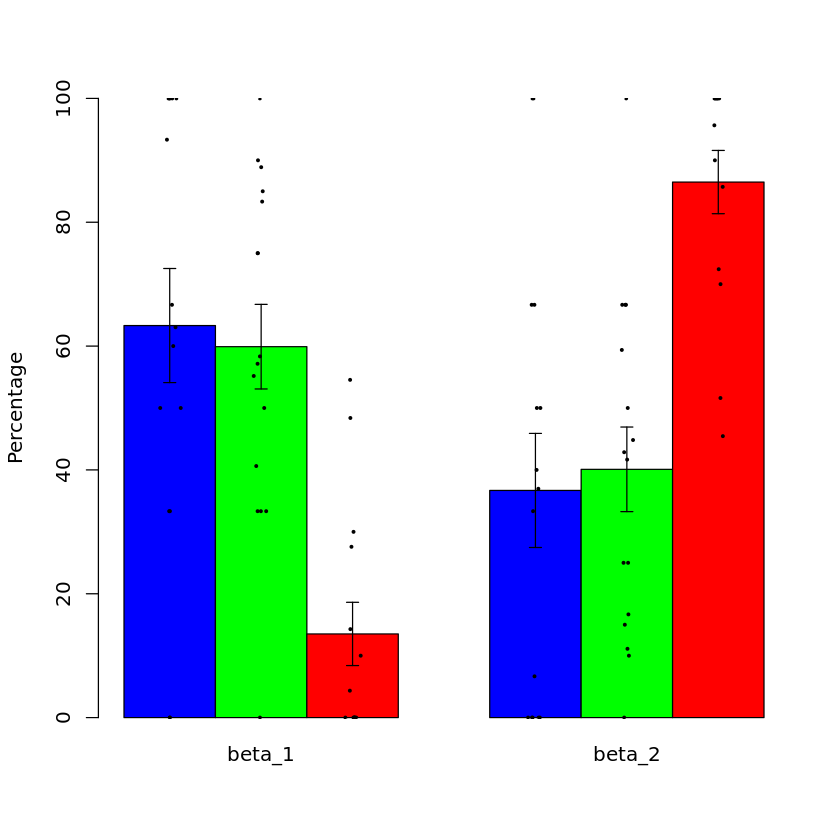

In [10]:
rm(list=ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R = read.csv(paste0(wd_multiome,'patch_meta_leiden.csv')) 
R$donor = R$Donor.ID
R = R[R$leiden %in% c(0,1),]
S = table(R$donor,R$leiden)
S1 = t(as.matrix(S))
rownames(S1) = c('beta_1','beta_2')
S2 = S1
for (i in 1:dim(S1)[2]){
  S2[,i] = (S1[,i]/sum(S1[,i]))*100
}
S3 = t(S2)

M = read.csv(paste0(wd_multiome,'patch_metadata.csv')) 
M$donor = M$Donor.ID
M = M[!(as.character(M$donor) %in% c('HP1506401')),]
S4=S3[rownames(S3),]
M1=M[order(M$donor),]
all(rownames(S4) == as.character(M1$donor))

M1$beta_1 = S4[,1]
M1$beta_2 = S4[,2]

A_mean=aggregate(cbind(beta_1,beta_2) ~ disease , data=M1, mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 100

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}
stdev <- aggregate(cbind(beta_1,beta_2) ~ disease, data=M1, sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(M1$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
  temp_num=length(name[name==group[i]])
  stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

C = M1
R_N = C[C$disease=='ND',]
R_P = C[C$disease=='PD',]
R_T = C[C$disease=='T2D',]

n1 = as.numeric(R_N$beta_1)
n2 = as.numeric(R_P$beta_1)
n3 = as.numeric(R_T$beta_1)
n4 = as.numeric(R_N$beta_2)
n5 = as.numeric(R_P$beta_2)
n6 = as.numeric(R_T$beta_2)
y = c(n1,n2,n3,n4,n5,n6)
max(y)

x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3)), rep(5.5,length(n4)),rep(6.5,length(n5)),rep(7.5,length(n6))) 
x = x + 0.04*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=FALSE,col=c("blue",'green','red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)

# Functional difference between beta cell subtypes (Patch-seq) 

In [40]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R_meta = read.csv(paste0(wd_multiome,'patch_meta_leiden.csv')) 
R_meta$test=paste0(R_meta$subtype,'_',R_meta$Glucose_mM)
R_meta[1:2,]
table(R_meta$subtype,R_meta$Diabetes.Status)
table(R_meta$subtype,R_meta$Glucose_mM)

#max(R_meta$NormalizedTotalCapacitance_fF.pF,na.rm=TRUE)
#max(R_meta$NormalizedFirstDepolarizationCapacitance_fF.pF,na.rm=TRUE)
#max(R_meta$NormalizedLateDepolarizationCapacitance,na.rm=TRUE)
#min(R_meta$NormalizedTotalCapacitance_fF.pF,na.rm=TRUE)
#min(R_meta$NormalizedFirstDepolarizationCapacitance_fF.pF,na.rm=TRUE)
#min(R_meta$NormalizedLateDepolarizationCapacitance,na.rm=TRUE)

temp=as.numeric(R_meta$NormalizedTotalCapacitance_fF.pF)
temp_sort=sort(temp)
temp_max=max(temp_sort[floor(0.98*length(temp))],0)
temp[temp>temp_max]=NA
temp[temp<0]=NA
R_meta$Total.exocytosis=temp

temp=as.numeric(R_meta$NormalizedFirstDepolarizationCapacitance_fF.pF)
temp_sort=sort(temp)
temp_max=max(temp_sort[floor(0.98*length(temp))],0)
temp[temp>temp_max]=NA
temp[temp<0]=NA
R_meta$Early.exocytosis=temp

temp=as.numeric(R_meta$NormalizedLateDepolarizationCapacitance)
temp_sort=sort(temp)
temp_max=max(temp_sort[floor(0.98*length(temp))],0)
temp[temp>temp_max]=NA
temp[temp<0]=NA
R_meta$Late.exocytosis=temp


X.1 X Index plate_XQ Donor.ID Age Sex    Diabetes.Status HbA1c BMI  ⋯
1 1   1 X1    M-2      AGAH468  43  Male   T2D             7     37.3 ⋯
2 2   2 X2    M-2      AGAL381  52  Female T2D             7     21.9 ⋯
  HalfInactivationSodiumCurrent_mV NormalizedEarlyPeakCaCurrentAmplitude_pA.pF
1 -47.5                            -5.458248                                  
2 -40.9                            -5.309168                                  
  NormalizedLateCaCurrentAmplitude_pA.pF ReversalPotentialbyramp_mV batch
1 -3.197556                               NA                        A    
2 -2.260128                              1.2                        A    
  ID                      leiden subtype disease test   
1 X1_AGAH468_T2D_Male_5   1      beta2   T2D     beta2_5
2 X2_AGAL381_T2D_Female_5 1      beta2   T2D     beta2_5

       
         ND T2D
  beta1 185  42
  beta2 116 146

       
          1   5  10
  beta1  33 102  92
  beta2  31 157  74

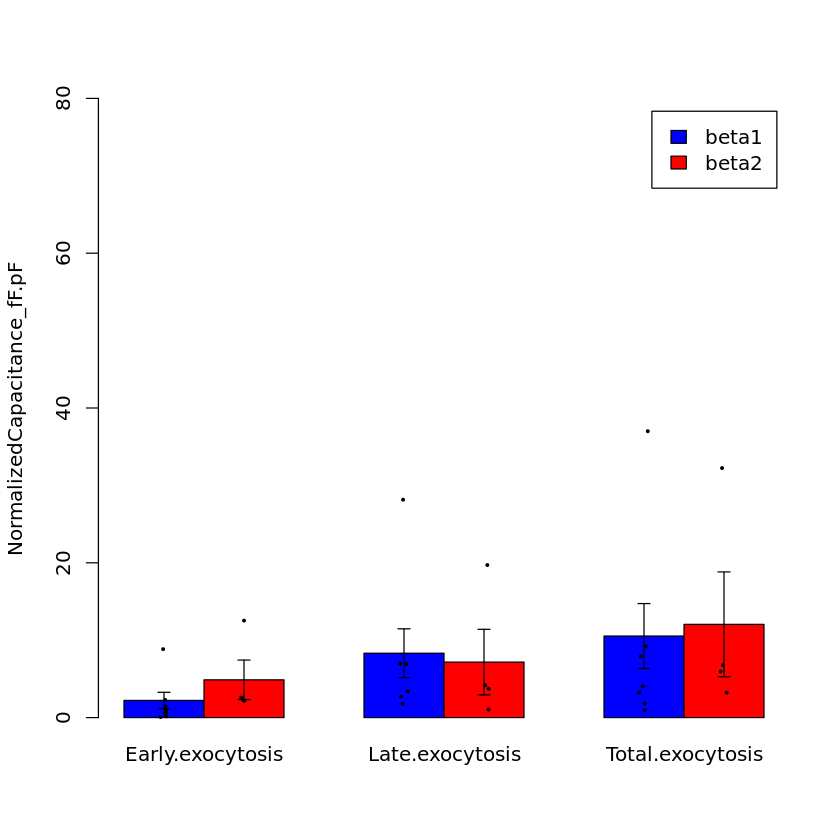

In [30]:
keep_test1=(R_meta$Glucose_mM==1)
keep_test2=(R_meta$disease=='ND')
R_test=R_meta[keep_test1 & keep_test2,]

### disease (all cells)
A_mean=aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~subtype, data=R_test, mean,na.rm=TRUE)
name_temp <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean) <- name_temp
lim_max=80
lim_min=0

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~subtype, data=R_test, sd,na.rm=TRUE)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(R_test$subtype)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

A_beta1 = R_test[R_test$subtype == 'beta1',]
A_beta2 = R_test[R_test$subtype == 'beta2',]

n1 = as.numeric(A_beta1$Early.exocytosis)
n2 = as.numeric(A_beta2$Early.exocytosis)
n3 = as.numeric(A_beta1$Late.exocytosis)
n4 = as.numeric(A_beta2$Late.exocytosis)
n5 = as.numeric(A_beta1$Total.exocytosis)
n6 = as.numeric(A_beta2$Total.exocytosis)

y = c(n1,n2,n3,n4,n5,n6)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(4.5,length(n3)),rep(5.5,length(n4)),rep(7.5,length(n5)),rep(8.5,length(n6)))
x = x + 0.04*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'red'),ylim=c(lim_min,lim_max), ylab="NormalizedCapacitance_fF.pF")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)


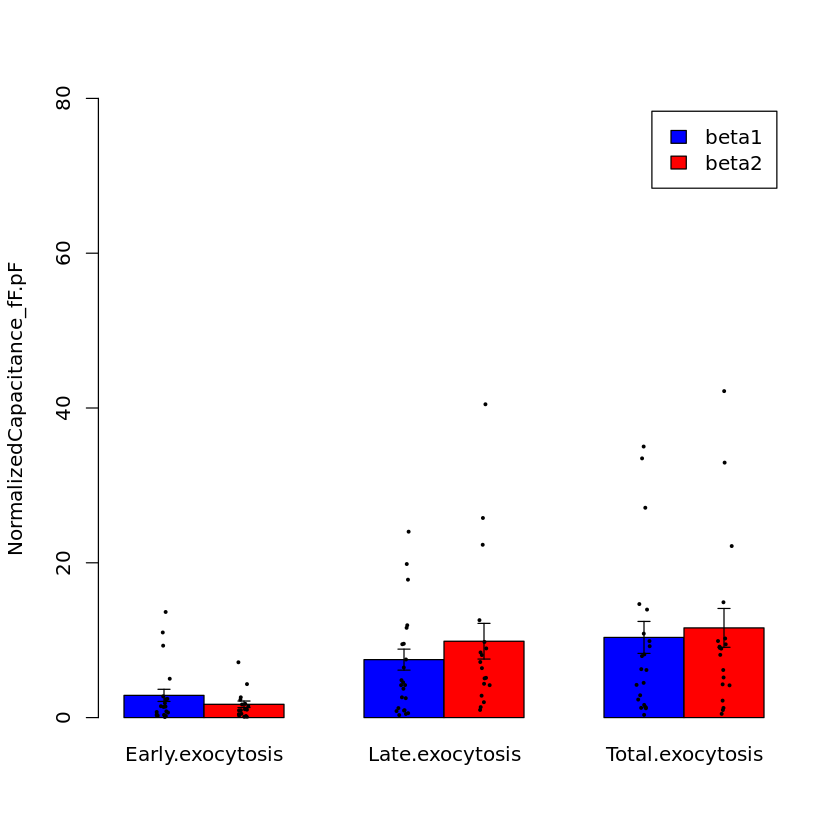

In [41]:
keep_test1=(R_meta$Glucose_mM==5)
keep_test2=(R_meta$disease=='ND')
R_test=R_meta[keep_test1 & keep_test2,]

### disease (all cells)
A_mean=aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~subtype, data=R_test, mean,na.rm=TRUE)
name_temp <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean) <- name_temp
lim_max=80
lim_min=0

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~subtype, data=R_test, sd,na.rm=TRUE)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(R_test$subtype)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}



A_beta1 = R_test[R_test$subtype == 'beta1',]
A_beta2 = R_test[R_test$subtype == 'beta2',]

n1 = as.numeric(A_beta1$Early.exocytosis)
n2 = as.numeric(A_beta2$Early.exocytosis)
n3 = as.numeric(A_beta1$Late.exocytosis)
n4 = as.numeric(A_beta2$Late.exocytosis)
n5 = as.numeric(A_beta1$Total.exocytosis)
n6 = as.numeric(A_beta2$Total.exocytosis)

y = c(n1,n2,n3,n4,n5,n6)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(4.5,length(n3)),rep(5.5,length(n4)),rep(7.5,length(n5)),rep(8.5,length(n6)))
x = x + 0.04*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'red'),ylim=c(lim_min,lim_max), ylab="NormalizedCapacitance_fF.pF")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)





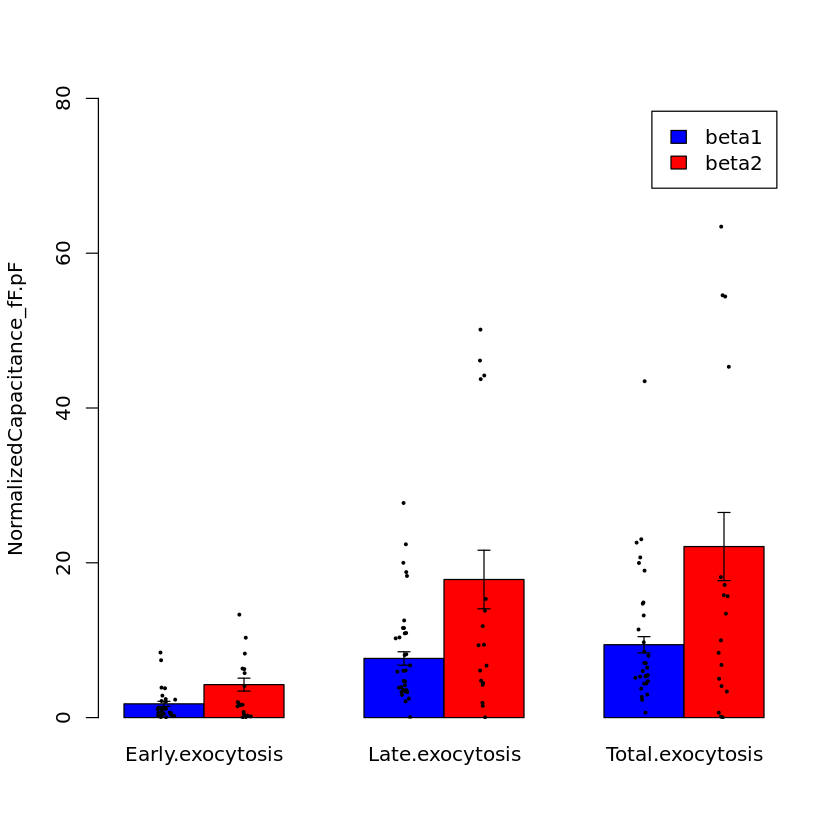

In [42]:
keep_test1=(R_meta$Glucose_mM==10)
keep_test2=(R_meta$disease=='ND')
R_test=R_meta[keep_test1 & keep_test2,]

### disease (all cells)
A_mean=aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~subtype, data=R_test, mean,na.rm=TRUE)
name_temp <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean) <- name_temp
lim_max=80
lim_min=0

error.bar <- function(x, y, upper, lower=upper, length=0.05,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~subtype, data=R_test, sd,na.rm=TRUE)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(R_test$subtype)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}


A_beta1 = R_test[R_test$subtype == 'beta1',]
A_beta2 = R_test[R_test$subtype == 'beta2',]

n1 = as.numeric(A_beta1$Early.exocytosis)
n2 = as.numeric(A_beta2$Early.exocytosis)
n3 = as.numeric(A_beta1$Late.exocytosis)
n4 = as.numeric(A_beta2$Late.exocytosis)
n5 = as.numeric(A_beta1$Total.exocytosis)
n6 = as.numeric(A_beta2$Total.exocytosis)

y = c(n1,n2,n3,n4,n5,n6)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(4.5,length(n3)),rep(5.5,length(n4)),rep(7.5,length(n5)),rep(8.5,length(n6)))
x = x + 0.04*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'red'),ylim=c(lim_min,lim_max), ylab="NormalizedCapacitance_fF.pF")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)


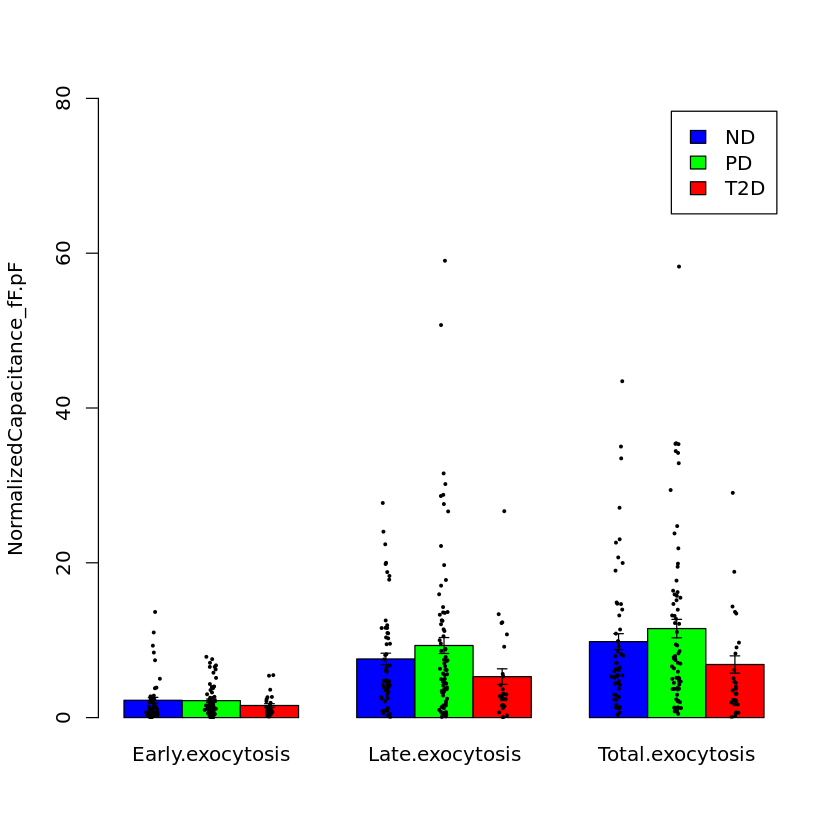

In [43]:
keep_test1=(R_meta$Glucose_mM>2)
keep_test2=(R_meta$subtype=='beta1')
R_test1=R_meta[(keep_test1 & keep_test2),]

### disease (all cells)
A_mean=aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~disease, data=R_test1, mean,na.rm=TRUE)
name_temp <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean) <- name_temp
lim_max=80
lim_min=0

error.bar <- function(x, y, upper, lower=upper, length=0.04,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~disease, data=R_test1, sd,na.rm=TRUE)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(R_test1$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

A_ND = R_test1[R_test1$disease == 'ND',]
A_PD = R_test1[R_test1$disease == 'PD',]
A_T2D = R_test1[R_test1$disease == 'T2D',]

n1 = as.numeric(A_ND$Early.exocytosis)
n2 = as.numeric(A_PD$Early.exocytosis)
n3 = as.numeric(A_T2D$Early.exocytosis)
n4 = as.numeric(A_ND$Late.exocytosis)
n5 = as.numeric(A_PD$Late.exocytosis)
n6 = as.numeric(A_T2D$Late.exocytosis)
n7 = as.numeric(A_ND$Total.exocytosis)
n8 = as.numeric(A_PD$Total.exocytosis)
n9 = as.numeric(A_T2D$Total.exocytosis)

y = c(n1,n2,n3,n4,n5,n6,n7,n8,n9)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3)),
      rep(5.5,length(n4)),rep(6.5,length(n5)),rep(7.5,length(n6)),
      rep(9.5,length(n7)),rep(10.5,length(n8)),rep(11.5,length(n9)))
x = x + 0.04*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'green','red'),ylim=c(lim_min,lim_max), ylab="NormalizedCapacitance_fF.pF")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)



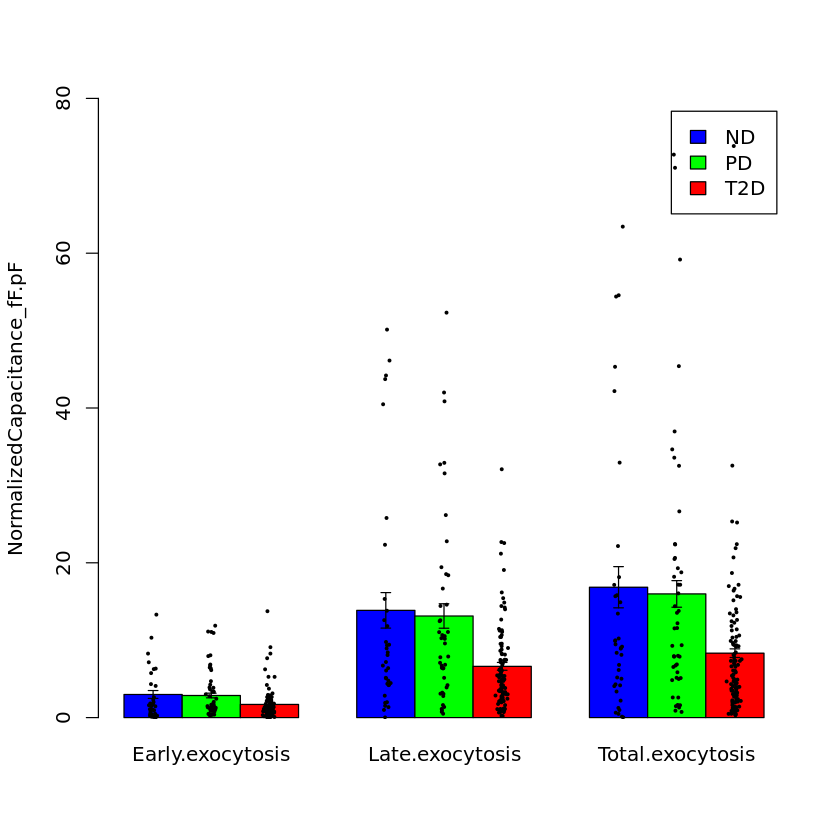

In [44]:
keep_test1=(R_meta$Glucose_mM>2)
keep_test2=(R_meta$subtype=='beta2')
R_test1=R_meta[(keep_test1 & keep_test2),]

### disease (all cells)
A_mean=aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~disease, data=R_test1, mean,na.rm=TRUE)
name_temp <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
rownames(A_mean) <- name_temp
lim_max=80
lim_min=0

error.bar <- function(x, y, upper, lower=upper, length=0.04,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

stdev <- aggregate(cbind(Early.exocytosis,Late.exocytosis,Total.exocytosis)~disease, data=R_test1, sd,na.rm=TRUE)

rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(R_test1$disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

A_ND = R_test1[R_test1$disease == 'ND',]
A_PD = R_test1[R_test1$disease == 'PD',]
A_T2D = R_test1[R_test1$disease == 'T2D',]

n1 = as.numeric(A_ND$Early.exocytosis)
n2 = as.numeric(A_PD$Early.exocytosis)
n3 = as.numeric(A_T2D$Early.exocytosis)
n4 = as.numeric(A_ND$Late.exocytosis)
n5 = as.numeric(A_PD$Late.exocytosis)
n6 = as.numeric(A_T2D$Late.exocytosis)
n7 = as.numeric(A_ND$Total.exocytosis)
n8 = as.numeric(A_PD$Total.exocytosis)
n9 = as.numeric(A_T2D$Total.exocytosis)

y = c(n1,n2,n3,n4,n5,n6,n7,n8,n9)
x = c(rep(1.5,length(n1)),rep(2.5,length(n2)),rep(3.5,length(n3)),
      rep(5.5,length(n4)),rep(6.5,length(n5)),rep(7.5,length(n6)),
      rep(9.5,length(n7)),rep(10.5,length(n8)),rep(11.5,length(n9)))
x = x + 0.04*rnorm(length(x))

ze_barplot <- barplot(A_mean, beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue",'green','red'),ylim=c(lim_min,lim_max), ylab="NormalizedCapacitance_fF.pF")
error.bar(ze_barplot,A_mean, stdev)
points(x,y,bg = 'grey',pch=19,cex=0.3)



# Infer beta cell gene regulatory network (GRN) from multiome data

## Infer TF binding sites

In [115]:
rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

load(paste0(wd_snATAC,'J_2020'))
peaks <- getPeaks(paste0(wd_snATAC,'cCRE_all.bed'), sort_peaks = FALSE)
peaks[1:4,]

motifs <- motif
library(motifmatchr)
motif_ix <- matchMotifs(motifs, peaks, genome = BSgenome.Hsapiens.UCSC.hg19,p.cutoff = 5e-04)

R=motifMatches(motif_ix) # Extract matches matrix from result
rownames(R)=peaks$V4
R=as.matrix(R)
#write.csv(R,'/oasis/tscc/scratch/gaw006/snATACseq/processed/TF_peak_binding.csv')

Warning message in getPeaks(paste0(wd_snATAC, "cCRE_all.bed"), sort_peaks = FALSE):
“Peaks not sorted”

GRanges object with 4 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]     chr1 10268-10767      *
  [2]     chr1 17249-17748      *
  [3]     chr1 29151-29650      *
  [4]     chr1 99455-99954      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Infer potential TF-target regualtions with physical interactions 

In [119]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

## input 1: full peak-by-TF matrix
TF=read.csv(paste0(wd_snATAC,'TF_peak_binding.csv'))
TF1=as.matrix(TF[,-1])
rownames(TF1)=as.character(TF$X)

V=read.csv(paste0(wd_snATAC,'TF_name.csv'))
colnames(TF1)=as.character(V$name)
TF1[1:4,1:5]
dim(TF1)

# input 2: beta cell high-confidence peaks
P=read.csv(paste0(wd_snATAC,'cCRE_celltype.csv'))
peak_all=as.character(P$X)
peak_hc=peak_all[P$beta>0]
length(peak_hc)


FOXF2 FOXD1 IRF2  MZF1(var.2) MAX::MYC
1:10267-10767 FALSE FALSE FALSE  TRUE       FALSE   
1:17248-17748 FALSE FALSE FALSE FALSE       FALSE   
1:29150-29650 FALSE FALSE FALSE FALSE       FALSE   
1:99454-99954 FALSE FALSE  TRUE  TRUE       FALSE

[1] 412113    633

[1] 230573

In [120]:
# input 3: peak-gene annotation (TSS and enhancer)
#TSS: promoter_peak_intersect.sh
Peak_gene=read.table(paste0(wd_snATAC,'biobank_TSS_10k.bed'))
Peak_gene1=Peak_gene[,c(4,8)]
p_s=as.numeric(Peak_gene$V2)
p_e=as.numeric(Peak_gene$V3)
p_tss=(as.numeric(Peak_gene$V6)+as.numeric(Peak_gene$V7))/2
Peak_gene1$distance=abs((p_s+p_e)/2-p_tss)
Peak_gene1$tss=p_tss
Peak_gene2=Peak_gene1[order(Peak_gene1$distance),]
Peak_gene3=Peak_gene2[!duplicated(Peak_gene2[,c(1,2)]),]
colnames(Peak_gene3)=c('peak','gene','distance','TSS')
dim(Peak_gene3)

#EP: EP_peak_intersect.sh
EP_gene=read.table(paste0(wd_snATAC,'beta_cicero_10kb.bed'))
EP_gene1=EP_gene[,c(4,12,5,11)]
EP_gene2=EP_gene1[!duplicated(EP_gene1[,c(1,2)]),]
colnames(EP_gene2)=c('peak','gene','distance','TSS')
dim(EP_gene2)

##merge
Peak_temp=rbind(Peak_gene3,EP_gene2)
#Peak_temp=Peak_gene3
dim(Peak_temp)

Peak_gene=Peak_temp[(Peak_temp$peak %in% peak_hc),]
dim(Peak_temp)
dim(Peak_gene)

Peak_gene[1:3,]

[1] 110588      4

[1] 15656     4

[1] 126244      4

[1] 126244      4

[1] 89329     4

peak                gene    distance TSS     
1081 1:1950530-1951030   GABRD   0        1950780 
6329 1:27709620-27710120 CD164L2 0        27709870
7300 1:32538253-32538753 TMEM39B 0        32538503

In [121]:
#Input
#1,full TF-by-peak matrix ()
#2,high-confidence peaks
#3, peak-gene annotation
#4, windown_size to link peaks to genes

#Output: GRN_base network


GRB_base <- function(TFB, peak, gene_anno, length){
    
    TFB_use=TFB[rownames(TFB) %in% peak,]
    peak_all=rownames(TFB_use)
    
    gene_anno_use=gene_anno[(as.character(gene_anno$peak) %in% peak) & (as.numeric(gene_anno$distance)<=length),]
    peak_link=as.character(gene_anno_use$peak)
    gene_link=as.character(gene_anno_use$gene)
    gene_unique=unique(gene_link)
    
    M=matrix(0,length(gene_unique),dim(TFB_use)[2]) #used for storing output
    rownames(M)=gene_unique
    colnames(M)=colnames(TFB_use)
    
    for (i in 1:dim(M)[2]){
      temp_value=rep(0,length(gene_unique))
      temp_peak=peak_all[TFB_use[,i]==1]
      temp_gene=gene_link[peak_link %in% temp_peak]
      temp_value[gene_unique %in% temp_gene]=1
      M[,i]=temp_value
    }
    return (M)
}

In [122]:
R=GRB_base(TF1,peak_hc,Peak_gene,100000)
keep1=(rownames(R) %in% c('INS','GCG'))
keep2=(colnames(R) %in% c('PDX1','MAFA','NEUROD1'))
R[keep1,keep2]

#write.csv(R,paste0(wd_snATAC,'GRNbase_biobank_beta_10k.csv'))

## Identify TF-target with gene expression correlation

In [123]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)
dim(C_norm)

## Input 2: GRN_base
R=read.csv(paste0(wd_snATAC,'GRNbase_biobank_beta_10k.csv'))
R1=as.matrix(R[,-1])
rownames(R1)=as.character(R$X)
dim(R1)

TF_use=intersect(rownames(R1),colnames(R1))
R2=R1[,(colnames(R1) %in% rownames(C_norm))]
R_base=R2[(rownames(R2) %in% rownames(C_norm)),]
dim(R_base)

[1] 18575    40

[1] 17723   633

[1] 11634   264

In [124]:
pair_cor <- function(dataset, GRN_base){
    
    #GRN_base=GRN_base[,sort(colnames(GRN_base))]
    #dataset=dataset[,sort(colnames(dataset))]
    
    base_genes = unique(append(colnames(GRN_base), rownames(GRN_base))) #store TF and target in the base_GRN
    
    inter_idx = colnames(dataset) %in% base_genes
    dataset = dataset[,inter_idx]
    
    GRN_base=GRN_base[rownames(GRN_base) %in% colnames(dataset),]
    GRN_base=GRN_base[,colnames(GRN_base) %in% colnames(dataset)]

    
    #coef_list = c()   #used for storing coeffcicients
    coef_matrix=matrix(0,dim(GRN_base)[1],dim(GRN_base)[2])  #used for storing matrix
    rownames(coef_matrix)=rownames(GRN_base)
    colnames(coef_matrix)=colnames(GRN_base)
    pval_matrix=(coef_matrix+2)
    
    #do ridge regression for each target gene and add the coefficients for tf into the list
    for (i in 1:dim(coef_matrix)[1]){  
        for (j in 1:dim(coef_matrix)[2]){
            Target_i=rownames(coef_matrix)[i]
            TF_j=colnames(coef_matrix)[j]
            
            if ((TF_j!=Target_i) & (GRN_base[rownames(GRN_base)==Target_i,colnames(GRN_base)==TF_j]==1)){
                temp_i=dataset[,colnames(dataset)==Target_i]
                temp_j=dataset[,colnames(dataset)==TF_j]
                temp_cor = cor.test(temp_i,temp_j,method = "pearson")
                
                pval_matrix[i,j]=temp_cor$p.value
                coef_matrix[i,j]=temp_cor$estimate
            }
        }
    }
    merge_r=list()
    merge_r[[1]]=coef_matrix
    merge_r[[2]]=pval_matrix
    return (merge_r)
}

In [125]:
test=pair_cor(t(C_norm),R_base)
file_name1=paste0(wd_multiome,'beta_stat_pair_bulk.csv')
file_name2=paste0(wd_multiome,'beta_pval_pair_bulk.csv')
#write.csv(test[[1]],file_name1)
#write.csv(test[[2]],file_name2)

## Identify TF-gene modules

In [126]:
temp1=read.csv(paste0(wd_multiome,'beta_pval_pair_bulk.csv'))
temp_pval=as.matrix(temp1[,-1])
rownames(temp_pval)=as.character(temp1$X)

temp1=read.csv(paste0(wd_multiome,'beta_stat_pair_bulk.csv'))
temp_stat=as.matrix(temp1[,-1])
rownames(temp_stat)=as.character(temp1$X)

N=matrix('c',1,4)
colnames(N)=c('TF','target','pval','stat')

for (i in 1:dim(temp_pval)[2]){
    TF_name=colnames(temp_pval)[i]
    TF_target=rownames(temp_pval)
    pval=temp_pval[,i]
    stat=temp_stat[,i]
    
    keep=(pval<1.5)
    Tar_n=length(pval[keep])
    N_temp=matrix('c',Tar_n,4)
    colnames(N_temp)=c('TF','target','pval','stat')
    N_temp[,1]=rep(TF_name,Tar_n)
    N_temp[,2]=TF_target[keep]
    N_temp[,3]=pval[keep]
    N_temp[,4]=stat[keep]
    
    N=rbind(N,N_temp)
}
N=N[-1,]
N=as.data.frame(N)
pval=as.numeric(as.character(N$pval))

FDR=p.adjust(pval, method = 'BH', n = length(pval))
N$FDR=FDR
N[1:4,]
dim(N)


#write.csv(N,paste0(wd_multiome,'beta_bulk_pair_correlations.csv'))

TF   target pval               stat                FDR       
1 IRF2 EIF3I  0.0840747105268973 -0.276558329795214  0.24680654
2 IRF2 PYGO2  0.78918497277003   -0.0436384119517006 0.89417044
3 IRF2 YY1AP1 0.28248483865537   -0.174153176494243  0.51118809
4 IRF2 VAMP4  0.011711545885008  0.394744861437929   0.07061151

[1] 2308212       5

In [127]:
N=read.csv(paste0(wd_multiome,'beta_bulk_pair_correlations.csv'))
th=0.01   ######## setting different p-value threshold th = 0.01 or 0.05

FDR=as.numeric(N$FDR)
N1=N[FDR<th,]
N1=N1[order(N1$FDR),]

TF_all=as.character(N1$TF)
Target_all=as.character(N1$target)
FDR=as.numeric(N1$FDR)
stat=as.numeric(as.character(N1$stat))
TF_unique=unique(TF_all)
length(TF_unique)

M=matrix('c',2500,length(TF_unique))
colnames(M)=TF_unique
Target_count=rep(0,length(TF_unique))

for (i in 1:length(TF_unique)){
    keep=((TF_all==TF_unique[i]) & stat>0)    ##### setting positive (stat>0) or negative (stat<0) correlation 
    temp_target=c(TF_unique[i],Target_all[keep])
    M[1:length(temp_target),i]=temp_target
    Target_count[i]=length(temp_target)
}
M[1:4,1:4]

#write.csv(M,paste0(wd_multiome,'TFmodule_bulk_pos_0.01.csv'))

[1] 264

MEIS2  GLIS3  RORA    FOS   
[1,] MEIS2  GLIS3  RORA    FOS   
[2,] SPAG16 PDE4D  UNC79   TUBA1A
[3,] RIMS2  ARID1B PTEN    DUSP1 
[4,] ZBTB20 MAML3  CACNA1D EGR1

## Differential TF-gene modules between beta subtyeps (gene expression)

In [128]:
library(GSA)
rm(list=ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

###### gene clusters
z=read.csv(paste0(wd_multiome,'TFmodule_bulk_pos_0.01.csv'))
### testing different modules

z=z[,-1]
gene_sets=list(1)
for (i in 1:dim(z)[2]){
  gene_sets[[i]]=toupper(unique(as.character(z[,i])))
}
z[1:5,1:5]

## gene expression data
##Input 1: bulk matrix dataset
C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)
dim(C_norm)
C_norm[1:2,]

pair_num=20
x_all=C_norm
genenames=rownames(x_all)
y_label=c(-c(1:pair_num),c(1:pair_num))

GSA_temp=GSA(x_all,y_label, genesets=gene_sets,genenames,method="maxmean", resp.type="Two class paired",minsize=10,maxsize=5000,nperms=1000)
GSA_result=cbind(GSA_temp$GSA.scores,GSA_temp$pvalues.lo,GSA_temp$pvalues.hi)
colnames(GSA_result)=c('score','pvalue_low','pvalue_high')
rownames(GSA_result)=toupper(colnames(z))
GSA_result[is.na(GSA_result)]=10
GSA_result[1:4,]

GSA_result[GSA_result[,2]<0.05,]
GSA_result[GSA_result[,3]<0.05,]
#write.csv(GSA_result,paste0(wd_multiome,'subtype_pos_0.01.csv'))


IRF2    PAX6   PBX1     RORA   RREB1   
1 IRF2    PAX6   PBX1     RORA   RREB1   
2 ERI2    EML2   ARHGAP32 CHL1   C1orf101
3 TMEM241 ELAVL4 LIMS1    LIMCH1 ARHGAP32
4 LIMS1   SLC7A8 PLD1     PDE4D  AKAP6   
5 SYNJ1   RAD51C IPO11    CDKAL1 PLD1

[1] 18575    40

A0011_beta1 A0019_beta1 A0021_beta1 A0024_beta1 A0027_beta1
A1BG      8.006146   27.88538    49.76600    18.43412    17.54412   
A1BG-AS1 26.325973   24.92911    22.50072    25.97805    21.63336   
         A0028_beta1 A0029_beta1 A0030_beta1 A0031_beta1 A0033_beta1 ⋯
A1BG     13.10374    51.80979    12.65658    14.70711    16.22972    ⋯
A1BG-AS1 20.77457    31.94288    13.37710    31.73639    20.01258    ⋯
         C0013_beta2 C0014_beta2 C0019_beta2 C0021_beta2 C0022_beta2
A1BG     59.78496    14.88191     7.095708   10.68851    10.43739   
A1BG-AS1 25.34118    24.46750    20.415720   21.36040    22.77029   
         C0023_beta2 C0024_beta2 C0025_beta2 C0026_beta2 C0027_beta2
A1BG     15.171633    9.900331    7.294503   27.13342    10.98485   
A1BG-AS1  9.353939   17.202080   33.280484   33.45775    37.24938

perm= 10 / 1000 
perm= 20 / 1000 
perm= 30 / 1000 
perm= 40 / 1000 
perm= 50 / 1000 
perm= 60 / 1000 
perm= 70 / 1000 
perm= 80 / 1000 
perm= 90 / 1000 
perm= 100 / 1000 
perm= 110 / 1000 
perm= 120 / 1000 
perm= 130 / 1000 
perm= 140 / 1000 
perm= 150 / 1000 
perm= 160 / 1000 
perm= 170 / 1000 
perm= 180 / 1000 
perm= 190 / 1000 
perm= 200 / 1000 
perm= 210 / 1000 
perm= 220 / 1000 
perm= 230 / 1000 
perm= 240 / 1000 
perm= 250 / 1000 
perm= 260 / 1000 
perm= 270 / 1000 
perm= 280 / 1000 
perm= 290 / 1000 
perm= 300 / 1000 
perm= 310 / 1000 
perm= 320 / 1000 
perm= 330 / 1000 
perm= 340 / 1000 
perm= 350 / 1000 
perm= 360 / 1000 
perm= 370 / 1000 
perm= 380 / 1000 
perm= 390 / 1000 
perm= 400 / 1000 
perm= 410 / 1000 
perm= 420 / 1000 
perm= 430 / 1000 
perm= 440 / 1000 
perm= 450 / 1000 
perm= 460 / 1000 
perm= 470 / 1000 
perm= 480 / 1000 
perm= 490 / 1000 
perm= 500 / 1000 
perm= 510 / 1000 
perm= 520 / 1000 
perm= 530 / 1000 
perm= 540 / 1000 
perm= 550 / 1000 
perm= 560 / 1000 
p

score       pvalue_low pvalue_high
IRF2 -0.01859758 0.448      0.552      
PAX6  0.33699434 0.935      0.065      
PBX1  0.73734662 1.000      0.000      
RORA  0.55125491 0.984      0.016

score      pvalue_low pvalue_high
REST    -1.1463495 0.018      0.982      
NFATC2  -0.5130341 0.017      0.983      
BHLHE41 -0.3595423 0.045      0.955      
DBP     -0.7767248 0.025      0.975      
HNF1A   -2.0300083 0.000      1.000      
HNF1B   -0.5483831 0.044      0.956      
HSF1    -0.5551462 0.017      0.983      
MLX     -0.5753899 0.028      0.972      
ZBTB7C  -0.7247234 0.037      0.963      
GLIS2   -0.2517807 0.009      0.991      
PKNOX2  -0.2544516 0.048      0.952      
SMAD3   -0.7812235 0.009      0.991      
TBX19   -0.6322198 0.012      0.988      
CEBPG   -2.5863342 0.000      1.000      
TEF     -1.0678664 0.009      0.991      
HIF1A   -0.5703695 0.004      0.996      
SOX13   -1.3860000 0.001      0.999      
VDR     -0.9688859 0.048      0.952      
ARNT2   -2.1663432 0.000      1.000      
PPARD   -2.5525308 0.000      1.000      
ZNF684  -0.5994321 0.033      0.967      
ZNF449  -0.5933901 0.014      0.986      
ELF1    -0.8960398 0.000      1.000      
ELF3    -0.3091307 0.032      0.968      
HNF4A   -3.1022065 0.000      1.000      
HNF4G   -2.3587017 0.000      1.000      
MAFK    -0.2697332 0.036      0.964      
MITF    -0.4077169 0.034      0.966      
TCF3    -0.8093856 0.009      0.991

score     pvalue_low pvalue_high
PBX1    0.7373466 1.000      0.000      
RORA    0.5512549 0.984      0.016      
FOS     0.3783965 0.968      0.032      
JUN     0.3017205 0.975      0.025      
TCF7L2  0.4619643 0.978      0.022      
FOXP2   0.7408298 0.989      0.011      
NFIA    0.7505468 1.000      0.000      
TFEB    0.4174490 0.986      0.014      
ESR1    0.4975048 0.982      0.018      
NR3C1   0.9597643 0.989      0.011      
NR3C2   0.6806331 0.987      0.013      
GLIS3   0.4832129 0.987      0.013      
CUX1    0.8871991 0.999      0.001      
ONECUT2 0.5578484 0.997      0.003      
MEIS1   0.8035948 0.990      0.010      
MEIS2   0.3357433 0.978      0.022      
POU2F1  0.3975326 0.983      0.017      
OLIG1   0.5160890 0.978      0.022      
HMBOX1  0.3573200 0.985      0.015      
NEUROD1 0.6392581 0.984      0.016      
PAX5    1.1672482 0.999      0.001      
PBX3    0.8706937 0.999      0.001      
RORB    1.8363636 1.000      0.000      
ELF2    0.5524049 0.969      0.031      
FOXN3   0.2746918 0.965      0.035      
KLF10   0.3840316 0.971      0.029      
NR6A1   0.3492038 0.989      0.011      
RFX7    0.8175506 0.998      0.002      
THRB    0.6342419 0.985      0.015      
BCL6    0.4291020 0.999      0.001      
HES1    0.2821514 0.957      0.043      
ZNF148  0.6218961 0.960      0.040      
CREB1   0.4163290 0.957      0.043      
EGR1    0.2898921 0.970      0.030      
ETV1    0.5671412 0.993      0.007      
FOXA2   0.2247875 0.973      0.027      
FOXP1   0.5936607 0.981      0.019      
MEF2A   0.5859219 0.963      0.037      
RFX3    1.0981461 0.997      0.003      
TCF4    1.1310562 1.000      0.000      
TEAD1   0.6696511 0.999      0.001

## Differential TF-gene moduels (gene expression and motif enrichment)

In [153]:
rm(list=ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A_pos=read.csv(paste0(wd_multiome,'subtype_pos_0.01.csv'))
A_neg=read.csv(paste0(wd_multiome,'subtype_neg_0.01.csv'))

p1=as.numeric(A_pos$pvalue_low)
p2=as.numeric(A_pos$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}

A_pos1=A_pos[,c(1,2)]
A_pos1$pvalue=p1
colnames(A_pos1)=c('TF','score_pos','pvalue_pos')

p1=as.numeric(A_neg$pvalue_low)
p2=as.numeric(A_neg$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}
A_neg1=A_neg[,c(1,2)]
A_neg1$pvalue=p1
colnames(A_neg1)=c('TF','score_neg','pvalue_neg')

A=merge(A_pos1,A_neg1,by='TF',all=FALSE)

#### setting cutoff pvalue<0.05 and enrichment score >0.6 to identify differential TF-gene modules
keep2_1=(A$pvalue_pos<0.05 & abs(A$score_pos)>0.6)
keep2_2=(A$pvalue_neg<0.05 & abs(A$score_neg)>0.6)
A_test2=A[keep2_1 | keep2_2,]

TF=read.csv(paste0(wd_snATAC,'TF_homer_subtype.csv'))
TF_motif=unique(c(as.character(TF$beta_0_motif_HC_all),as.character(TF$beta_1_motif_HC_all)))

A_TF=A_test2[A_test2$TF %in% TF_motif,]
A_TF$score_mean=(A_TF$score_pos - A_TF$score_neg)
TF_all=as.character(A_TF$TF)
TF_up=TF_all[A_TF$score_mean>0]
TF_down=TF_all[A_TF$score_mean<0]
TF_up
TF_down
A_TF

[1] "NEUROD1" "NFIA"    "TCF4"

[1] "HNF1A" "HNF4A" "HNF4G"

TF      score_pos  pvalue_pos score_neg    pvalue_neg score_mean 
76  HNF1A   -2.0300083 0.000       3.348202147  0.000      -5.3782105
78  HNF4A   -3.1022065 0.000      10.000000000 10.000     -13.1022065
79  HNF4G   -2.3587017 0.000       0.472979586  0.107      -2.8316813
124 NEUROD1  0.6392581 0.010      -0.007783228  0.469       0.6470413
128 NFIA     0.7505468 0.001      -0.113898876  0.159       0.8644457
205 TCF4     1.1310562 0.000      -0.355682198  0.029       1.4867384

## TF-gene module heatmap

[1] 18575    40

A0011      A0019      A0021      A0024       A0027      A0028     
A1BG      1.4571563  0.3505988 -0.3218209 -0.11082783 -0.1793737  0.2709072
A1BG-AS1  0.9338391  0.3372145  0.3394596 -0.04997885 -0.4092679  0.1818955
A1CF     -0.4955816 -0.9163629 -1.1850336 -1.12099370 -1.1918077 -1.3159606
         A0029     A0030      A0031      A0033     C0013       C0014     
A1BG     -3.102172 -0.9709855 -0.3211762 -1.082398  0.00216639 -0.3906032
A1BG-AS1 -1.265739  0.1284274 -0.8673084 -1.960217  0.22939661  0.2532949
A1CF     -2.452622 -0.8073169 -0.6594570 -1.331756 -2.55348562 -0.3780604
         C0019        C0021       C0022      C0023     C0024        C0025     
A1BG      0.009521997  0.08105248 -0.4155023  1.793506  0.003408356 -0.5206848
A1BG-AS1  0.561789074 -0.18503735  0.3285727 -1.188390  0.466167764  0.2514906
A1CF     -1.477011046 -1.85303395 -0.9934013 -2.104591 -1.999496390 -0.1936667
         C0026       C0027      
A1BG     -0.60612173  0.20636949
A1BG-AS1  0.08920704  0.53919859
A1CF     -0.73818443 -0.03735568

[1] TRUE

[1] TRUE

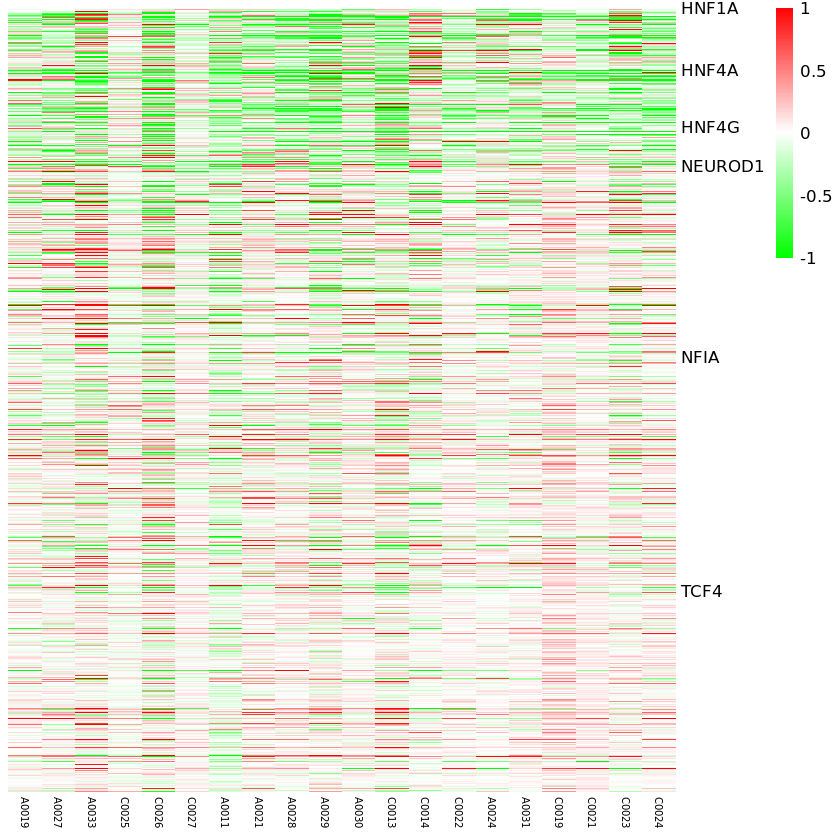

In [164]:

## TF
## expression data
z_pos=read.csv(paste0(wd_multiome,'TFmodule_bulk_pos_0.05.csv'))
z_neg=read.csv(paste0(wd_multiome,'TFmodule_bulk_neg_0.05.csv'))

####
C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)
dim(C_norm)


####### fold change
n_sample=0.5*dim(C_norm)[2]
C_fold=C_norm[,1:n_sample]
colnames(C_fold)=gsub("_beta1",  '', colnames(C_norm[,1:n_sample]))
for (i in 1:dim(C_fold)[2]){
    C_fold[,i]=log2((C_norm[,(n_sample+i)]+1)/(C_norm[,i]+1))
}
C_fold[1:3,]

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[C$Short.ID %in% colnames(C_fold),]
C=C[order(C$Short.ID),]
all(C$Short.ID==colnames(C_fold))
C_fold1=C_fold[,order(C$Sample.Description.Name)]
C1=C[order(C$Sample.Description.Name),]
all(C1$Short.ID==colnames(C_fold1))

#### TF cluster matrix
TF_test=c(TF_down,TF_up) #TF_low
C_TF=C_fold1[1,]
for (i in 1:length(TF_test)) {
    gene_test=unique(as.character(z_pos[,colnames(z_pos)==TF_test[i]]))
    TF_temp=C_fold1[rownames(C_fold1) %in% gene_test,]
    rownames(TF_temp)=rep('',dim(TF_temp)[1])
    sample_n=dim(C_fold1)[2]
    int_matrix=matrix(0,1,sample_n)
    rownames(int_matrix)=TF_test[i]
    C_TF=rbind(C_TF,int_matrix)
    C_TF=rbind(C_TF,TF_temp)
}

C_TF=C_TF[-1,]

bk = unique(c(seq(-1,1, length=100)))
pheatmap(C_TF,scale='none',breaks=bk,show_rownames = TRUE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("green",'white',"red"))(100))



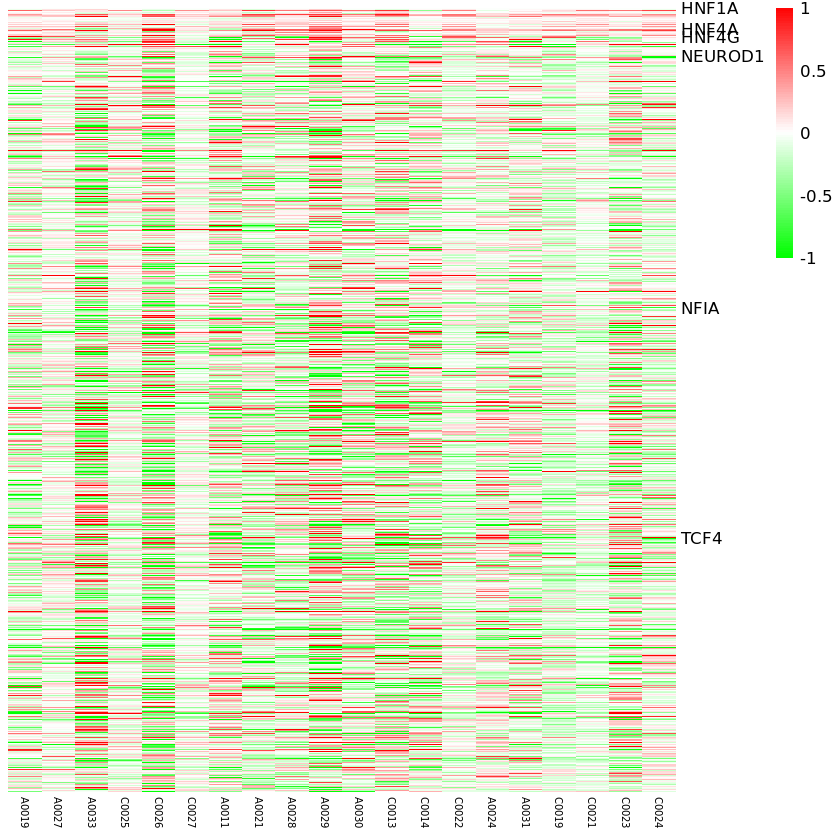

In [165]:
TF_test=c(TF_down,TF_up) #TF_low
C_TF=C_fold1[1,]
for (i in 1:length(TF_test)) {
    gene_test=unique(as.character(z_neg[,colnames(z_neg)==TF_test[i]]))
    TF_temp=C_fold1[rownames(C_fold1) %in% gene_test,]
    rownames(TF_temp)=rep('',dim(TF_temp)[1])
    sample_n=dim(C_fold1)[2]
    int_matrix=matrix(0,1,sample_n)
    rownames(int_matrix)=TF_test[i]
    C_TF=rbind(C_TF,int_matrix)
    C_TF=rbind(C_TF,TF_temp)
}

C_TF=C_TF[-1,]


bk = unique(c(seq(-1,1, length=100)))
pheatmap(C_TF,scale='none',breaks=bk,show_rownames = TRUE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("green",'white',"red"))(100))



## Regulations between TFs

In [166]:
TF_up
TF_down

[1] "NEUROD1" "NFIA"    "TCF4"

[1] "HNF1A" "HNF4A" "HNF4G"

In [167]:
N=read.csv(paste0(wd_multiome,'beta_bulk_pair_correlations.csv'))
dim(N)
FDR=as.numeric(N$pval)
stat=as.numeric(N$stat)
keep_pos=(FDR<0.05 & stat>0)
keep_neg=(FDR<0.05 & stat<0)
keep_sig=(FDR<0.05)

TF=read.csv(paste0(wd_multiome,'Homo_sapiens_TF.csv'))
TF_name=toupper(as.character(TF$Symbol))

N_pos=N[keep_pos,]
N_neg=N[keep_neg,]
N_sig=N[keep_sig,]
dim(N_pos)
dim(N_neg)

[1] 2308212       6

[1] 329525      6

[1] 316537      6

In [168]:
keep=((N_pos$TF %in% TF_up) & N_pos$target %in% TF_up)
N_pos[keep,]

X       TF      target  pval         stat      FDR         
447348   447348 NFIA    TCF4    5.365515e-08 0.7384220 1.460637e-05
450625   450625 NFIA    NEUROD1 1.132067e-03 0.4960889 1.509710e-02
1020535 1020535 NEUROD1 TCF4    2.276491e-04 0.5512108 5.097418e-03
1023286 1023286 NEUROD1 NFIA    1.132067e-03 0.4960889 1.509710e-02
2234634 2234634 TCF4    NFIA    5.365515e-08 0.7384220 1.460637e-05
2235774 2235774 TCF4    NEUROD1 2.276491e-04 0.5512108 5.097418e-03

In [169]:
keep=((N_pos$TF %in% TF_down) & N_pos$target %in% TF_down)
N_pos[keep,]

X       TF    target pval         stat      FDR         
400261   400261 HNF1A HNF4A  6.651581e-09 0.7692715 3.134597e-06
404427   404427 HNF1A HNF4G  1.191796e-03 0.4941585 1.562738e-02
2027095 2027095 HNF4A HNF1A  6.651581e-09 0.7692715 3.134597e-06
2033606 2033606 HNF4A HNF4G  3.652502e-04 0.5359173 7.037471e-03
2036218 2036218 HNF4G HNF1A  1.191796e-03 0.4941585 1.562738e-02
2036914 2036914 HNF4G HNF4A  3.652502e-04 0.5359173 7.037471e-03

In [170]:
keep=((N_neg$TF %in% c(TF_up,TF_down)) & (N_neg$target %in% c(TF_up,TF_down)))
N_neg[keep,]

X       TF    target pval       stat       FDR      
401383   401383 HNF1A TCF4   0.02370221 -0.3570825 0.1111482
2228948 2228948 TCF4  HNF1A  0.02370221 -0.3570825 0.1111482

## cCREs activity and expression level of TFs

In [172]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

R1=read.csv(paste0(wd_snATAC,'AI_beta_subtype.csv'))
R2=table(R1$donor,R1$subtype)

donor_name=rownames(R2)
donor_1=paste0(donor_name[R2[,1]>400 & R2[,2]>400],'_beta1')
donor_2=paste0(donor_name[R2[,1]>400 & R2[,2]>400],'_beta2')
donor_all=c(donor_1,donor_2)
length(donor_all)

C=read.csv(paste0(wd_snATAC,'ATAC_beta_subtype.csv'))
C1=as.matrix(C[,-1])
rownames(C1)=as.character(C$X)
C_all=C1[,(colnames(C1) %in% donor_all)]
dim(C_all)

######CPM normalization
C_norm_ATAC=C_all
for (i in 1:dim(C_all)[2]){
    C_norm_ATAC[,i]=(C_all[,i]/sum(C_all[,i]))*1000000
}

R1=read.csv(paste0(wd_multiome,'multiome_RNA_beta_subtype.csv'))
R2=table(R1$donor,R1$subtype)
donor_name=rownames(R2)

donor_1=paste0(donor_name,'_beta1')
donor_2=paste0(donor_name,'_beta2')
donor_all=c(donor_1,donor_2)
length(donor_all)

C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C1=as.matrix(C[,-1])
rownames(C1)=as.character(C$X)
C_norm_RNA=C1[,(colnames(C1) %in% donor_all)]
dim(C_norm_RNA)



[1] 58

[1] 229520     58

[1] 40

[1] 18575    40

[1] "12:121416081-121416581"


	Paired t-test

data:  beta_1 and beta_2
t = 12.923, df = 28, p-value = 2.544e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 5.373623 7.398095
sample estimates:
mean of the differences 
               6.385859 


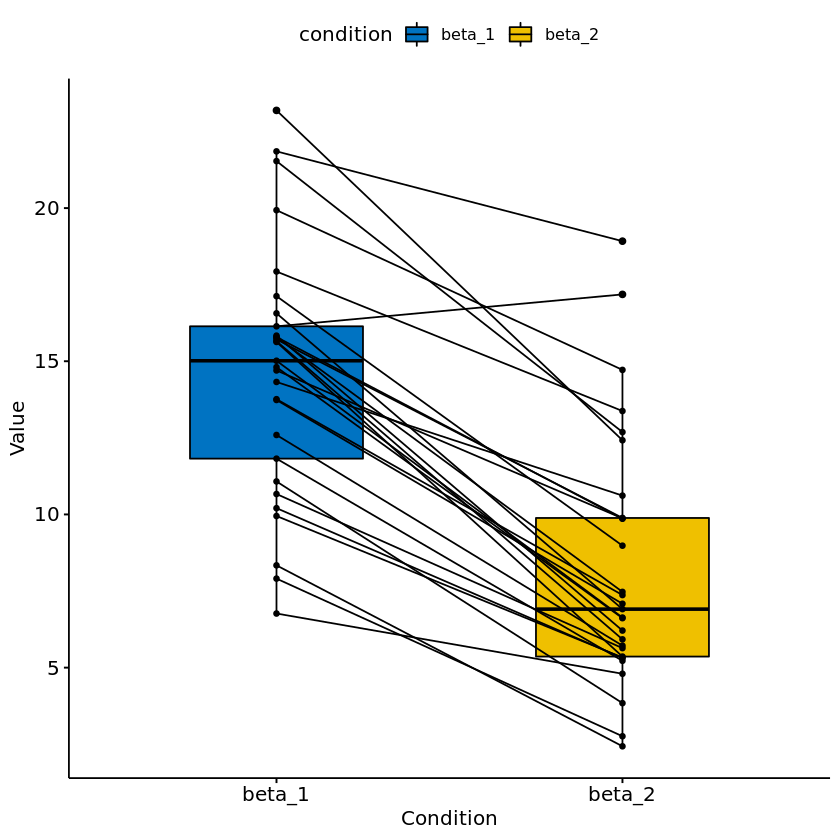

In [173]:
## 
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.05 & D$FDR_RNA<0.15)
D1=D[keep_fdr,]
gene_test='HNF1A'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")




	Paired t-test

data:  beta_1 and beta_2
t = 4.7046, df = 19, p-value = 0.0001543
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.428212 6.320302
sample estimates:
mean of the differences 
               4.374257 


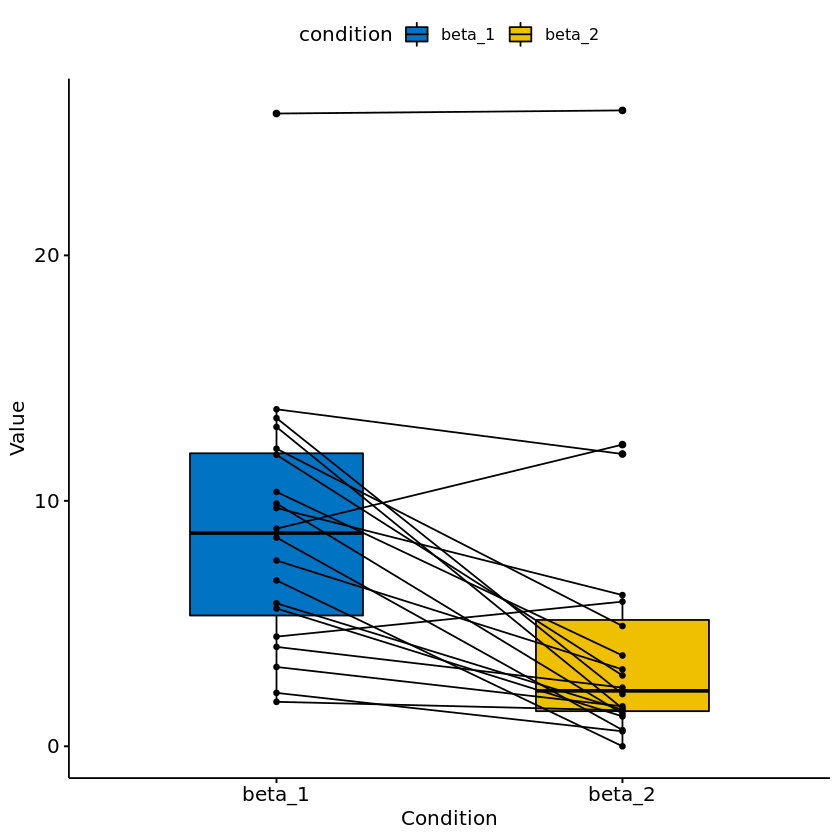

In [174]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "20:42984069-42984569"


	Paired t-test

data:  beta_1 and beta_2
t = 9.2317, df = 28, p-value = 5.453e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.731791 4.289811
sample estimates:
mean of the differences 
               3.510801 


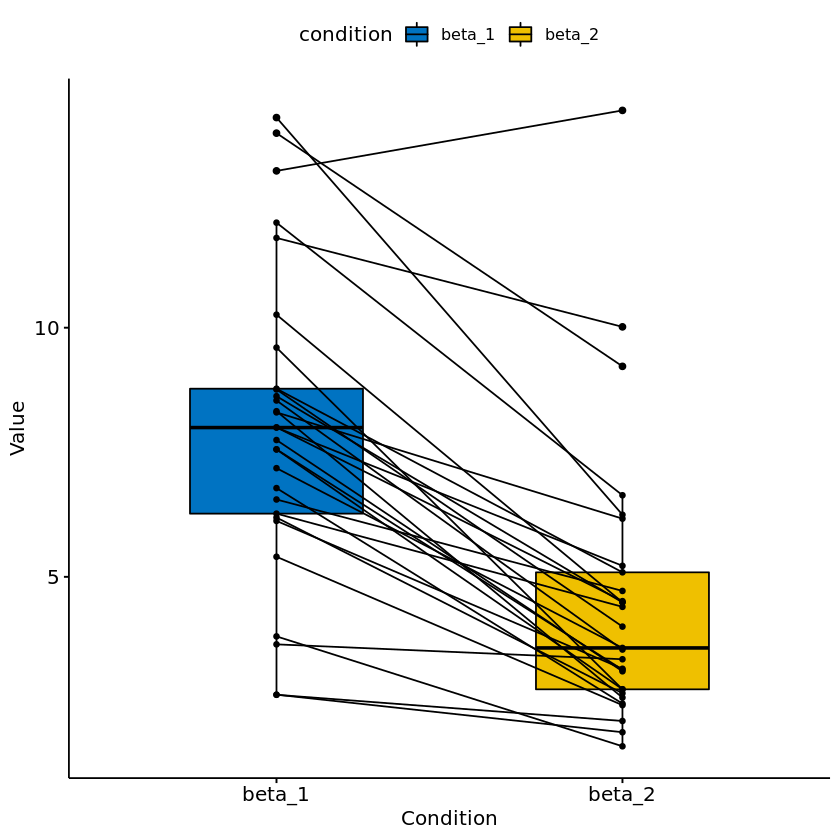

In [175]:
## HNF4A
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.05 & D$FDR_RNA<0.15)
D1=D[keep_fdr,]
gene_test='HNF4A'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")




	Paired t-test

data:  beta_1 and beta_2
t = 5.769, df = 19, p-value = 1.471e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  5.962309 12.752027
sample estimates:
mean of the differences 
               9.357168 


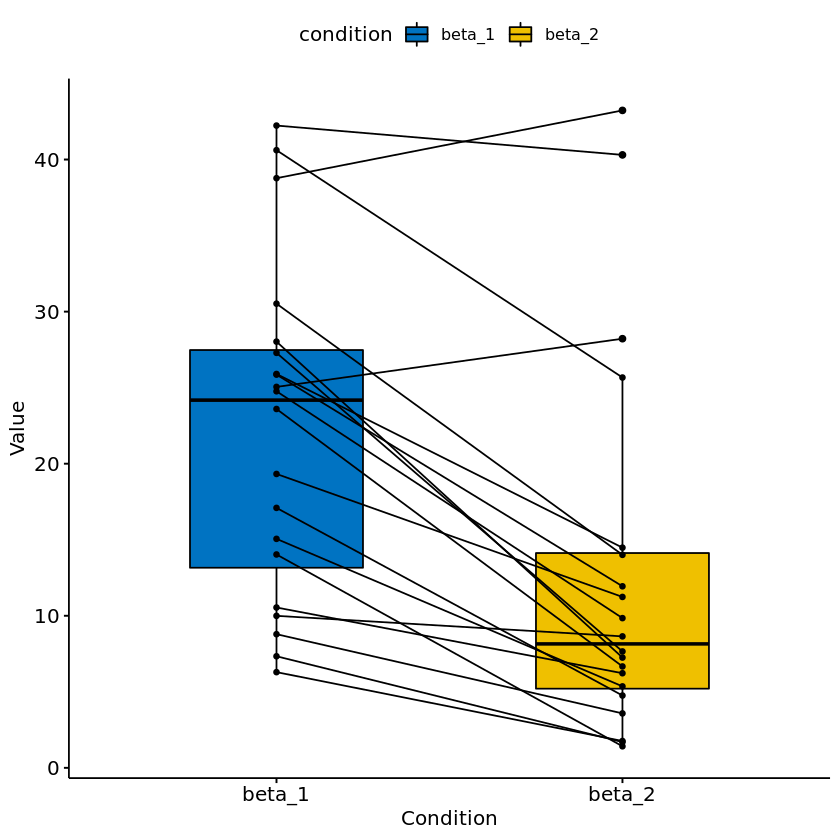

In [176]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "8:76319564-76320064"


	Paired t-test

data:  beta_1 and beta_2
t = 3.1525, df = 28, p-value = 0.003839
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4102216 1.9323235
sample estimates:
mean of the differences 
               1.171273 


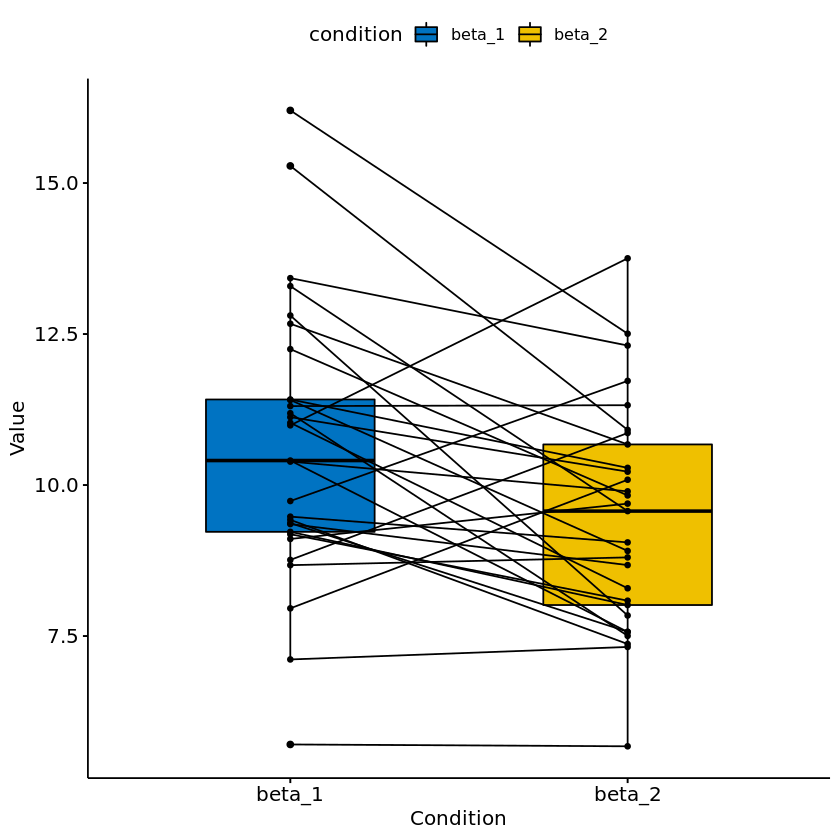

In [177]:
## HNF4G
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.15 & D$FDR_RNA<0.15)
D1=D[keep_fdr,]
gene_test='HNF4G'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")




	Paired t-test

data:  beta_1 and beta_2
t = 5.2917, df = 19, p-value = 4.162e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2.270916 5.242853
sample estimates:
mean of the differences 
               3.756885 


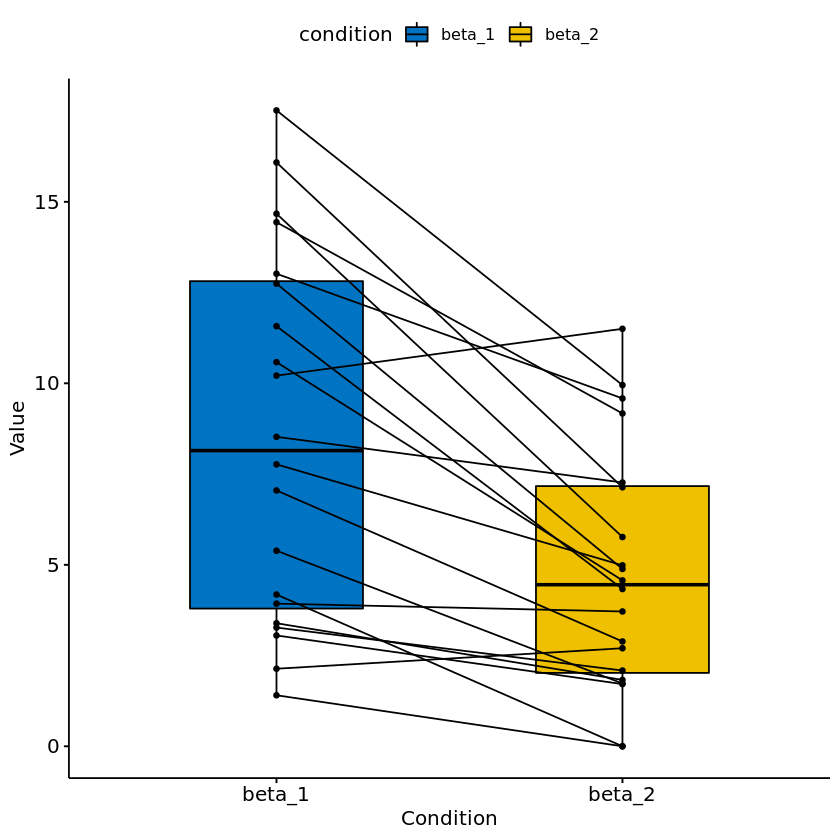

In [178]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "2:182545164-182545664"


	Paired t-test

data:  beta_1 and beta_2
t = -2.4896, df = 28, p-value = 0.019
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.1731980 -0.3085079
sample estimates:
mean of the differences 
              -1.740853 


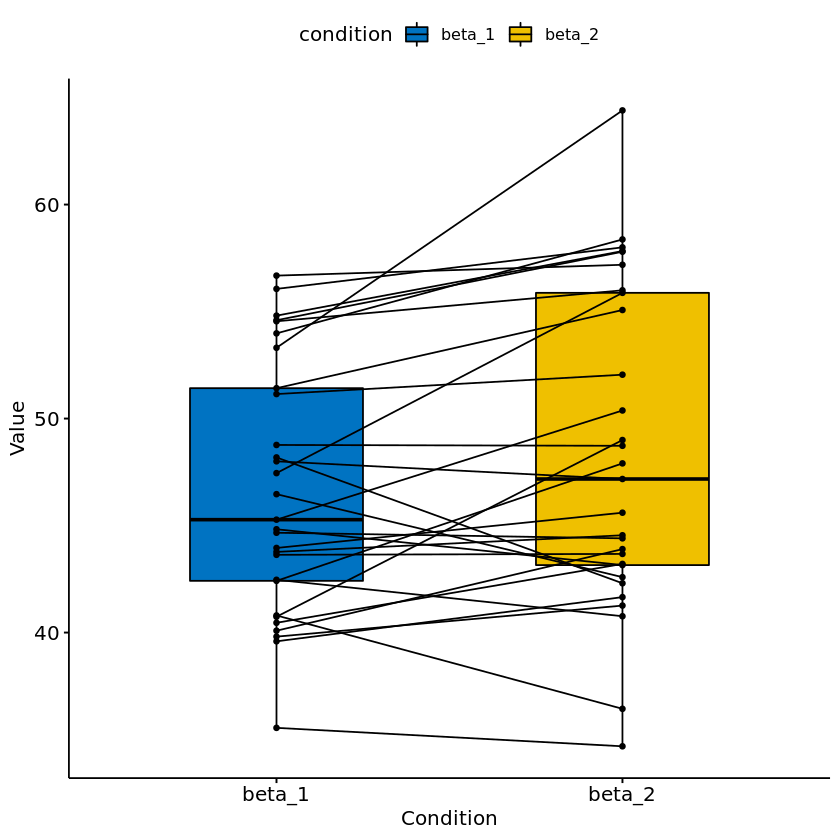

In [179]:
## NEUROD1
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.5 & D$FDR_RNA<0.5)
D1=D[keep_fdr,]
gene_test='NEUROD1'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")



	Paired t-test

data:  beta_1 and beta_2
t = -1.7006, df = 19, p-value = 0.1053
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -18.700562   1.934574
sample estimates:
mean of the differences 
              -8.382994 


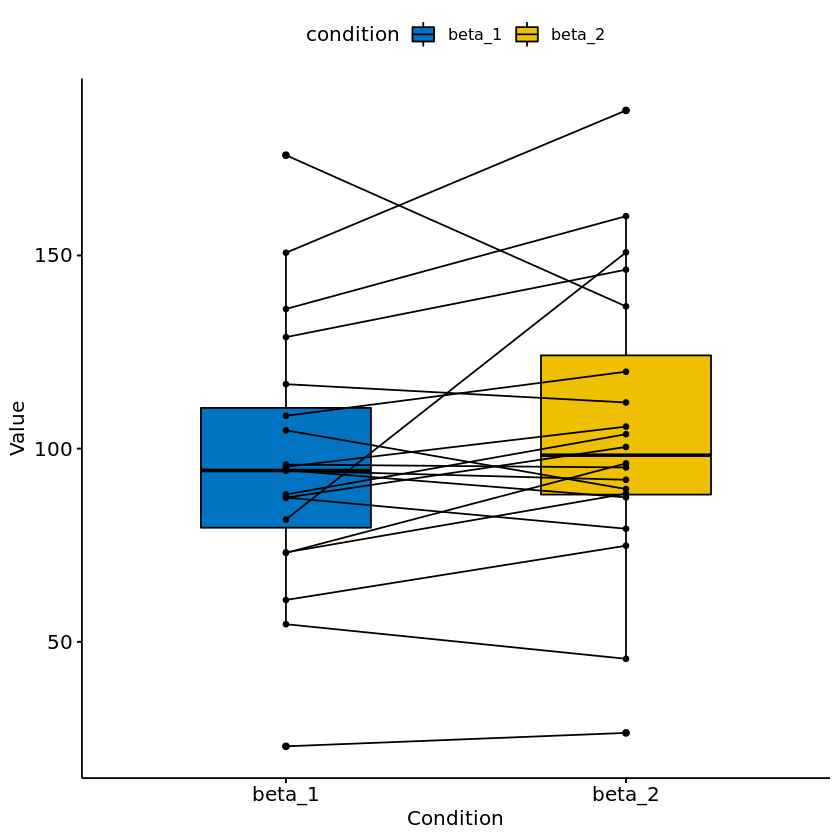

In [180]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "18:52989379-52989879"


	Paired t-test

data:  beta_1 and beta_2
t = -4.3634, df = 28, p-value = 0.0001575
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.572597 -0.928834
sample estimates:
mean of the differences 
              -1.750715 


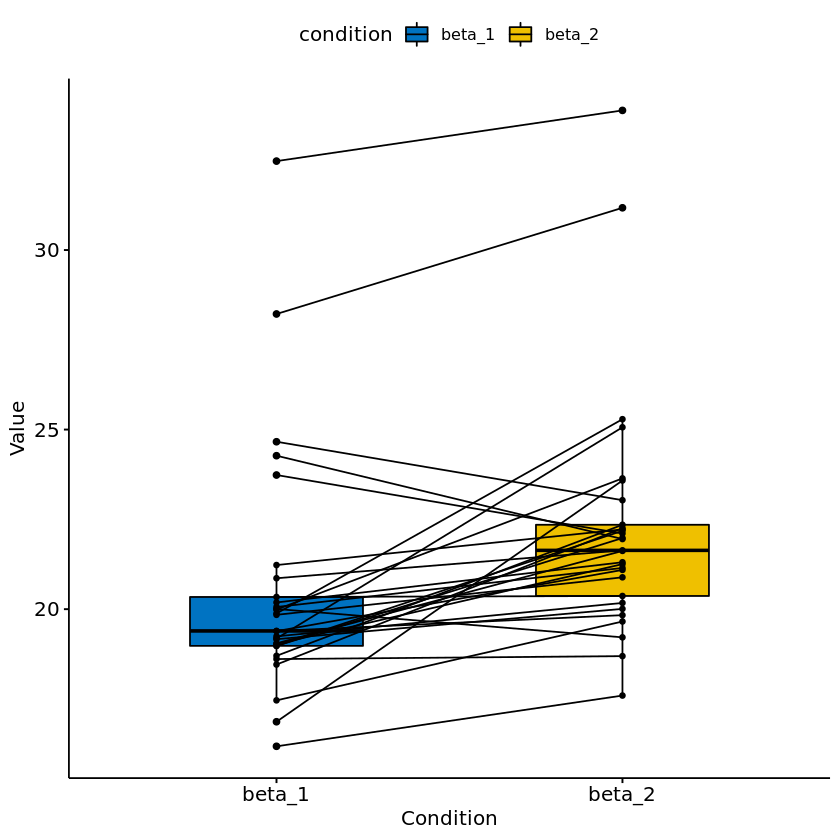

In [181]:
## TCF4
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.5 & D$FDR_RNA<0.5)
D1=D[keep_fdr,]
gene_test='TCF4'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")



	Paired t-test

data:  beta_1 and beta_2
t = -6.1754, df = 19, p-value = 6.2e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.55883  -6.69443
sample estimates:
mean of the differences 
              -10.12663 


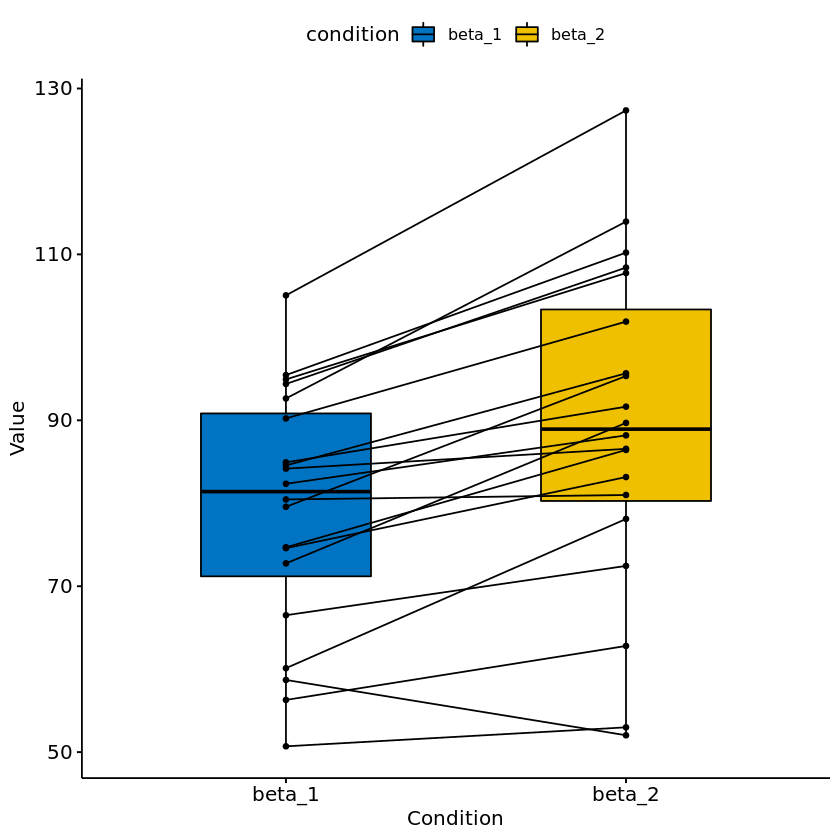

In [182]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

[1] "1:61523320-61523820"


	Paired t-test

data:  beta_1 and beta_2
t = -5.0552, df = 28, p-value = 2.385e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.2266042 -0.9424616
sample estimates:
mean of the differences 
              -1.584533 


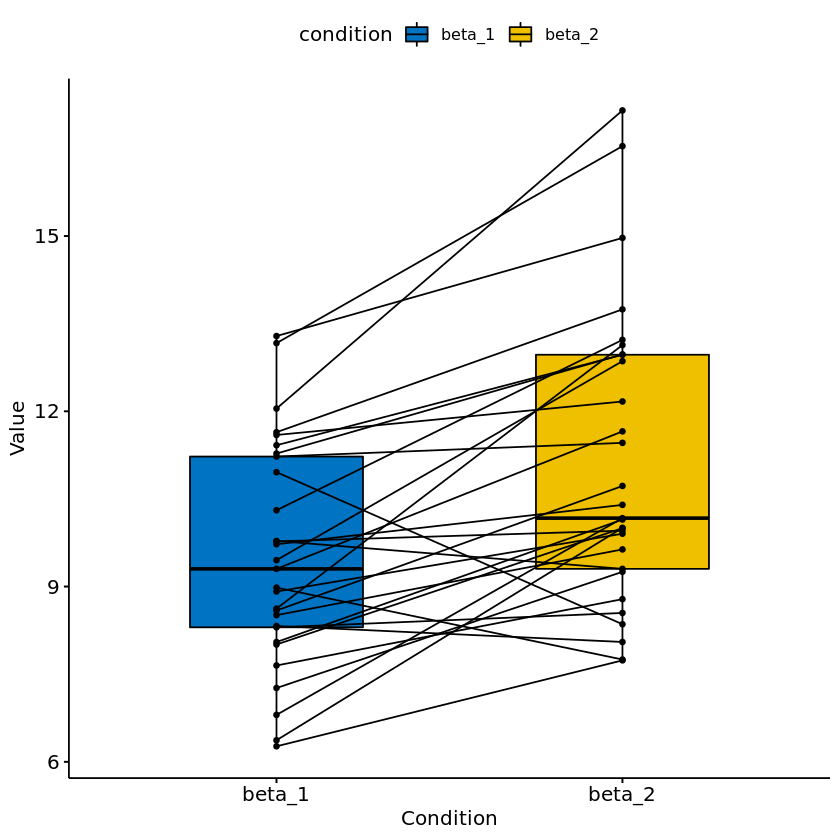

In [8]:
## NFIA
D=read.csv(paste0(wd_snATAC,'peak2gene_10kb.csv'))
keep_fdr=(D$FDR_ATAC<0.5 & D$FDR_RNA<0.5)
D1=D[keep_fdr,]
gene_test='NFIA'

D2=D1[D1$gene %in% gene_test,]
D2=D2[order(D2$FDR_ATAC),]
D2_peak=as.character(D2$peak)
peak_test=D2_peak[1]
peak_test

C_test=t(C_norm_ATAC)
beta_1 <- C_test[1:29,colnames(C_test) %in% peak_test]
beta_2 <- C_test[30:58,colnames(C_test) %in% peak_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")



	Paired t-test

data:  beta_1 and beta_2
t = -5.618, df = 19, p-value = 2.038e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.259575  -6.061422
sample estimates:
mean of the differences 
              -9.660498 


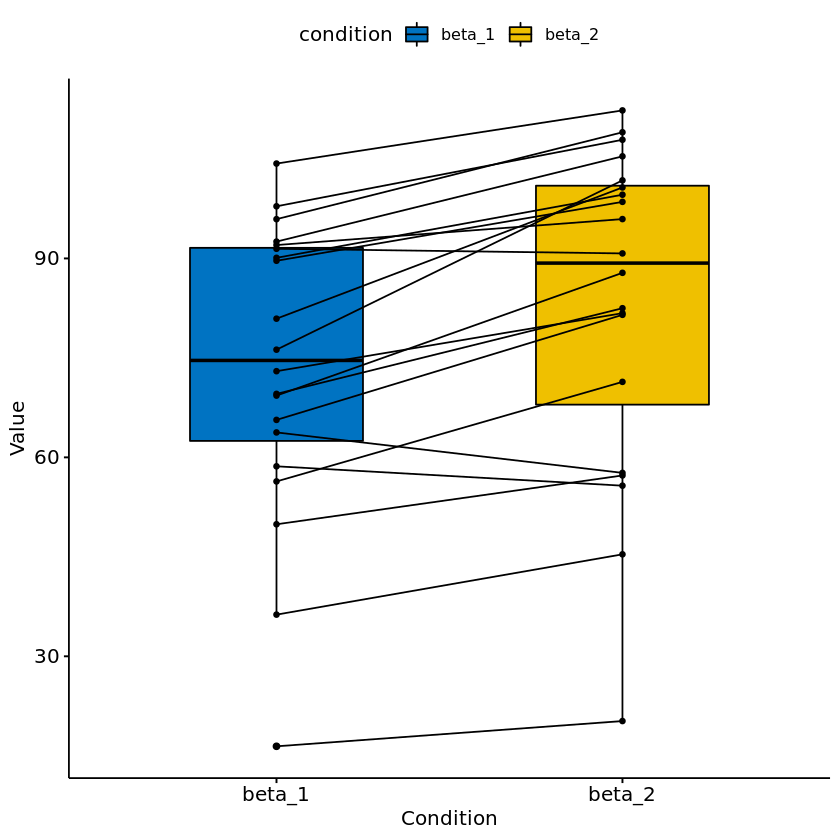

In [184]:
C_test=t(C_norm_RNA)
beta_1 <- C_test[1:20,colnames(C_test) %in% gene_test]
beta_2 <- C_test[21:40,colnames(C_test) %in% gene_test]

t.test(beta_1, beta_2, paired = TRUE, alternative = "two.sided")

d <- data.frame(beta_1 = beta_1,beta_2 = beta_2)
ggpaired(d, cond1 = "beta_1", cond2 = "beta_2",
    fill = "condition", palette = "jco")

In [10]:
D2

X     gene mean_RNA_beta0 mean_RNA_beta1 pvalue_RNA   FDR_RNA    
36928 36928 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
36921 36921 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
36918 36918 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
36920 36920 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
36922 36922 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
36915 36915 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
36919 36919 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
36916 36916 NFIA 73.49845       83.15895       2.038327e-05 0.003863462
      peak                mean_ATAC_beta0 mean_ATAC_beta1 pvalue_ATAC 
36928 1:61523320-61523820  9.5035916      11.0881245      2.385137e-05
36921 1:61519447-61519947  3.8505078       4.6811311      2.987065e-03
36918 1:61515490-61515990 18.5649949      20.0313437      1.062084e-02
36920 1:61515490-61515990 18.5649949      20.0313437      1.062084e-02
36922 1:61333364-61333864  0.5561607       0.7616233      3.697395e-02
36915 1:61524110-61524610  1.9774328       2.3540851      4.299112e-02
36919 1:61522468-61522968  9.5639014      10.1293762      8.309183e-02
36916 1:61545440-61545940  5.5933184       6.0213860      1.243011e-01
      FDR_ATAC    type    
36928 0.002773312 promoter
36921 0.071259856 promoter
36918 0.147712214 promoter
36920 0.147712214 enhancer
36922 0.279732998 promoter
36915 0.301755842 promoter
36919 0.405721813 promoter
36916 0.483869966 promoter

## Correlations between TFs

A1BG      A1BG-AS1 A1CF    
A0011_beta1  8.006146 26.32597 47.26222
A0019_beta1 27.885382 24.92911 36.78623
A0021_beta1 49.765996 22.50072 62.55332

`geom_smooth()` using formula 'y ~ x'


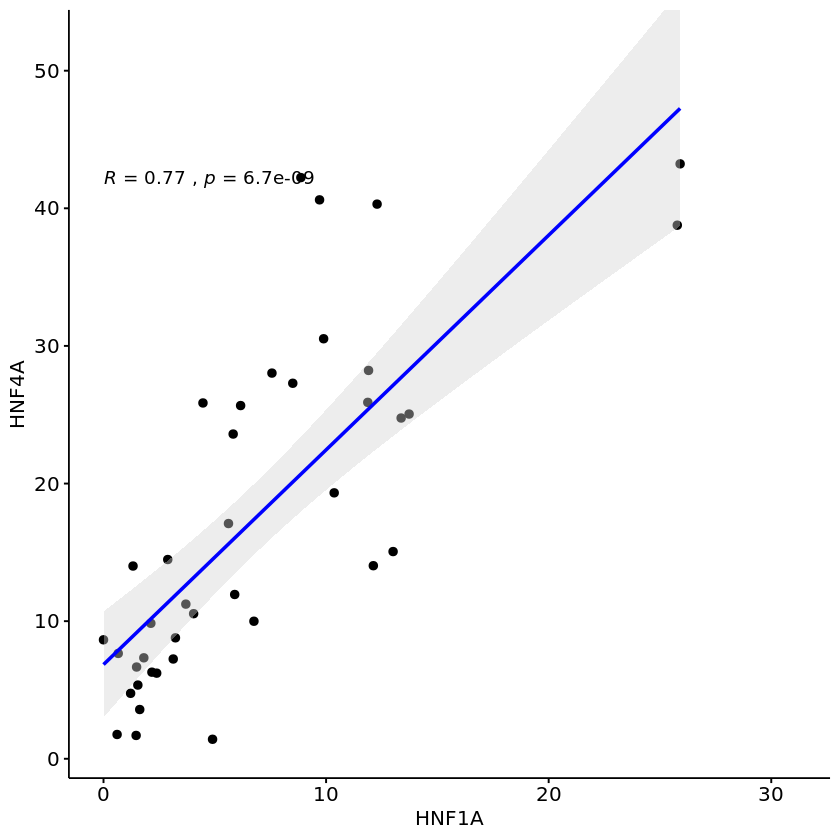

In [185]:
##Input 1: bulk matrix dataset
C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)
C_norm=t(C_norm)
C_norm=as.data.frame(C_norm)
C_norm[1:3,1:3]

library('ggpubr')
M_temp1=C_norm
D_min=min(M_temp1$HNF1A)
D_max=max(M_temp1$HNF1A)
R_min=min(M_temp1$HNF4A)
R_max=max(M_temp1$HNF4A)

p2 <- ggscatter(as.data.frame(M_temp1), x = "HNF1A", y = "HNF4A",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="HNF1A", ylab="HNF4A")


`geom_smooth()` using formula 'y ~ x'


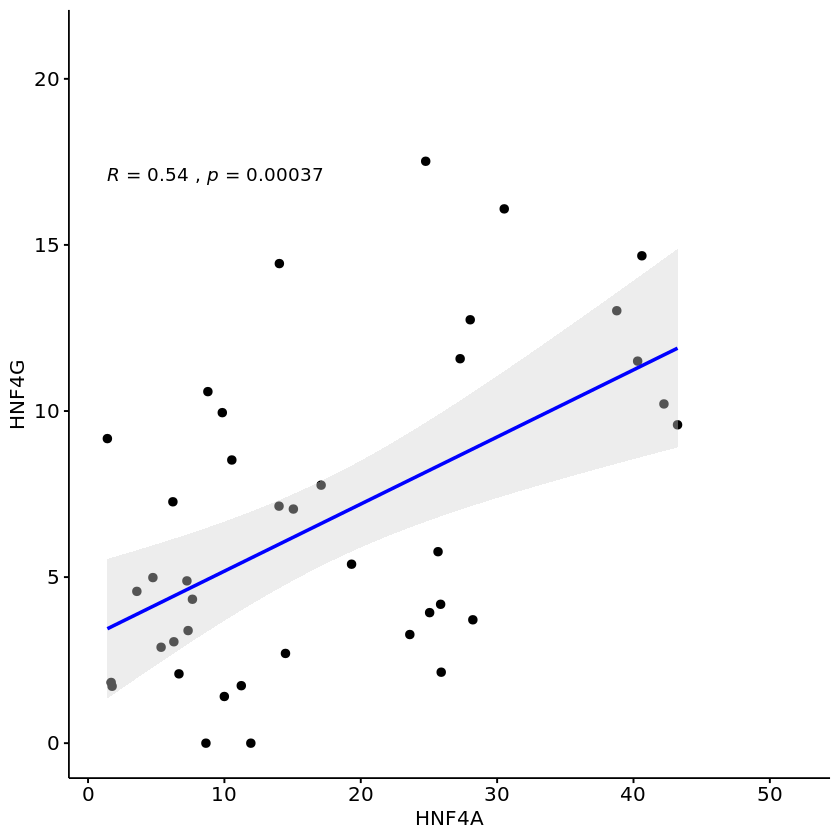

In [186]:
D_min=min(M_temp1$HNF4A)
D_max=max(M_temp1$HNF4A)
R_min=min(M_temp1$HNF4G)
R_max=max(M_temp1$HNF4G)

p2 <- ggscatter(as.data.frame(M_temp1), x = "HNF4A", y = "HNF4G",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="HNF4A", ylab="HNF4G")


`geom_smooth()` using formula 'y ~ x'


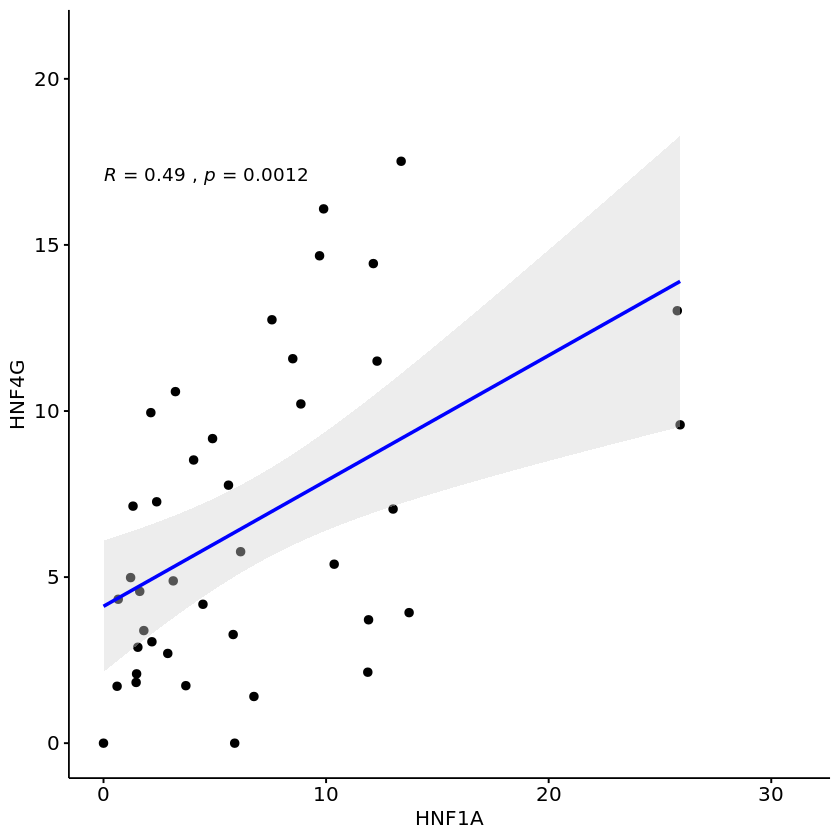

In [187]:
D_min=min(M_temp1$HNF1A)
D_max=max(M_temp1$HNF1A)
R_min=min(M_temp1$HNF4G)
R_max=max(M_temp1$HNF4G)

p2 <- ggscatter(as.data.frame(M_temp1), x = "HNF1A", y = "HNF4G",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="HNF1A", ylab="HNF4G")


`geom_smooth()` using formula 'y ~ x'


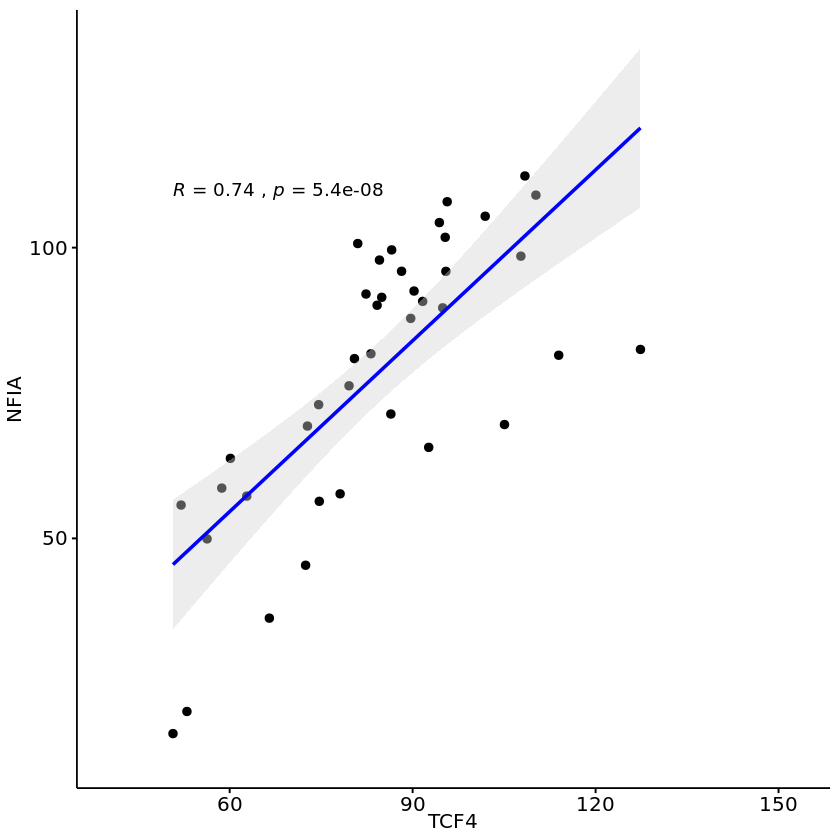

In [188]:
D_min=min(M_temp1$TCF4)
D_max=max(M_temp1$TCF4)
R_min=min(M_temp1$NFIA)
R_max=max(M_temp1$NFIA)

p2 <- ggscatter(as.data.frame(M_temp1), x = "TCF4", y = "NFIA",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="TCF4", ylab="NFIA")


`geom_smooth()` using formula 'y ~ x'


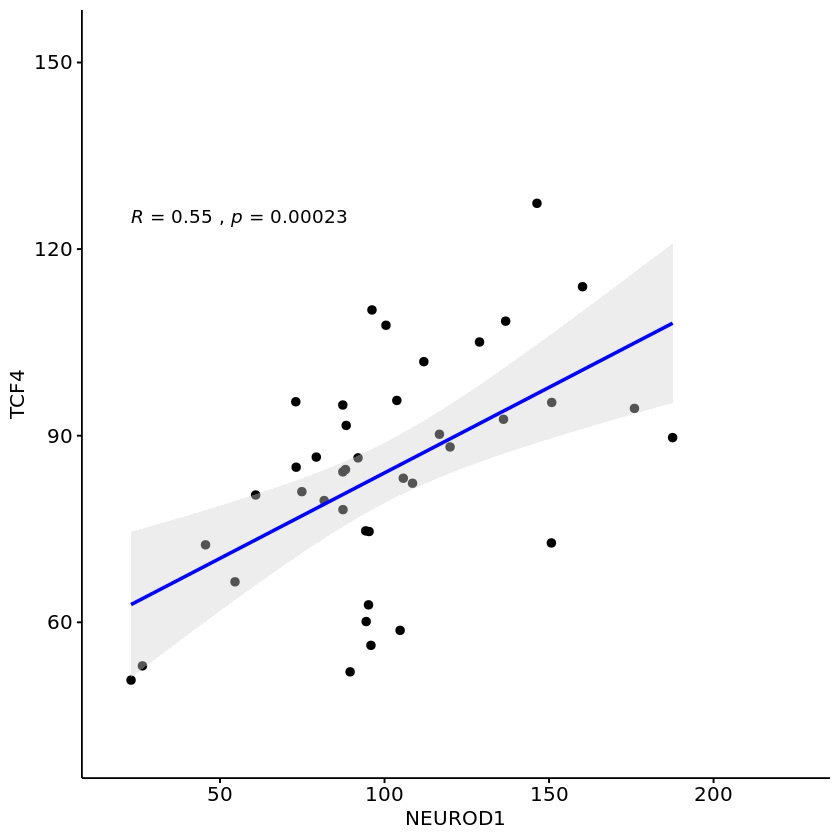

In [189]:
D_min=min(M_temp1$NEUROD1)
D_max=max(M_temp1$NEUROD1)
R_min=min(M_temp1$TCF4)
R_max=max(M_temp1$TCF4)

p2 <- ggscatter(as.data.frame(M_temp1), x = "NEUROD1", y = "TCF4",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="NEUROD1", ylab="TCF4")


`geom_smooth()` using formula 'y ~ x'


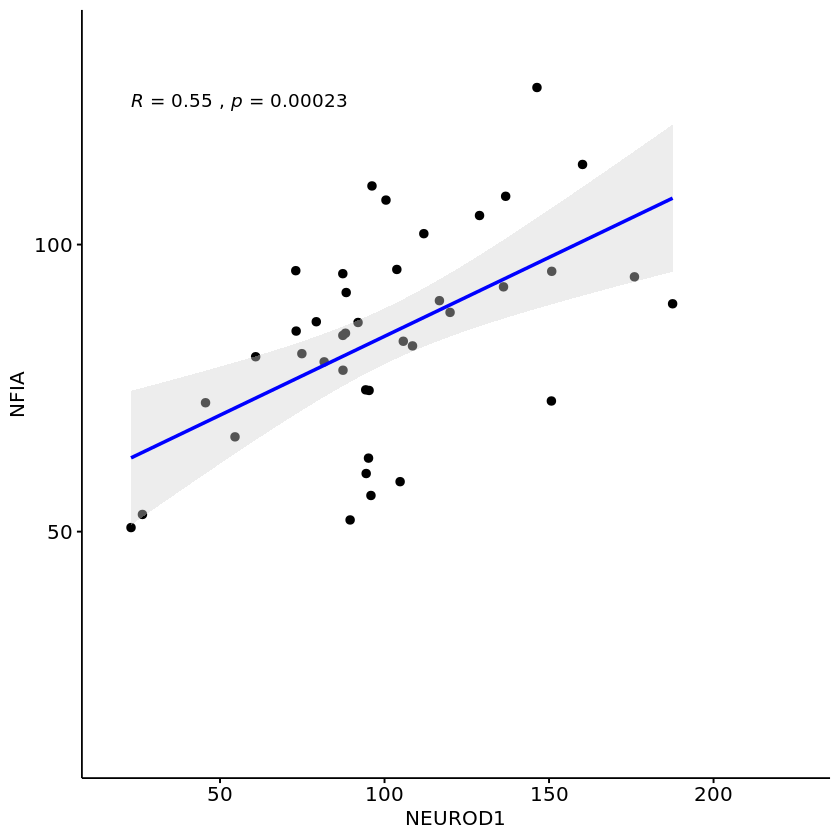

In [190]:
D_min=min(M_temp1$NEUROD1)
D_max=max(M_temp1$NEUROD1)
R_min=min(M_temp1$NFIA)
R_max=max(M_temp1$NFIA)

p2 <- ggscatter(as.data.frame(M_temp1), x = "NEUROD1", y = "TCF4",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="NEUROD1", ylab="NFIA")


`geom_smooth()` using formula 'y ~ x'


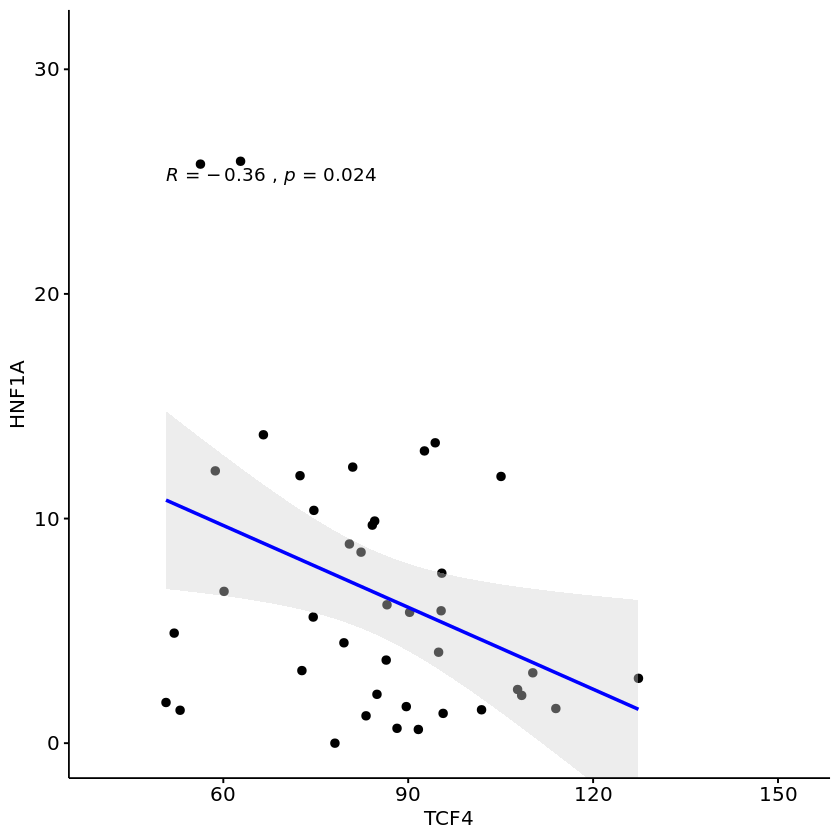

In [191]:
D_min=min(M_temp1$TCF4)
D_max=max(M_temp1$TCF4)
R_min=min(M_temp1$HNF1A)
R_max=max(M_temp1$HNF1A)

p2 <- ggscatter(as.data.frame(M_temp1), x = "TCF4", y = "HNF1A",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="TCF4", ylab="HNF1A")


# Differential peaks during T2D progression (S Figure 10a-b)

## beta-1

In [192]:

rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A=read.csv(paste0(wd_snATAC,'biobank_snATAC_beta_subtype.csv'))
A_raw=as.matrix(A[,-1])
rownames(A_raw)=as.character(A$X)
dim(A_raw)

A_norm=A_raw
for (i in 1:dim(A_raw)[2]){
    A_norm[,i]=(A_raw[,i]/sum(A_raw[,i]))*1000000
}
A_norm[1:3,1:3]

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C$donor=paste0(C$donor,'_beta1') ##########
C=C[order(C$donor),]
A_norm=A_norm[,colnames(A_norm) %in% as.character(C$donor)]
A_raw=A_raw[,colnames(A_raw) %in% as.character(C$donor)]
all(C$donor==colnames(A_norm))

C$total_count=(colSums(A_raw)/100000)
all(as.character(C$donor) == colnames(A_raw))


[1] 229520     68

JYH792_beta1 JYH809_beta1 MM108_beta1
1:100009946-100010446 3.3434128    3.373449     7.118073   
1:100014513-100015013 3.5739930    1.686725     1.642632   
1:100017730-100018230 0.4611604    1.686725     1.642632

[1] TRUE

[1] TRUE

In [193]:
### call differential cCRES using age, BMI, gender, TSS_frac, islet index, total count as covariants
dds <- DESeqDataSetFromMatrix(countData = A_raw,
                              colData = C,
                              design= ~ Age + BMI + Gender + TSS_frac + islet.index + total_count + Sample.Description.Name)

dds$Sample.Description.Name <- relevel(dds$Sample.Description.Name, ref = "Non")

library("BiocParallel")
register(MulticoreParam(4))
dds <- DESeq(dds,parallel=TRUE)

resultsNames(dds)

  the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 4 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 4 workers


[1] "Intercept"                          "Age"                               
[3] "BMI"                                "Gender_M_vs_F"                     
[5] "TSS_frac"                           "islet.index"                       
[7] "total_count"                        "Sample.Description.Name_Pre_vs_Non"
[9] "Sample.Description.Name_T2D_vs_Non"

In [194]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'paste0(wd_snATAC,'beta1_T2D_ND.csv'))


[1] 543

[1] 402

In [195]:
res <- results(dds,contrast=c("Sample.Description.Name", "Pre", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'paste0(wd_snATAC,'beta1_PD_ND.csv'))


[1] 0

[1] 0

In [196]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Pre"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'paste0(wd_snATAC,'beta1_T2D_PD.csv'))


[1] 0

[1] 1

## beta-2

In [197]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A=read.csv(paste0(wd_snATAC,'biobank_snATAC_beta_subtype.csv'))
A_raw=as.matrix(A[,-1])
rownames(A_raw)=as.character(A$X)
dim(A_raw)

A_norm=A_raw
for (i in 1:dim(A_raw)[2]){
    A_norm[,i]=(A_raw[,i]/sum(A_raw[,i]))*1000000
}
A_norm[1:3,1:3]

## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C$donor=paste0(C$donor,'_beta2') ##########
C=C[order(C$donor),]
A_norm=A_norm[,colnames(A_norm) %in% as.character(C$donor)]
A_raw=A_raw[,colnames(A_raw) %in% as.character(C$donor)]
all(C$donor==colnames(A_norm))

C$total_count=(colSums(A_raw)/100000)
all(as.character(C$donor) == colnames(A_raw))


[1] 229520     68

JYH792_beta1 JYH809_beta1 MM108_beta1
1:100009946-100010446 3.3434128    3.373449     7.118073   
1:100014513-100015013 3.5739930    1.686725     1.642632   
1:100017730-100018230 0.4611604    1.686725     1.642632

[1] TRUE

[1] TRUE

In [198]:
### call differential cCRES using age, BMI, gender, TSS_frac, islet index, total count as covariants
dds <- DESeqDataSetFromMatrix(countData = A_raw,
                              colData = C,
                              design= ~ Age + BMI + Gender + TSS_frac + islet.index + total_count + Sample.Description.Name)

dds$Sample.Description.Name <- relevel(dds$Sample.Description.Name, ref = "Non")

library("BiocParallel")
register(MulticoreParam(4))
dds <- DESeq(dds,parallel=TRUE)

resultsNames(dds)

  the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 4 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 4 workers


[1] "Intercept"                          "Age"                               
[3] "BMI"                                "Gender_M_vs_F"                     
[5] "TSS_frac"                           "islet.index"                       
[7] "total_count"                        "Sample.Description.Name_Pre_vs_Non"
[9] "Sample.Description.Name_T2D_vs_Non"

In [199]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'paste0(wd_snATAC,'beta2_T2D_ND.csv'))


[1] 456

[1] 627

In [200]:
res <- results(dds,contrast=c("Sample.Description.Name", "Pre", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'paste0(wd_snATAC,'beta2_PD_ND.csv'))


[1] 0

[1] 0

In [201]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Pre"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])
#write.csv(res,'paste0(wd_snATAC,'beta2_T2D_PD.csv'))


[1] 0

[1] 0

## Heatmap for differential cCREs during T2D progression

### beta-1

In [202]:
rm(list = ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

C=read.csv(paste0(wd_snATAC,'biobank_snATAC_beta_subtype.csv'))
C_all=as.matrix(C[,-1])
rownames(C_all)=as.character(C$X)
## beta-1
C_all=C_all[,1:34]

C_norm=C_all
for (i in 1:dim(C_all)[2]){
    C_norm[,i]=(C_all[,i]/sum(C_all[,i]))*1000000
}
C_norm[1:3,]

MM=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C_norm=C_norm[,order(MM$Sample.Description.Name)]
MM2=MM[order(MM$Sample.Description.Name),]

JYH792_beta1 JYH809_beta1 MM108_beta1 MM109_beta1
1:100009946-100010446 3.3434128    3.373449     7.118073    4.6426323  
1:100014513-100015013 3.5739930    1.686725     1.642632    3.7583214  
1:100017730-100018230 0.4611604    1.686725     1.642632    0.8843109  
                      MM110_beta1 MM12_beta1 MM120_beta1 MM121_beta1
1:100009946-100010446 4.1144738   5.137021   4.592080    0.4388681  
1:100014513-100015013 1.9810429   1.712340   1.020462    1.3166043  
1:100017730-100018230 0.1523879   1.712340   0.000000    0.4388681  
                      MM122_beta1 MM123_beta1 ⋯ MM86_beta1 MM87_beta1
1:100009946-100010446 4.1509912   2.6969694   ⋯ 5.7835049  7.1812406 
1:100014513-100015013 1.6603965   2.2365112   ⋯ 2.2170102  3.0977901 
1:100017730-100018230 0.1185997   0.6577974   ⋯ 0.4819587  0.2816173 
                      MM88_beta1 MM89_beta1 MM93_beta1 MM94_beta1 MM95_beta1
1:100009946-100010446 5.496971   3.5820917  4.8713016  5.7971442  3.375503  
1:100014513-100015013 1.268532   2.6865688  3.6394782  3.6890918  2.295342  
1:100017730-100018230 0.000000   0.1791046  0.1679759  0.5270131  2.565382  
                      MM96_beta1 MM97_beta1 MM98_beta1
1:100009946-100010446 2.2919363  2.5820791  3.9062386 
1:100014513-100015013 3.1135738  2.2378019  3.4906813 
1:100017730-100018230 0.2162204  0.1721386  0.2493344

[1] TRUE

[1] 0

[1] 0

[1] 0

[1] 1

[1] 543

[1] 402

[1] 543

[1] 402

[1] 945

[1] 543  34

[1] 402  34

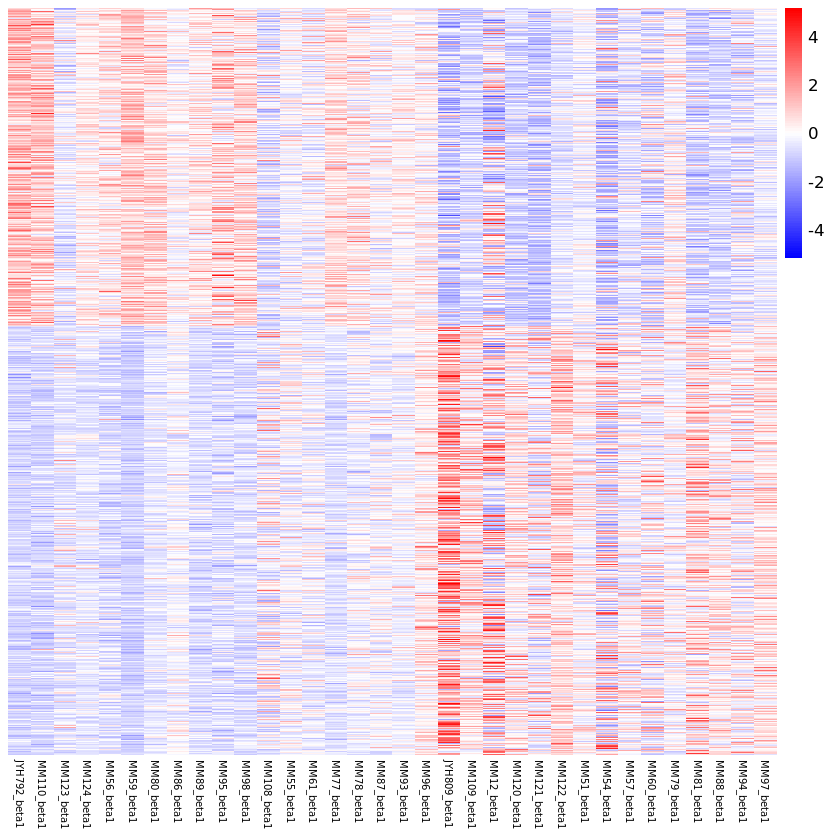

In [203]:
## beta cell differential cCREs
A_TN=read.csv(paste0(wd_snATAC,'beta1_T2D_ND.csv')) ##
A_TP=read.csv(paste0(wd_snATAC,'beta1_T2D_PD.csv')) ##
A_PN=read.csv(paste0(wd_snATAC,'beta1_PD_ND.csv')) ##
all(rownames(A_TN)==rownames(A_TP))

A1=A_PN
colnames(A1)=c('X','baseMean','log2FC_PN','lfcSE_PN','stat_PN','pvalue_PN','padj_PN')
A2=A_TP[,c(3:7)]
colnames(A2)=c('log2FC_TP','lfcSE_TP','stat_TP','pvalue_TP','padj_TP')
A3=A_TN[,c(3:7)]
colnames(A3)=c('log2FC_TN','lfcSE_TN','stat_TN','pvalue_TN','padj_TN')
tt=cbind(A1,A2)
A=cbind(tt,A3)

th=0.1
A[is.na(A)]=10
peak_all=as.character(A$X)
peak_TNup_1=peak_all[A$stat_TN>0 & A$padj_TN<th]
peak_TNdown_1=peak_all[A$stat_TN<0 & A$padj_TN<th]
peak_PNup_1=peak_all[A$stat_PN>0 & A$padj_PN<th]
peak_PNdown_1=peak_all[A$stat_PN<0 & A$padj_PN<th]
peak_TPup_1=peak_all[A$stat_TP>0 & A$padj_TP<th]
peak_TPdown_1=peak_all[A$stat_TP<0 & A$padj_TP<th]

length(peak_PNup_1)
length(peak_PNdown_1)
length(peak_TPup_1)
length(peak_TPdown_1)
length(peak_TNup_1)
length(peak_TNdown_1)

peak_up_1=unique(c(peak_PNup_1,peak_TPup_1,peak_TNup_1))
peak_down_1=unique(c(peak_PNdown_1,peak_TPdown_1,peak_TNdown_1))
peak_union_1=c(peak_up_1,peak_down_1)
length(peak_up_1)
length(peak_down_1)
length(peak_union_1)

###### heatmap
C_diff_up=C_norm[(rownames(C_norm) %in% peak_up_1),]
dim(C_diff_up)

C_diff_down=C_norm[(rownames(C_norm) %in% peak_down_1),]
dim(C_diff_down)

C_diff=rbind(C_diff_down,C_diff_up)
pheatmap(C_diff,scale='row',show_rownames = FALSE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("blue",'white',"red"))(100))


### beta-2

In [204]:
rm(list = ls())
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

C=read.csv(paste0(wd_snATAC,'biobank_snATAC_beta_subtype.csv'))
C_all=as.matrix(C[,-1])
rownames(C_all)=as.character(C$X)
## beta-1
C_all=C_all[,35:68]

C_norm=C_all
for (i in 1:dim(C_all)[2]){
    C_norm[,i]=(C_all[,i]/sum(C_all[,i]))*1000000
}
C_norm[1:3,]

MM=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C_norm=C_norm[,order(MM$Sample.Description.Name)]
MM2=MM[order(MM$Sample.Description.Name),]

JYH792_beta2 JYH809_beta2 MM108_beta2 MM109_beta2
1:100009946-100010446 3.084036     4.6133141    8.003229    6.6619170  
1:100014513-100015013 3.084036     2.9357453    6.288251    2.8551073  
1:100017730-100018230 0.000000     0.4193922    1.714978    0.5710215  
                      MM110_beta2 MM12_beta2 MM120_beta2 MM121_beta2
1:100009946-100010446 4.324408    7.1602795  2.823395    0.9728560  
1:100014513-100015013 2.751896    2.9483504  1.660821    0.9728560  
1:100017730-100018230 1.179384    0.4211929  0.000000    0.8107133  
                      MM122_beta2 MM123_beta2 ⋯ MM86_beta2 MM87_beta2
1:100009946-100010446 5.311959    2.4945395   ⋯ 8.166309   7.4455640 
1:100014513-100015013 2.503337    1.2472697   ⋯ 4.298057   2.6804030 
1:100017730-100018230 0.427399    0.2494539   ⋯ 0.000000   0.5956451 
                      MM88_beta2 MM89_beta2 MM93_beta2 MM94_beta2 MM95_beta2
1:100009946-100010446 4.3423291  3.573531   5.4901032  5.268405   6.340878  
1:100014513-100015013 2.5139800  3.298644   3.1372018  2.383326   2.465897  
1:100017730-100018230 0.2285436  0.274887   0.3361288  0.000000   1.937491  
                      MM96_beta2 MM97_beta2 MM98_beta2
1:100009946-100010446 3.5791696  3.967279   5.2088947 
1:100014513-100015013 4.9457616  2.328620   2.4041053 
1:100017730-100018230 0.1301516  0.431226   0.4006842

[1] TRUE

[1] 0

[1] 0

[1] 0

[1] 0

[1] 456

[1] 627

[1] 456

[1] 627

[1] 1083

[1] 456  34

[1] 627  34

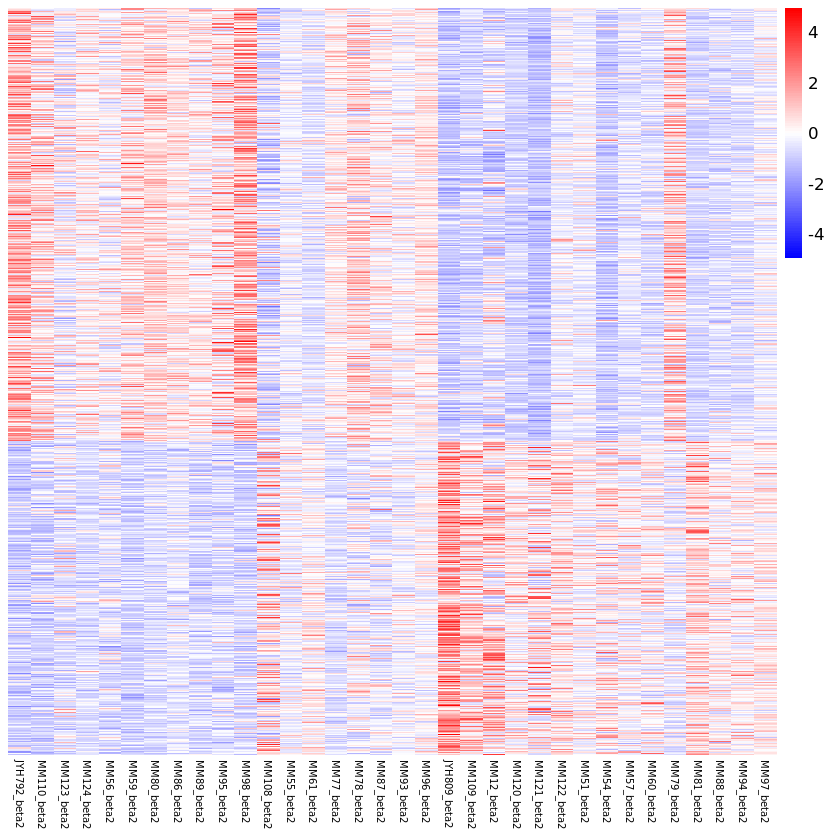

In [205]:
## beta cell differential cCREs
A_TN=read.csv(paste0(wd_snATAC,'beta2_T2D_ND.csv'))
A_TP=read.csv(paste0(wd_snATAC,'beta2_T2D_PD.csv'))
A_PN=read.csv(paste0(wd_snATAC,'beta2_PD_ND.csv'))
all(rownames(A_TN)==rownames(A_TP))

A1=A_PN
colnames(A1)=c('X','baseMean','log2FC_PN','lfcSE_PN','stat_PN','pvalue_PN','padj_PN')
A2=A_TP[,c(3:7)]
colnames(A2)=c('log2FC_TP','lfcSE_TP','stat_TP','pvalue_TP','padj_TP')
A3=A_TN[,c(3:7)]
colnames(A3)=c('log2FC_TN','lfcSE_TN','stat_TN','pvalue_TN','padj_TN')
tt=cbind(A1,A2)
A=cbind(tt,A3)

th=0.1
A[is.na(A)]=10
peak_all=as.character(A$X)
peak_TNup_2=peak_all[A$stat_TN>0 & A$padj_TN<th]
peak_TNdown_2=peak_all[A$stat_TN<0 & A$padj_TN<th]
peak_PNup_2=peak_all[A$stat_PN>0 & A$padj_PN<th]
peak_PNdown_2=peak_all[A$stat_PN<0 & A$padj_PN<th]
peak_TPup_2=peak_all[A$stat_TP>0 & A$padj_TP<th]
peak_TPdown_2=peak_all[A$stat_TP<0 & A$padj_TP<th]


length(peak_PNup_2)
length(peak_PNdown_2)
length(peak_TPup_2)
length(peak_TPdown_2)
length(peak_TNup_2)
length(peak_TNdown_2)

peak_up_2=unique(c(peak_PNup_2,peak_TPup_2,peak_TNup_2))
peak_down_2=unique(c(peak_PNdown_2,peak_TPdown_2,peak_TNdown_2))

peak_union_2=c(peak_up_2,peak_down_2)

length(peak_up_2)
length(peak_down_2)
length(peak_union_2)

###### heatmap
C_diff_up=C_norm[(rownames(C_norm) %in% peak_up_2),]
dim(C_diff_up)

C_diff_down=C_norm[(rownames(C_norm) %in% peak_down_2),]
dim(C_diff_down)

C_diff=rbind(C_diff_down,C_diff_up)
pheatmap(C_diff,scale='row',show_rownames = FALSE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("blue",'white',"red"))(100))


# Beta cell subtype differential TF-gene modules during T2D progression (Figure 5c-d, S Figure 10 c-d)

In [206]:
library(GSA)
rm(list=ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

###### gene clusters
z=read.csv(paste0(wd_multiome,'TFmodule_bulk_pos_0.01.csv'))
z=z[,-1]
gene_sets=list(1)
for (i in 1:dim(z)[2]){
  gene_sets[[i]]=toupper(unique(as.character(z[,i])))
}
dim(z)

[1] 2500  264

In [207]:
## gene expression data
##Input 1: bulk matrix dataset
C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)

## beta-1
C_norm=C_norm[,1:20]
#colnames(C_norm)=gsub("_beta1",  '', colnames(C_norm))

donor_ID=colnames(C_norm)
MM=read.csv(paste0(wd_snATAC,'meta_data.csv'))
MM$Short.ID=paste0(MM$Short.ID,'_beta1')
MM1=MM[MM$Short.ID %in% donor_ID,]
MM2=MM1[order(MM1$Short.ID), ]
all(MM2$Short.ID==donor_ID)

disease=as.character(MM2$Sample.Description.Name)
disease1=rep(0,length(disease))
disease1[disease=='Non']=1
disease1[disease=='Pre']=2
disease1[disease=='T2D']=3
disease1


[1] TRUE

[1] 2 1 2 3 1 2 2 2 3 1 2 2 3 3 2 3 3 1 1 1

In [208]:
x_all=C_norm[,disease1 %in% c(1,2)]
genenames=rownames(x_all)
y_label=disease1[disease1 %in% c(1,2)]

GSA_temp=GSA(x_all,y_label, genesets=gene_sets,genenames,method="maxmean", resp.type="Two class unpaired",minsize=10,maxsize=5000,nperms=1000)
GSA_result=cbind(GSA_temp$GSA.scores,GSA_temp$pvalues.lo,GSA_temp$pvalues.hi)
colnames(GSA_result)=c('score','pvalue_low','pvalue_high')
rownames(GSA_result)=toupper(colnames(z))
GSA_result[1:4,]

perm= 10 / 1000 
perm= 20 / 1000 
perm= 30 / 1000 
perm= 40 / 1000 
perm= 50 / 1000 
perm= 60 / 1000 
perm= 70 / 1000 
perm= 80 / 1000 
perm= 90 / 1000 
perm= 100 / 1000 
perm= 110 / 1000 
perm= 120 / 1000 
perm= 130 / 1000 
perm= 140 / 1000 
perm= 150 / 1000 
perm= 160 / 1000 
perm= 170 / 1000 
perm= 180 / 1000 
perm= 190 / 1000 
perm= 200 / 1000 
perm= 210 / 1000 
perm= 220 / 1000 
perm= 230 / 1000 
perm= 240 / 1000 
perm= 250 / 1000 
perm= 260 / 1000 
perm= 270 / 1000 
perm= 280 / 1000 
perm= 290 / 1000 
perm= 300 / 1000 
perm= 310 / 1000 
perm= 320 / 1000 
perm= 330 / 1000 
perm= 340 / 1000 
perm= 350 / 1000 
perm= 360 / 1000 
perm= 370 / 1000 
perm= 380 / 1000 
perm= 390 / 1000 
perm= 400 / 1000 
perm= 410 / 1000 
perm= 420 / 1000 
perm= 430 / 1000 
perm= 440 / 1000 
perm= 450 / 1000 
perm= 460 / 1000 
perm= 470 / 1000 
perm= 480 / 1000 
perm= 490 / 1000 
perm= 500 / 1000 
perm= 510 / 1000 
perm= 520 / 1000 
perm= 530 / 1000 
perm= 540 / 1000 
perm= 550 / 1000 
perm= 560 / 1000 
p

score     pvalue_low pvalue_high
IRF2 0.4568158 0.778      0.222      
PAX6 0.7406478 0.852      0.148      
PBX1 1.6198871 0.988      0.012      
RORA 0.5448858 0.796      0.204

In [80]:
#write.csv(GSA_result,'/projects/sanderlab/gaowei/snATAC_QC/final/data/GRN/diff_module/beta1_PN_neg_0.01.csv')

## Differential TF-gene modules during T2D progression

## beta1

In [209]:
rm(list=ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A_pos=read.csv(paste0(wd_multiome,'beta1_PN_pos_0.01.csv'))
A_neg=read.csv(paste0(wd_multiome,'beta1_PN_neg_0.01.csv'))
p1=as.numeric(A_pos$pvalue_low)
p2=as.numeric(A_pos$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}

A_pos1=A_pos[,c(1,2)]
A_pos1$pvalue=p1
colnames(A_pos1)=c('TF','score_pos','pvalue_pos')

p1=as.numeric(A_neg$pvalue_low)
p2=as.numeric(A_neg$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}
A_neg1=A_neg[,c(1,2)]
A_neg1$pvalue=p1
colnames(A_neg1)=c('TF','score_neg','pvalue_neg')

A=merge(A_pos1,A_neg1,by='TF',all=FALSE)

keep2_1=(A$pvalue_pos<0.05 & abs(A$score_pos)>1.3)
keep2_2=(A$pvalue_neg<0.05 & abs(A$score_neg)>1.3)
#keep2_3=(abs(A$score_pos)<9 & abs(A$score_neg)<9)
A_TF=A[(keep2_1 | keep2_2),]
dim(A_TF)

A_TF$score_mean=(A_TF$score_pos - A_TF$score_neg)
TF_all=as.character(A_TF$TF)

beta1_PN_up=TF_all[A_TF$score_mean>0]
beta1_PN_down=TF_all[A_TF$score_mean<0]
beta1_PN_up
beta1_PN_down
#A_TF

[1] 31  5

[1] "CUX1"   "HES1"   "HMBOX1" "MEIS1"  "NFIA"   "PBX1"   "PBX3"   "RFX3"  
 [9] "RFX7"   "RORB"   "TCF4"   "TCF7L2" "TEAD1"

[1] "CEBPG"  "FOXK2"  "GMEB2"  "HNF1B"  "HSF1"   "MAX"    "MEF2D"  "MNT"   
 [9] "RELA"   "RHOXF1" "RORC"   "TFAP2E" "USF1"   "ZNF143" "ZNF24"  "ZNF274"
[17] "ZNF282" "ZNF317"

In [210]:
A_pos=read.csv(paste0(wd_multiome,'beta1_TP_pos_0.01.csv'))
A_neg=read.csv(paste0(wd_multiome,'beta1_TP_neg_0.01.csv'))
p1=as.numeric(A_pos$pvalue_low)
p2=as.numeric(A_pos$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}

A_pos1=A_pos[,c(1,2)]
A_pos1$pvalue=p1
colnames(A_pos1)=c('TF','score_pos','pvalue_pos')

p1=as.numeric(A_neg$pvalue_low)
p2=as.numeric(A_neg$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}
A_neg1=A_neg[,c(1,2)]
A_neg1$pvalue=p1
colnames(A_neg1)=c('TF','score_neg','pvalue_neg')

A=merge(A_pos1,A_neg1,by='TF',all=FALSE)
keep1=(A$pvalue_pos<0.05 & A$pvalue_neg<0.05)
A_test1=A[keep1,]
#as.character(A_test1$TF)

keep2_1=(A$pvalue_pos<0.05 & abs(A$score_pos)>1.3)
keep2_2=(A$pvalue_neg<0.05 & abs(A$score_neg)>1.3)
#keep2_3=(abs(A$score_pos)<9 & abs(A$score_neg)<9)
A_TF=A[(keep2_1 | keep2_2),]
dim(A_TF)

A_TF$score_mean=(A_TF$score_pos - A_TF$score_neg)
TF_all=as.character(A_TF$TF)

beta1_TP_up=TF_all[A_TF$score_mean>0]
beta1_TP_down=TF_all[A_TF$score_mean<0]
beta1_TP_up
beta1_TP_down
#A_TF

[1] 19  5

[1] "ATF2"    "ATF6"    "BACH1"   "GABPA"   "KLF11"   "ONECUT2" "RBPJ"   
 [8] "SMAD5"   "SP3"     "SP4"     "ZNF682"

[1] "ASCL1" "CENPB" "DBP"   "HNF1A" "HNF4A" "INSM1" "KLF16" "PAX5"

In [211]:
A_pos=read.csv(paste0(wd_multiome,'beta1_TN_pos_0.01.csv'))
A_neg=read.csv(paste0(wd_multiome,'beta1_TN_neg_0.01.csv'))
p1=as.numeric(A_pos$pvalue_low)
p2=as.numeric(A_pos$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}

A_pos1=A_pos[,c(1,2)]
A_pos1$pvalue=p1
colnames(A_pos1)=c('TF','score_pos','pvalue_pos')

p1=as.numeric(A_neg$pvalue_low)
p2=as.numeric(A_neg$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}
A_neg1=A_neg[,c(1,2)]
A_neg1$pvalue=p1
colnames(A_neg1)=c('TF','score_neg','pvalue_neg')

A=merge(A_pos1,A_neg1,by='TF',all=FALSE)
keep1=(A$pvalue_pos<0.05 & A$pvalue_neg<0.05)
A_test1=A[keep1,]
#as.character(A_test1$TF)

keep2_1=(A$pvalue_pos<0.05 & abs(A$score_pos)>1.3)
keep2_2=(A$pvalue_neg<0.05 & abs(A$score_neg)>1.3)
#keep2_3=(abs(A$score_pos)<9 & abs(A$score_neg)<9)
A_TF=A[(keep2_1 | keep2_2),]
dim(A_TF)

A_TF$score_mean=(A_TF$score_pos - A_TF$score_neg)
TF_all=as.character(A_TF$TF)

beta1_TN_up=TF_all[A_TF$score_mean>0]
beta1_TN_down=TF_all[A_TF$score_mean<0]
beta1_TN_up
beta1_TN_down
#A_TF

[1] 37  5

[1] "ATF7"    "CLOCK"   "E2F3"    "ESR1"    "ETV6"    "HMBOX1"  "NFIA"   
 [8] "NR2F2"   "ONECUT2" "PBX1"    "PROX1"   "RFX7"    "RORB"    "RUNX2"  
[15] "SMAD3"   "TFEB"

[1] "CEBPG"   "CENPB"   "DBP"     "ELF3"    "ERF"     "GMEB2"   "HNF1A"  
 [8] "HSF1"    "JUND"    "KLF16"   "MEIS3"   "MNT"     "NFE2L1"  "PAX5"   
[15] "RELA"    "RORC"    "TFE3"    "USF1"    "USF2"    "XBP1"    "ZKSCAN1"

In [212]:
TF_up=unique(c(beta1_PN_up,beta1_TN_up,beta1_TP_up))
TF_down=unique(c(beta1_PN_down,beta1_TN_down,beta1_TP_down))

#TF_up=unique(beta1_TN_up)
#TF_down=unique(beta1_TN_down)
TF_up
TF_down

TF_PN=unique(c(beta1_PN_up,beta1_PN_down))
TF_TP=unique(c(beta1_TP_up,beta1_TP_down))
TF_TN=unique(c(beta1_TN_up,beta1_TN_down))

TF_PN
TF_TP
TF_TN

[1] "CUX1"    "HES1"    "HMBOX1"  "MEIS1"   "NFIA"    "PBX1"    "PBX3"   
 [8] "RFX3"    "RFX7"    "RORB"    "TCF4"    "TCF7L2"  "TEAD1"   "ATF7"   
[15] "CLOCK"   "E2F3"    "ESR1"    "ETV6"    "NR2F2"   "ONECUT2" "PROX1"  
[22] "RUNX2"   "SMAD3"   "TFEB"    "ATF2"    "ATF6"    "BACH1"   "GABPA"  
[29] "KLF11"   "RBPJ"    "SMAD5"   "SP3"     "SP4"     "ZNF682"

[1] "CEBPG"   "FOXK2"   "GMEB2"   "HNF1B"   "HSF1"    "MAX"     "MEF2D"  
 [8] "MNT"     "RELA"    "RHOXF1"  "RORC"    "TFAP2E"  "USF1"    "ZNF143" 
[15] "ZNF24"   "ZNF274"  "ZNF282"  "ZNF317"  "CENPB"   "DBP"     "ELF3"   
[22] "ERF"     "HNF1A"   "JUND"    "KLF16"   "MEIS3"   "NFE2L1"  "PAX5"   
[29] "TFE3"    "USF2"    "XBP1"    "ZKSCAN1" "ASCL1"   "HNF4A"   "INSM1"

[1] "CUX1"   "HES1"   "HMBOX1" "MEIS1"  "NFIA"   "PBX1"   "PBX3"   "RFX3"  
 [9] "RFX7"   "RORB"   "TCF4"   "TCF7L2" "TEAD1"  "CEBPG"  "FOXK2"  "GMEB2" 
[17] "HNF1B"  "HSF1"   "MAX"    "MEF2D"  "MNT"    "RELA"   "RHOXF1" "RORC"  
[25] "TFAP2E" "USF1"   "ZNF143" "ZNF24"  "ZNF274" "ZNF282" "ZNF317"

[1] "ATF2"    "ATF6"    "BACH1"   "GABPA"   "KLF11"   "ONECUT2" "RBPJ"   
 [8] "SMAD5"   "SP3"     "SP4"     "ZNF682"  "ASCL1"   "CENPB"   "DBP"    
[15] "HNF1A"   "HNF4A"   "INSM1"   "KLF16"   "PAX5"

[1] "ATF7"    "CLOCK"   "E2F3"    "ESR1"    "ETV6"    "HMBOX1"  "NFIA"   
 [8] "NR2F2"   "ONECUT2" "PBX1"    "PROX1"   "RFX7"    "RORB"    "RUNX2"  
[15] "SMAD3"   "TFEB"    "CEBPG"   "CENPB"   "DBP"     "ELF3"    "ERF"    
[22] "GMEB2"   "HNF1A"   "HSF1"    "JUND"    "KLF16"   "MEIS3"   "MNT"    
[29] "NFE2L1"  "PAX5"    "RELA"    "RORC"    "TFE3"    "USF1"    "USF2"   
[36] "XBP1"    "ZKSCAN1"

In [213]:
T=read.csv(paste0(wd_snATAC,'TFmotif_beta1_progression.csv'))
TF_homer_all=as.character(T$X)
keep_homer=(T$PN_p<0.05 | T$TP_p<0.05 | T$TN_p<0.05)
TF_homer=TF_homer_all[keep_homer]

TF_up=intersect(TF_up,TF_homer)
TF_down=intersect(TF_down,TF_homer)

TF_up
TF_down

[1] "NFIA" "ATF7" "ESR1" "ETV6" "TFEB" "ATF6"

[1] "HNF1B" "MAX"   "DBP"   "ELF3"  "HNF1A" "XBP1"

In [214]:
## expression data
z_pos=read.csv(paste0(wd_multiome,'TFmodule_bulk_pos_0.05.csv'))
z_neg=read.csv(paste0(wd_multiome,'TFmodule_bulk_neg_0.05.csv'))

####
## gene expression data
####
C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)
dim(C_norm)

####### fold change
n_sample=0.5*dim(C_norm)[2]

########

C_norm=C_norm[,1:n_sample]
temp_name=gsub("_beta1",  '', colnames(C_norm))
colnames(C_norm)=temp_name

C_norm_temp=C_norm
for (i in 1:dim(C_norm)[1]){
    C_norm_temp[i,]=(C_norm[i,]-mean(C_norm[i,]))/sd(C_norm[i,])
}
C_norm=C_norm_temp
C_norm[1:3,]

[1] 18575    40

A0011      A0019      A0021       A0024      A0027      A0028     
A1BG     -0.7784146  0.4280105  1.75589463 -0.1455649 -0.1995766 -0.4690531
A1BG-AS1  0.6102034  0.3678239 -0.05354465  0.5498324 -0.2040466 -0.3530605
A1CF      0.3041504 -0.2754173  1.15010597 -1.7313396 -1.3750973  0.4031323
         A0029     A0030      A0031      A0033      C0013      C0014      
A1BG     1.8799278 -0.4961903 -0.3717488 -0.2793451  2.3583872 -0.06144385
A1BG-AS1 1.5848330 -1.6366497  1.5490031 -0.4852789 -0.2325990 -0.42383805
A1CF     0.4735446  0.6539811 -1.5018623  0.8264278  0.5905195  1.70207118
         C0019     C0021      C0022      C0023       C0024      C0025     
A1BG     -0.836899 -0.6543812 -0.3992003 -1.04186675 -0.6650218 -0.6028180
A1BG-AS1 -1.613879  0.2795429 -0.8468421 -0.03693453 -1.8450241  0.8653770
A1CF     -1.356145 -0.4488130  0.5568068  1.13373915  0.4818703  0.2328906
         C0026     C0027     
A1BG      1.273890 -0.6945861
A1BG-AS1  1.489184  0.4358971
A1CF     -0.765276 -1.0552892

In [215]:
## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[C$Short.ID %in% colnames(C_norm),]
C=C[order(C$Short.ID),]
all(C$Short.ID==colnames(C_norm))
C_norm1=C_norm[,order(C$Sample.Description.Name)]
C1=C[order(C$Sample.Description.Name),]
all(C1$Short.ID==colnames(C_norm1))

[1] TRUE

[1] TRUE

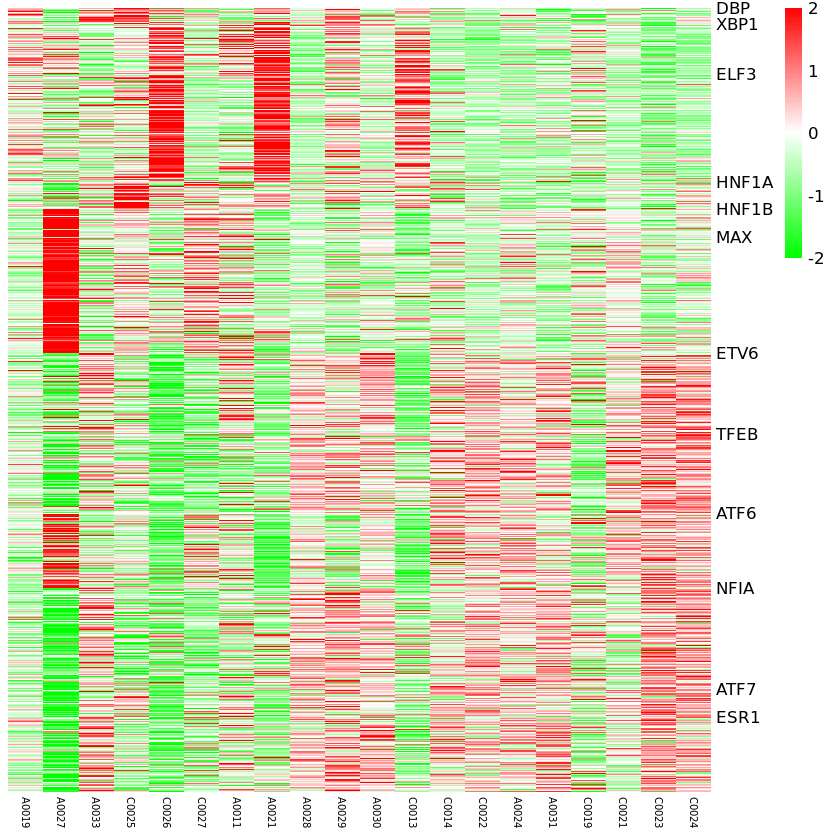

In [216]:
#TF_test=c(TF_down,TF_up) 
TF_test = c('DBP','XBP1','ELF3','HNF1A','HNF1B','MAX','ETV6','TFEB','ATF6','NFIA','ATF7','ESR1')
C_TF=C_norm1[1,]
for (i in 1:length(TF_test)) {
    gene_test=unique(as.character(z_pos[,colnames(z_pos)==TF_test[i]]))
    TF_temp=C_norm1[rownames(C_norm1) %in% gene_test,]
    rownames(TF_temp)=rep('',dim(TF_temp)[1])
    sample_n=dim(C_norm1)[2]
    int_matrix=matrix(0,1,sample_n)
    rownames(int_matrix)=TF_test[i]
    C_TF=rbind(C_TF,int_matrix)
    C_TF=rbind(C_TF,TF_temp)
}

C_TF=C_TF[-1,]


bk = unique(c(seq(-2,2, length=100)))
pheatmap(C_TF,scale='row',breaks=bk,show_rownames = TRUE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("green",'white',"red"))(100))


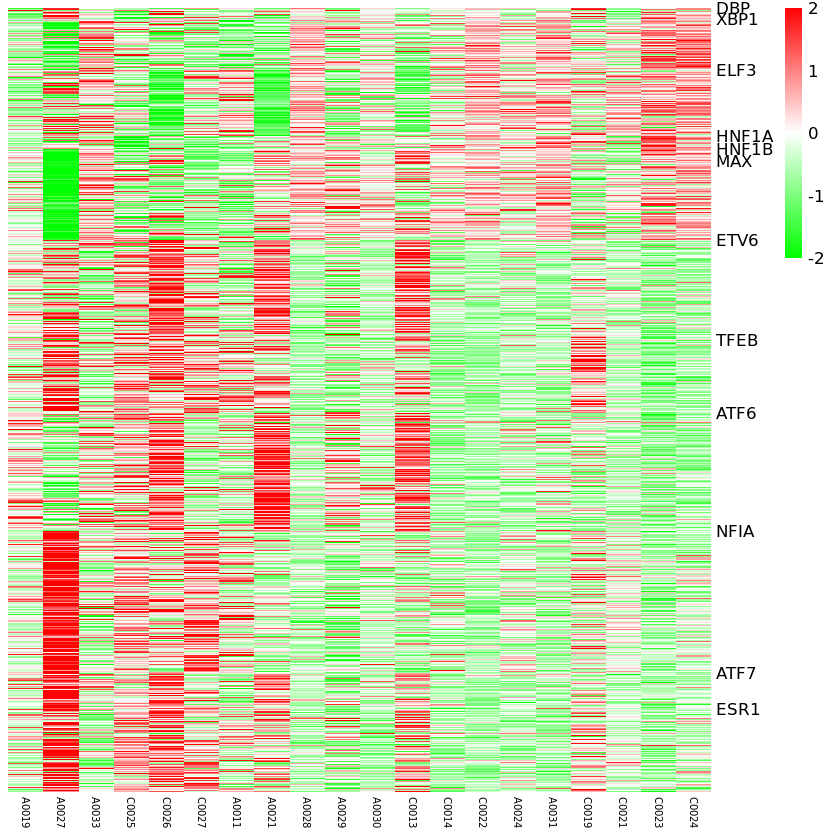

In [217]:
#TF_test=c(TF_down,TF_up)
TF_test = c('DBP','XBP1','ELF3','HNF1A','HNF1B','MAX','ETV6','TFEB','ATF6','NFIA','ATF7','ESR1')
C_TF=C_norm1[1,]
for (i in 1:length(TF_test)) {
    gene_test=unique(as.character(z_neg[,colnames(z_neg)==TF_test[i]]))
    TF_temp=C_norm1[rownames(C_norm1) %in% gene_test,]
    rownames(TF_temp)=rep('',dim(TF_temp)[1])
    sample_n=dim(C_norm1)[2]
    int_matrix=matrix(0,1,sample_n)
    rownames(int_matrix)=TF_test[i]
    C_TF=rbind(C_TF,int_matrix)
    C_TF=rbind(C_TF,TF_temp)
}

C_TF=C_TF[-1,]


bk = unique(c(seq(-2,2, length=100)))
pheatmap(C_TF,scale='row',breaks=bk,show_rownames = TRUE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("green",'white',"red"))(100))


## beta-2

In [218]:
rm(list=ls())

wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

A_pos=read.csv(paste0(wd_multiome,'beta2_PN_pos_0.01.csv'))
A_neg=read.csv(paste0(wd_multiome,'beta2_PN_neg_0.01.csv'))
p1=as.numeric(A_pos$pvalue_low)
p2=as.numeric(A_pos$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}

A_pos1=A_pos[,c(1,2)]
A_pos1$pvalue=p1
colnames(A_pos1)=c('TF','score_pos','pvalue_pos')

p1=as.numeric(A_neg$pvalue_low)
p2=as.numeric(A_neg$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}
A_neg1=A_neg[,c(1,2)]
A_neg1$pvalue=p1
colnames(A_neg1)=c('TF','score_neg','pvalue_neg')

A=merge(A_pos1,A_neg1,by='TF',all=FALSE)

keep2_1=(A$pvalue_pos<0.05 & abs(A$score_pos)>1.3)
keep2_2=(A$pvalue_neg<0.05 & abs(A$score_neg)>1.3)
#keep2_3=(abs(A$score_pos)<9 & abs(A$score_neg)<9)
A_TF=A[(keep2_1 | keep2_2),]
dim(A_TF)

A_TF$score_mean=(A_TF$score_pos - A_TF$score_neg)
TF_all=as.character(A_TF$TF)

beta1_PN_up=TF_all[A_TF$score_mean>0]
beta1_PN_down=TF_all[A_TF$score_mean<0]
beta1_PN_up
beta1_PN_down
#A_TF

[1] 29  5

[1] "CREB1"  "CUX1"   "HES1"   "HMBOX1" "HNF4G"  "MEIS1"  "NFIA"   "PBX1"  
 [9] "PBX3"   "RFX7"   "RORB"   "TCF4"   "TEAD1"

[1] "CEBPG"  "FOXK2"  "GMEB2"  "HNF1B"  "HSF1"   "MEF2D"  "RELA"   "RHOXF1"
 [9] "RORC"   "TFAP2E" "USF1"   "ZNF143" "ZNF24"  "ZNF274" "ZNF282" "ZNF317"

In [219]:
A_pos=read.csv(paste0(wd_multiome,'beta2_TP_pos_0.01.csv'))
A_neg=read.csv(paste0(wd_multiome,'beta2_TP_neg_0.01.csv'))

p1=as.numeric(A_pos$pvalue_low)
p2=as.numeric(A_pos$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}

A_pos1=A_pos[,c(1,2)]
A_pos1$pvalue=p1
colnames(A_pos1)=c('TF','score_pos','pvalue_pos')

p1=as.numeric(A_neg$pvalue_low)
p2=as.numeric(A_neg$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}
A_neg1=A_neg[,c(1,2)]
A_neg1$pvalue=p1
colnames(A_neg1)=c('TF','score_neg','pvalue_neg')

A=merge(A_pos1,A_neg1,by='TF',all=FALSE)
keep1=(A$pvalue_pos<0.05 & A$pvalue_neg<0.05)
A_test1=A[keep1,]
#as.character(A_test1$TF)

keep2_1=(A$pvalue_pos<0.05 & abs(A$score_pos)>1.3)
keep2_2=(A$pvalue_neg<0.05 & abs(A$score_neg)>1.3)
#keep2_3=(abs(A$score_pos)<9 & abs(A$score_neg)<9)
A_TF=A[(keep2_1 | keep2_2),]
dim(A_TF)

A_TF$score_mean=(A_TF$score_pos - A_TF$score_neg)
TF_all=as.character(A_TF$TF)

beta1_TP_up=TF_all[A_TF$score_mean>0]
beta1_TP_down=TF_all[A_TF$score_mean<0]
beta1_TP_up
beta1_TP_down
#A_TF

[1] 18  5

[1] "ATF2"    "ATF6"    "BACH1"   "ELK3"    "GABPA"   "ONECUT2" "RBPJ"   
 [8] "SP3"     "SP4"     "ZNF354C" "ZNF682"

[1] "ASCL1"  "CEBPD"  "CENPB"  "INSM1"  "PAX5"   "THAP11" "XBP1"

In [220]:
A_pos=read.csv(paste0(wd_multiome,'beta2_TN_pos_0.01.csv'))
A_neg=read.csv(paste0(wd_multiome,'beta2_TN_neg_0.01.csv'))

p1=as.numeric(A_pos$pvalue_low)
p2=as.numeric(A_pos$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}

A_pos1=A_pos[,c(1,2)]
A_pos1$pvalue=p1
colnames(A_pos1)=c('TF','score_pos','pvalue_pos')

p1=as.numeric(A_neg$pvalue_low)
p2=as.numeric(A_neg$pvalue_high)
for (i in 1:length(p1)){
    if (p1[i]>p2[i]){
        p1[i]=p2[i]
    }
}
A_neg1=A_neg[,c(1,2)]
A_neg1$pvalue=p1
colnames(A_neg1)=c('TF','score_neg','pvalue_neg')

A=merge(A_pos1,A_neg1,by='TF',all=FALSE)
keep1=(A$pvalue_pos<0.05 & A$pvalue_neg<0.05)
A_test1=A[keep1,]
#as.character(A_test1$TF)

keep2_1=(A$pvalue_pos<0.05 & abs(A$score_pos)>1.3)
keep2_2=(A$pvalue_neg<0.05 & abs(A$score_neg)>1.3)
#keep2_3=(abs(A$score_pos)<9 & abs(A$score_neg)<9)
A_TF=A[(keep2_1 | keep2_2),]
dim(A_TF)

A_TF$score_mean=(A_TF$score_pos - A_TF$score_neg)
TF_all=as.character(A_TF$TF)

beta1_TN_up=TF_all[A_TF$score_mean>0]
beta1_TN_down=TF_all[A_TF$score_mean<0]
beta1_TN_up
beta1_TN_down
#A_TF

[1] 35  5

[1] "CLOCK"   "CREB1"   "E2F3"    "ETV6"    "HMBOX1"  "NFIA"    "ONECUT2"
 [8] "PBX1"    "PROX1"   "RFX7"    "RORB"    "SMAD3"   "SRF"     "TEAD1"  
[15] "TFEB"    "ZNF682"

[1] "CEBPG"   "CENPB"   "DBP"     "ELF3"    "ERF"     "ESRRB"   "GMEB2"  
 [8] "HNF1A"   "HSF1"    "JUND"    "MEIS3"   "NFE2L1"  "PAX5"    "RELA"   
[15] "TFE3"    "USF1"    "USF2"    "XBP1"    "ZKSCAN1"

In [221]:
TF_up=unique(c(beta1_PN_up,beta1_TN_up,beta1_TP_up))
TF_down=unique(c(beta1_PN_down,beta1_TN_down,beta1_TP_down))

#TF_up=unique(beta1_TN_up)
#TF_down=unique(beta1_TN_down)
TF_up
TF_down

TF_PN=unique(c(beta1_PN_up,beta1_PN_down))
TF_TP=unique(c(beta1_TP_up,beta1_TP_down))
TF_TN=unique(c(beta1_TN_up,beta1_TN_down))

TF_PN
TF_TP
TF_TN

[1] "CREB1"   "CUX1"    "HES1"    "HMBOX1"  "HNF4G"   "MEIS1"   "NFIA"   
 [8] "PBX1"    "PBX3"    "RFX7"    "RORB"    "TCF4"    "TEAD1"   "CLOCK"  
[15] "E2F3"    "ETV6"    "ONECUT2" "PROX1"   "SMAD3"   "SRF"     "TFEB"   
[22] "ZNF682"  "ATF2"    "ATF6"    "BACH1"   "ELK3"    "GABPA"   "RBPJ"   
[29] "SP3"     "SP4"     "ZNF354C"

[1] "CEBPG"   "FOXK2"   "GMEB2"   "HNF1B"   "HSF1"    "MEF2D"   "RELA"   
 [8] "RHOXF1"  "RORC"    "TFAP2E"  "USF1"    "ZNF143"  "ZNF24"   "ZNF274" 
[15] "ZNF282"  "ZNF317"  "CENPB"   "DBP"     "ELF3"    "ERF"     "ESRRB"  
[22] "HNF1A"   "JUND"    "MEIS3"   "NFE2L1"  "PAX5"    "TFE3"    "USF2"   
[29] "XBP1"    "ZKSCAN1" "ASCL1"   "CEBPD"   "INSM1"   "THAP11"

[1] "CREB1"  "CUX1"   "HES1"   "HMBOX1" "HNF4G"  "MEIS1"  "NFIA"   "PBX1"  
 [9] "PBX3"   "RFX7"   "RORB"   "TCF4"   "TEAD1"  "CEBPG"  "FOXK2"  "GMEB2" 
[17] "HNF1B"  "HSF1"   "MEF2D"  "RELA"   "RHOXF1" "RORC"   "TFAP2E" "USF1"  
[25] "ZNF143" "ZNF24"  "ZNF274" "ZNF282" "ZNF317"

[1] "ATF2"    "ATF6"    "BACH1"   "ELK3"    "GABPA"   "ONECUT2" "RBPJ"   
 [8] "SP3"     "SP4"     "ZNF354C" "ZNF682"  "ASCL1"   "CEBPD"   "CENPB"  
[15] "INSM1"   "PAX5"    "THAP11"  "XBP1"

[1] "CLOCK"   "CREB1"   "E2F3"    "ETV6"    "HMBOX1"  "NFIA"    "ONECUT2"
 [8] "PBX1"    "PROX1"   "RFX7"    "RORB"    "SMAD3"   "SRF"     "TEAD1"  
[15] "TFEB"    "ZNF682"  "CEBPG"   "CENPB"   "DBP"     "ELF3"    "ERF"    
[22] "ESRRB"   "GMEB2"   "HNF1A"   "HSF1"    "JUND"    "MEIS3"   "NFE2L1" 
[29] "PAX5"    "RELA"    "TFE3"    "USF1"    "USF2"    "XBP1"    "ZKSCAN1"

In [222]:
T=read.csv(paste0(wd_snATAC,'TFmotif_beta2_progression.csv'))
TF_homer_all=as.character(T$X)
keep_homer=(T$PN_p<0.05 | T$TP_p<0.05 | T$TN_p<0.05)
TF_homer=TF_homer_all[keep_homer]

TF_up=intersect(TF_up,TF_homer)
TF_down=intersect(TF_down,TF_homer)

TF_up
TF_down

[1] "ETV6" "TFEB" "ATF6"

[1] "TFAP2E" "CENPB"  "DBP"    "ELF3"   "TFE3"   "XBP1"   "THAP11"

In [224]:
## expression data
z_pos=read.csv(paste0(wd_multiome,'TFmodule_bulk_pos_0.05.csv'))
z_neg=read.csv(paste0(wd_multiome,'TFmodule_bulk_neg_0.05.csv'))

####
## gene expression data
####
C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)
dim(C_norm)

####### fold change
n_sample=0.5*dim(C_norm)[2]

########

C_norm=C_norm[,(1+n_sample):dim(C_norm)[2]]
temp_name=gsub("_beta2",  '', colnames(C_norm))
colnames(C_norm)=temp_name

C_norm_temp=C_norm
for (i in 1:dim(C_norm)[1]){
    C_norm_temp[i,]=(C_norm[i,]-mean(C_norm[i,]))/sd(C_norm[i,])
}
C_norm=C_norm_temp
C_norm[1:3,]

[1] 18575    40

A0011     A0019       A0021     A0024       A0027      A0028      
A1BG     0.4496103  1.32880285 1.6036950 -0.03930687 -0.1570570 -0.11049241
A1BG-AS1 2.5942831  0.77270887 0.4896601  0.14534828 -0.6992680  0.01804670
A1CF     1.0552469 -0.02212075 0.5791607 -1.14018868 -0.9456303 -0.01584628
         A0029      A0030      A0031      A0033      C0013      C0014      
A1BG     -0.8998758 -0.8405214 -0.4333631 -0.7555622  3.0687617 -0.19295184
A1BG-AS1 -1.0123826 -0.8236138 -0.6147709 -1.7899319  0.1717386  0.08989594
A1CF     -0.8291709  0.8248727 -0.7903574  0.1980155 -0.8498633  2.74958759
         C0019      C0021      C0022       C0023      C0024      C0025     
A1BG     -0.7585337 -0.4975559 -0.51579730 -0.1719064 -0.5548086 -0.7440934
A1BG-AS1 -0.2896555 -0.2011625 -0.06909054 -1.3258717 -0.5906944  0.9154556
A1CF     -1.0429147 -0.8127792  0.47180611 -0.4248759 -0.5640195  1.5739803
         C0026      C0027     
A1BG      0.6969863 -0.4760303
A1BG-AS1  0.9320616  1.2872430
A1CF     -0.2250299  0.2101269

In [225]:
## metadata of donors
C=read.csv(paste0(wd_snATAC,'meta_data.csv'))
C=C[C$Short.ID %in% colnames(C_norm),]
C=C[order(C$Short.ID),]
all(C$Short.ID==colnames(C_norm))
C_norm1=C_norm[,order(C$Sample.Description.Name)]
C1=C[order(C$Sample.Description.Name),]
all(C1$Short.ID==colnames(C_norm1))

[1] TRUE

[1] TRUE

In [226]:
TF_test=c(TF_down,TF_up)
TF_test


[1] "TFAP2E" "CENPB"  "DBP"    "ELF3"   "TFE3"   "XBP1"   "THAP11" "ETV6"  
 [9] "TFEB"   "ATF6"

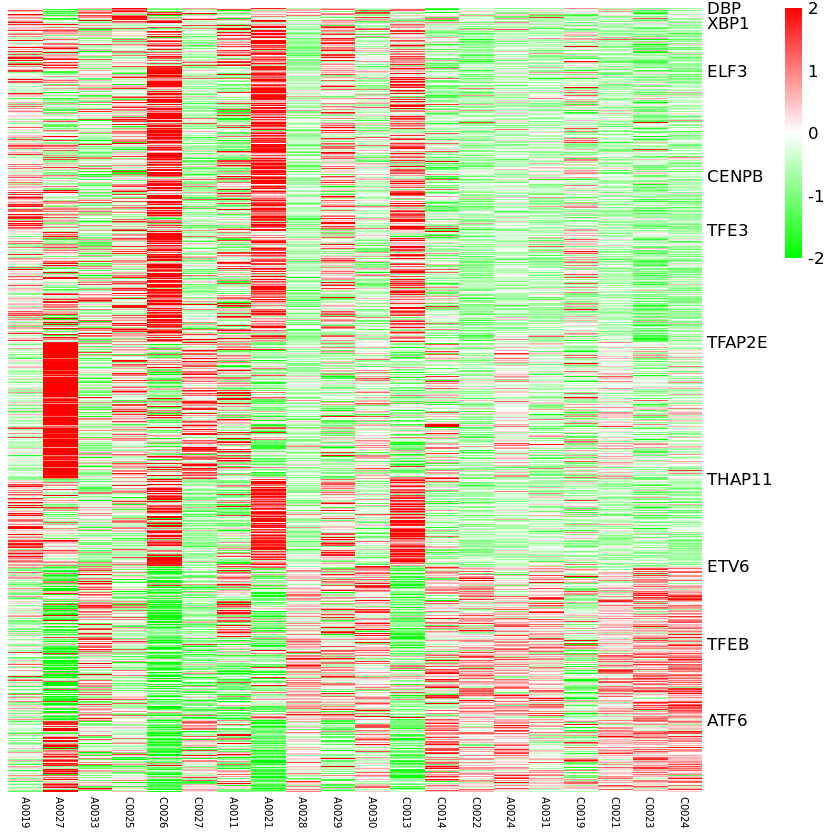

In [227]:
#TF_test=c(TF_down,TF_up) 
TF_test = c('DBP','XBP1','ELF3','CENPB','TFE3','TFAP2E','THAP11','ETV6','TFEB','ATF6')
C_TF=C_norm1[1,]
for (i in 1:length(TF_test)) {
    gene_test=unique(as.character(z_pos[,colnames(z_pos)==TF_test[i]]))
    TF_temp=C_norm1[rownames(C_norm1) %in% gene_test,]
    rownames(TF_temp)=rep('',dim(TF_temp)[1])
    sample_n=dim(C_norm1)[2]
    int_matrix=matrix(0,1,sample_n)
    rownames(int_matrix)=TF_test[i]
    C_TF=rbind(C_TF,int_matrix)
    C_TF=rbind(C_TF,TF_temp)
}

C_TF=C_TF[-1,]


bk = unique(c(seq(-2,2, length=100)))
pheatmap(C_TF,scale='row',breaks=bk,show_rownames = TRUE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("green",'white',"red"))(100))


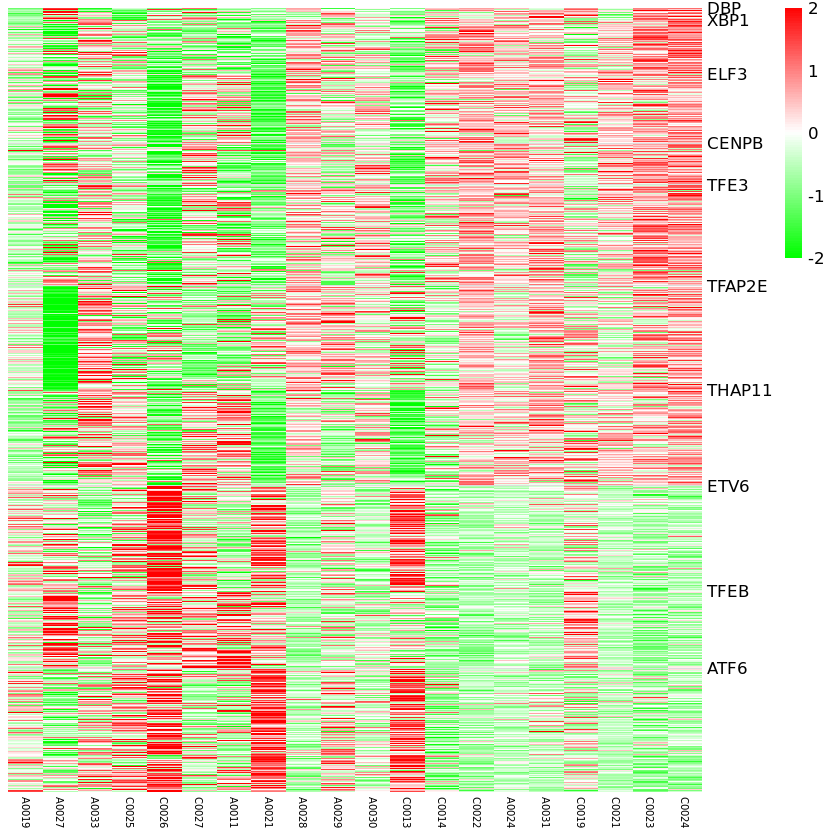

In [228]:
#TF_test=c(TF_down,TF_up) 
TF_test = c('DBP','XBP1','ELF3','CENPB','TFE3','TFAP2E','THAP11','ETV6','TFEB','ATF6')
C_TF=C_norm1[1,]
for (i in 1:length(TF_test)) {
    gene_test=unique(as.character(z_neg[,colnames(z_neg)==TF_test[i]]))
    TF_temp=C_norm1[rownames(C_norm1) %in% gene_test,]
    rownames(TF_temp)=rep('',dim(TF_temp)[1])
    sample_n=dim(C_norm1)[2]
    int_matrix=matrix(0,1,sample_n)
    rownames(int_matrix)=TF_test[i]
    C_TF=rbind(C_TF,int_matrix)
    C_TF=rbind(C_TF,TF_temp)
}

C_TF=C_TF[-1,]

bk = unique(c(seq(-2,2, length=100)))
pheatmap(C_TF,scale='row',breaks=bk,show_rownames = TRUE,cluster_cols=FALSE,cluster_rows=FALSE,fontsize_col=6,color = colorRampPalette(colors = c("green",'white',"red"))(100))


## Correlation between TFs

`geom_smooth()` using formula 'y ~ x'


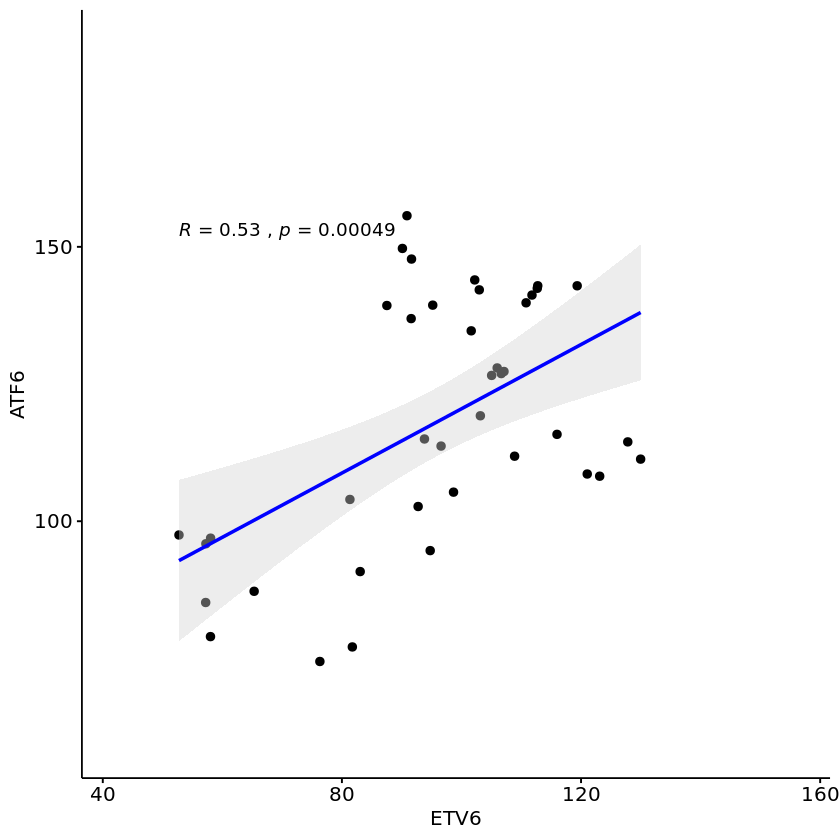

In [229]:
##Input 1: bulk matrix dataset
C=read.csv(paste0(wd_multiome,'multiome_RNA_TPM_4.csv'))
C_norm=as.matrix(C[,-1])
rownames(C_norm)=as.character(C$X)
C_norm=t(C_norm)
C_norm=as.data.frame(C_norm)

library('ggpubr')
M_temp1=C_norm
D_min=min(M_temp1$ETV6)
D_max=max(M_temp1$ETV6)
R_min=min(M_temp1$ATF6)
R_max=max(M_temp1$ATF6)

p2 <- ggscatter(as.data.frame(M_temp1), x = "ETV6", y = "ATF6",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="ETV6", ylab="ATF6")


`geom_smooth()` using formula 'y ~ x'


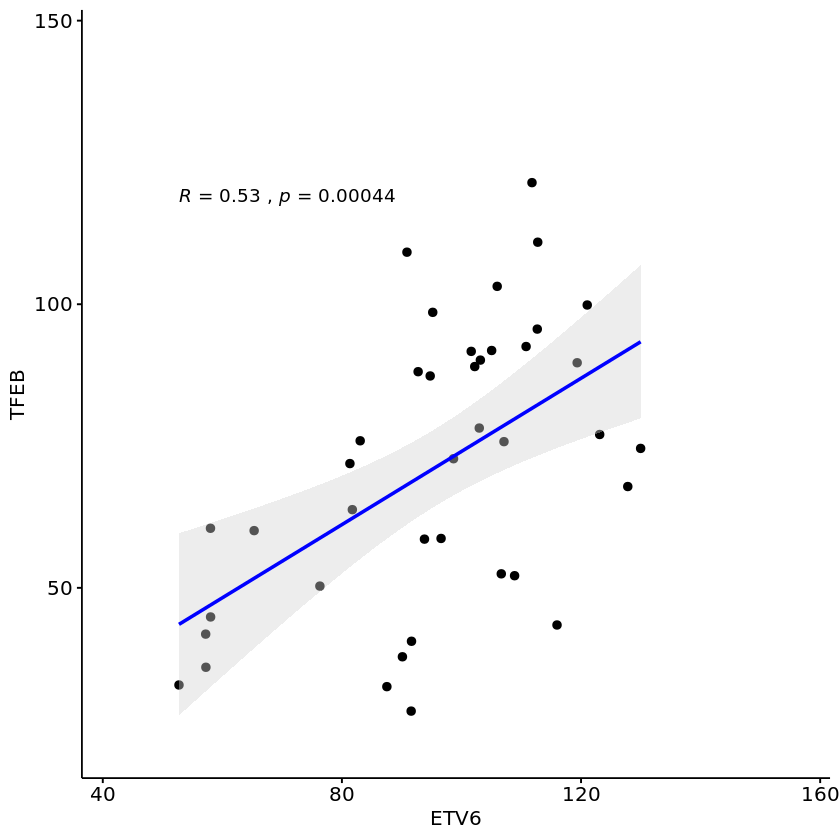

In [230]:
D_min=min(M_temp1$ETV6)
D_max=max(M_temp1$ETV6)
R_min=min(M_temp1$TFEB)
R_max=max(M_temp1$TFEB)

p2 <- ggscatter(as.data.frame(M_temp1), x = "ETV6", y = "TFEB",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="ETV6", ylab="TFEB")


`geom_smooth()` using formula 'y ~ x'


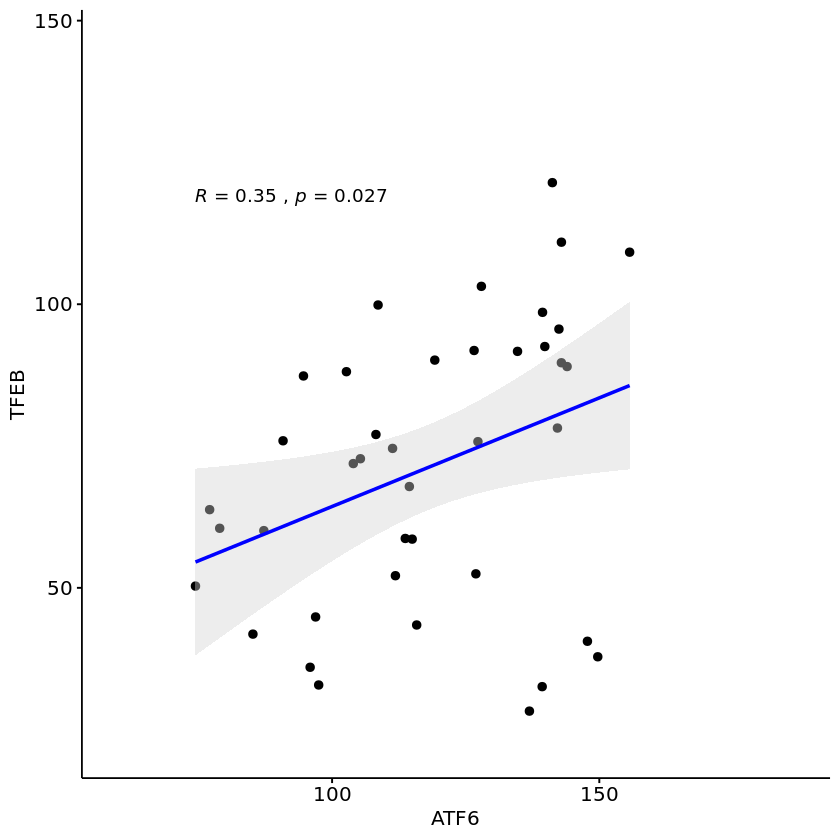

In [231]:
D_min=min(M_temp1$ATF6)
D_max=max(M_temp1$ATF6)
R_min=min(M_temp1$TFEB)
R_max=max(M_temp1$TFEB)

p2 <- ggscatter(as.data.frame(M_temp1), x = "ATF6", y = "TFEB",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="ATF6", ylab="TFEB")


`geom_smooth()` using formula 'y ~ x'


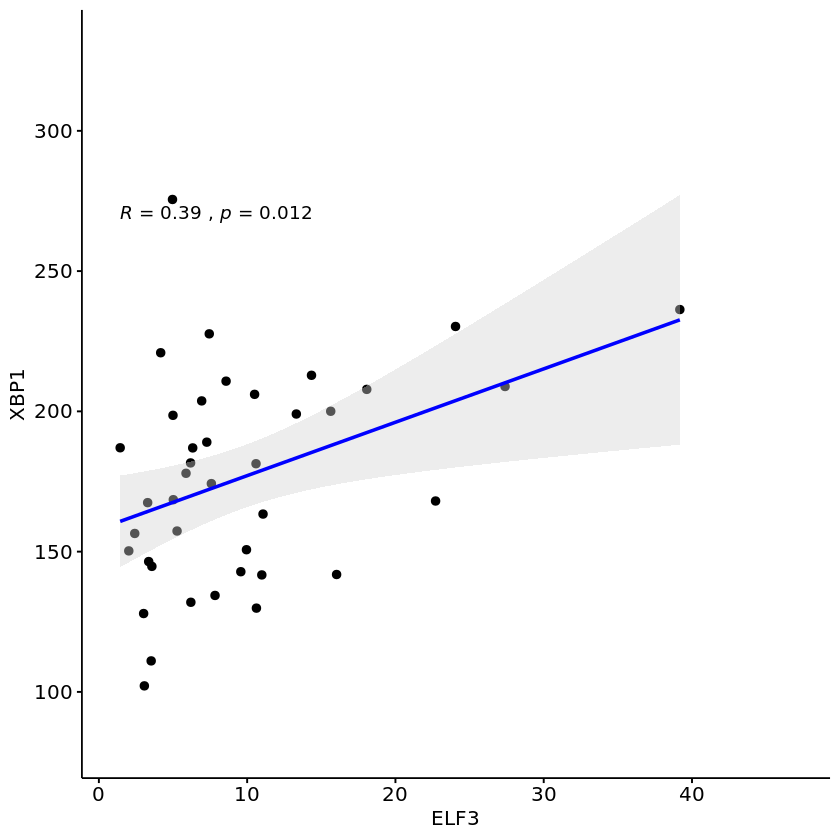

In [232]:
D_min=min(M_temp1$ELF3)
D_max=max(M_temp1$ELF3)
R_min=min(M_temp1$XBP1)
R_max=max(M_temp1$XBP1)

p2 <- ggscatter(as.data.frame(M_temp1), x = "ELF3", y = "XBP1",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="ELF3", ylab="XBP1")


`geom_smooth()` using formula 'y ~ x'


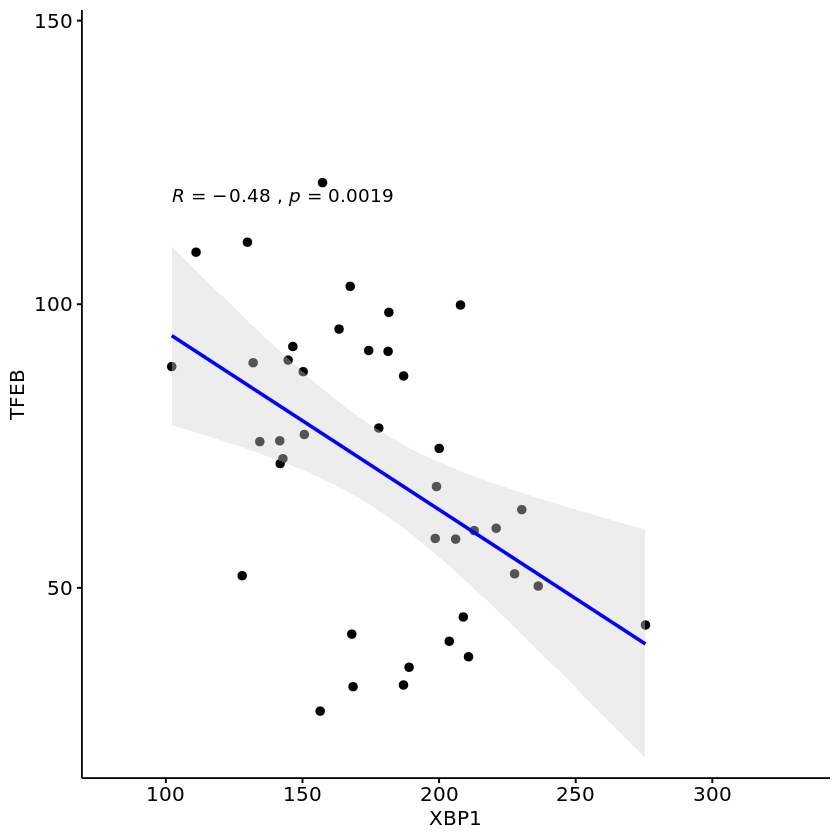

In [233]:
D_min=min(M_temp1$XBP1)
D_max=max(M_temp1$XBP1)
R_min=min(M_temp1$TFEB)
R_max=max(M_temp1$TFEB)

p2 <- ggscatter(as.data.frame(M_temp1), x = "XBP1", y = "TFEB",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="XBP1", ylab="TFEB")


`geom_smooth()` using formula 'y ~ x'


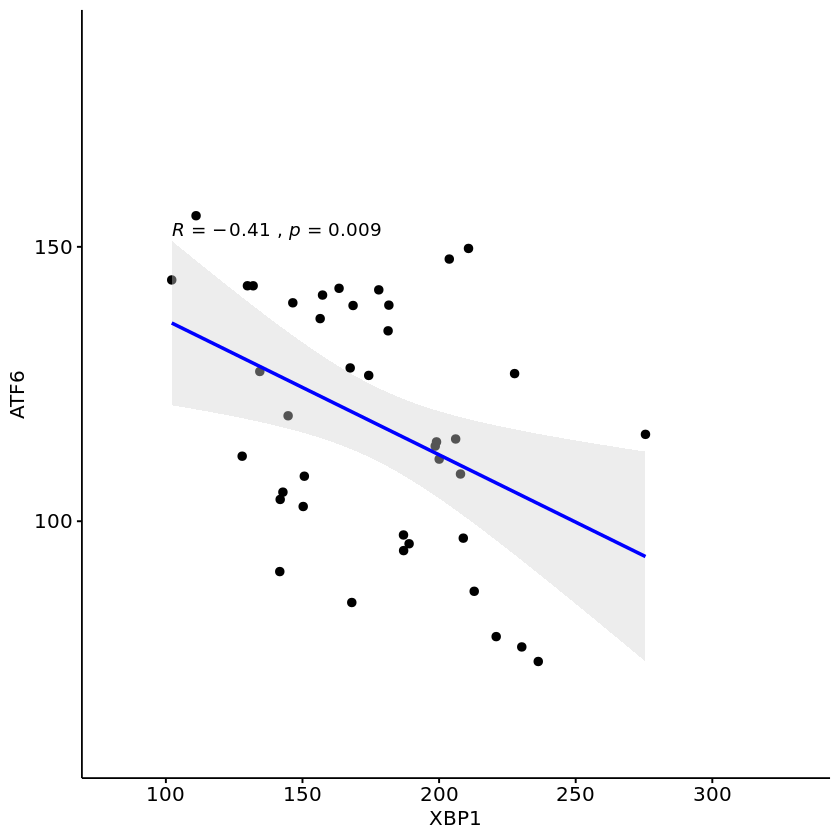

In [234]:
D_min=min(M_temp1$XBP1)
D_max=max(M_temp1$XBP1)
R_min=min(M_temp1$ATF6)
R_max=max(M_temp1$ATF6)

p2 <- ggscatter(as.data.frame(M_temp1), x = "XBP1", y = "ATF6",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="XBP1", ylab="ATF6")


`geom_smooth()` using formula 'y ~ x'


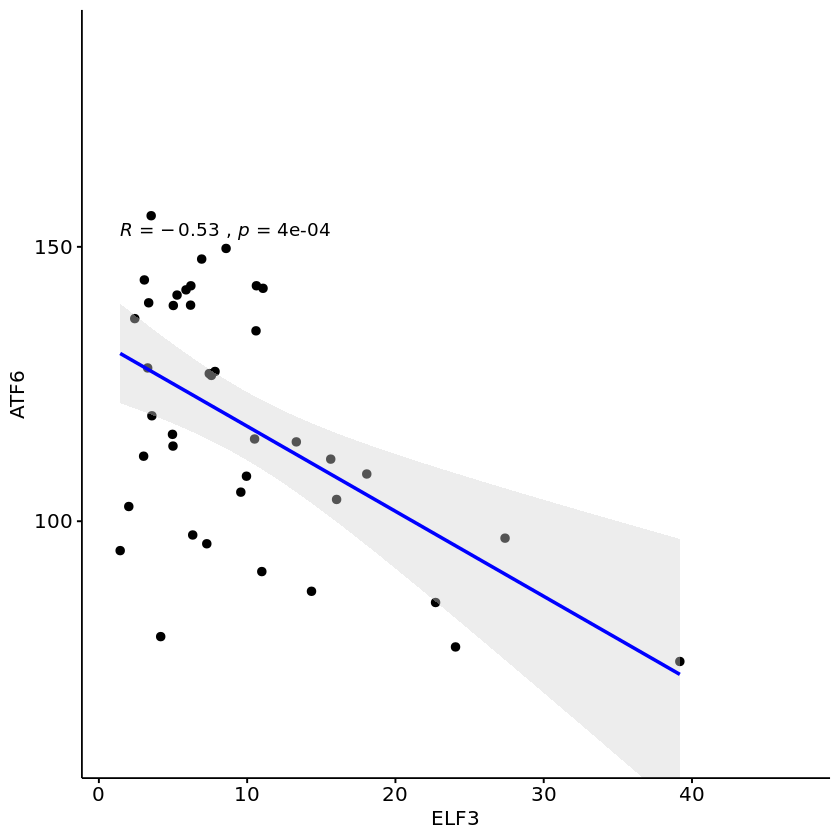

In [235]:
D_min=min(M_temp1$ELF3)
D_max=max(M_temp1$ELF3)
R_min=min(M_temp1$ATF6)
R_max=max(M_temp1$ATF6)

p2 <- ggscatter(as.data.frame(M_temp1), x = "ELF3", y = "ATF6",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="ELF3", ylab="ATF6")


`geom_smooth()` using formula 'y ~ x'


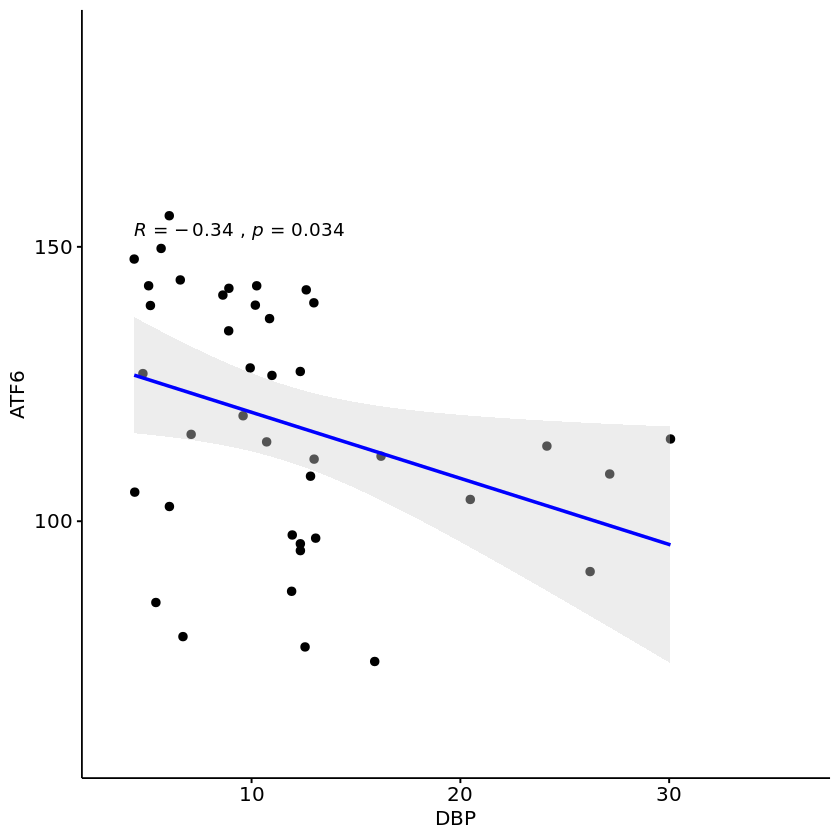

In [236]:
D_min=min(M_temp1$DBP)
D_max=max(M_temp1$DBP)
R_min=min(M_temp1$ATF6)
R_max=max(M_temp1$ATF6)

p2 <- ggscatter(as.data.frame(M_temp1), x = "DBP", y = "ATF6",
                add = "reg.line",  # Add regressin line)
                add.params = list(color = "blue", fill = "lightgray"),
                conf.int = TRUE,
                cor.coef = TRUE)

ggpar(p2,xlim = c(0.8*D_min,1.2*D_max),ylim = c(0.8*R_min,1.2*R_max),xlab="DBP", ylab="ATF6")
